🪐 The Search for Planet 9: Complete Computational Pipeline
Project Overview: This notebook synthesizes the search for "Planet 9" (and the alternative "Planet Y") using a chronological pipeline of 30+ scripts. Method: We start by harvesting live data, then move to Statistical Clustering (Phase 1), Machine Learning Classification (Phase 2), Bias De-biasing (Phase 3), and finally N-Body Physics (Phase 4).

🛠 Dependencies

In [57]:
# Install required libraries if missing
!pip install numpy pandas matplotlib scipy scikit-learn tensorflow seaborn requests rebound

In [58]:
import sys
# Code ran on VCS as a JupyterNotebook. If it gives errors when downloading tensorflow, use the following:
!{sys.executable} -m pip install --upgrade tensorflow
#It it gives errors when using the scikit module 
!{sys.executable} -m pip install --upgrade scikit-learn
# If it gives error when trying to use the seaborn library (crucial for later cells of code, 
# but most of the beginning code should work fine without it by using just matplotlib)
!{sys.executable} -m pip install seaborn

# This comes from the packages not being installed in the sam,e enviroment as the code, which is a really
# common issue when using platforms like VCS and one we ran into during the developement of the project.
# Definitely worth mentioning for those interesting in studying the code

📡 Phase 1: Data Harvesting & Preparation
Script 01: The Data Harvester (Reconstructed)
Goal: Download the latest Trans-Neptunian Object (TNO) data directly from the Minor Planet Center (MPC), filter for "Extreme" objects (ETNOs), and feature-engineer the angular components needed for the AI models. Output: processed_etnos.csv

In [59]:
import pandas as pd
import numpy as np
import requests
import io

# --- CONFIGURATION ---
MPC_URL = "https://www.minorplanetcenter.net/iau/MPCORB/Distant.txt"
OUTPUT_FILE = "processed_etnos.csv"

print(f"Downloading live data from {MPC_URL}...")

def fetch_and_process_data():
    # 1. Fetch Raw Data
    try:
        response = requests.get(MPC_URL)
        response.raise_for_status()
    except Exception as e:
        print(f"Download Failed: {e}")
        return

    # 2. Parse Fixed-Width MPC Format
    # The MPC format is messy fixed-width text. We parse it line by line.
    data = []
    lines = response.text.split('\n')
    
    print(f"Parsing {len(lines)} objects...")
    
    for line in lines:
        if len(line) < 100: continue # Skip headers/empty lines
        try:
            # Extract orbital elements (Fixed width positions)
            # a (Semi-major axis) is not explicit, we get 'n' (mean motion) or 'a' directly if available
            # Standard MPC Distant format usually has 'a' in columns roughly 92-103 or derived from 'n'
            # Let's try standard MPCORB unpacking:
            
            # This parser assumes standard MPC 1-line format
            # We use a robust method: split by whitespace if fixed-width fails, 
            # but for MPC, fixed width is safer.
            
            # H_mag = line[8:13]
            # Epoch = line[20:25]
            # M = line[26:35]
            # peri (w) = line[37:46]
            # node (Node) = line[48:57]
            # inc (i) = line[59:68]
            # e = line[70:79]
            # n (mean daily motion) = line[80:91]
            # a = line[92:103]
            
            w = float(line[37:46])
            node = float(line[48:57])
            i = float(line[59:68])
            e = float(line[70:79])
            
            # Calculate 'a' from 'n' if 'a' is missing, or read 'a' directly
            try:
                a = float(line[92:103])
            except:
                # Fallback: Kepler's 3rd Law: a = (0.9856 / n)^(2/3)
                n = float(line[80:91])
                if n > 0:
                    a = (0.9856 / n) ** (2/3)
                else:
                    continue

            # Calculate Perihelion (q)
            q = a * (1 - e)
            
            # FILTER: We want "Extreme" TNOs (ETNOs)
            # Standard Definition: a > 150 AU and q > 30 AU
            if a > 230 and q > 30:
                # Calculate Longitude of Perihelion (varpi)
                # varpi = w + Node
                varpi = (w + node) % 360
                
                data.append({
                    'a': a, 'q': q, 'e': e, 'i': i, 
                    'w': w, 'Node': node, 'varpi': varpi
                })
                
        except ValueError:
            continue

    df = pd.DataFrame(data)
    
    # 3. Feature Engineering for AI
    # ML models handle sin/cos better than raw degrees (avoids 0/360 wrap-around issue)
    df['varpi_rad'] = np.radians(df['varpi'])
    df['i_rad'] = np.radians(df['i'])
    df['varpi_sin'] = np.sin(df['varpi_rad'])
    df['varpi_cos'] = np.cos(df['varpi_rad'])
    
    print(f"Success! Extracted {len(df)} Extreme TNOs.")
    print(df.head())
    
    # Save to disk
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"Database saved to {OUTPUT_FILE}")

# Run the Harvester
fetch_and_process_data()

Parsing 6537 objects...
Success! Extracted 38 Extreme TNOs.
             a          q         e         i          w       Node  \
0   549.548084  76.222429  0.861300  11.92592  311.01037  144.47861   
1   345.908646  47.364925  0.863071  25.49988  327.26634   66.03962   
2   567.924050  35.615653  0.937288  18.56583  285.92301  112.95883   
3  1418.608757  64.712534  0.954383  11.67835  118.14579  301.12607   
4   367.211788  32.144067  0.912465  15.81808  225.03936  294.26776   

       varpi  varpi_rad     i_rad  varpi_sin  varpi_cos  
0   95.48898   1.666597  0.208147   0.995415  -0.095654  
1   33.30596   0.581299  0.445057   0.549110   0.835750  
2   38.88184   0.678616  0.324035   0.627716   0.778442  
3   59.27186   1.034489  0.203826   0.859601   0.510965  
4  159.30712   2.780434  0.276078   0.353359  -0.935488  
Database saved to processed_etnos.csv


🧠 Phase 2: The AI "Gut Check"
Script 02: Autoencoder Model
Goal: To determine if the orbital clustering is "anomalous" compared to random noise. How it works: We train a Neural Network (Autoencoder) on random solar systems. We then feed it the Real solar system. If the error is high, the real solar system is "weird" (structured). Interpretation: A high "anomaly score" suggests external forces (like Planet 9) are sculpting the orbits.

Loaded 38 High-Quality ETNOs.
Generating Synthetic Data (Null Hypothesis)...
Training AI Judge...

--- RESULTS ---
Top 3 Candidates for Planet 9 Interaction (Highest Anomaly Score):
              a      varpi  anomaly_score
9    269.682037   25.19330       0.078043
36   246.102253  270.90363       0.067436
13  2447.679597  110.66952       0.042314


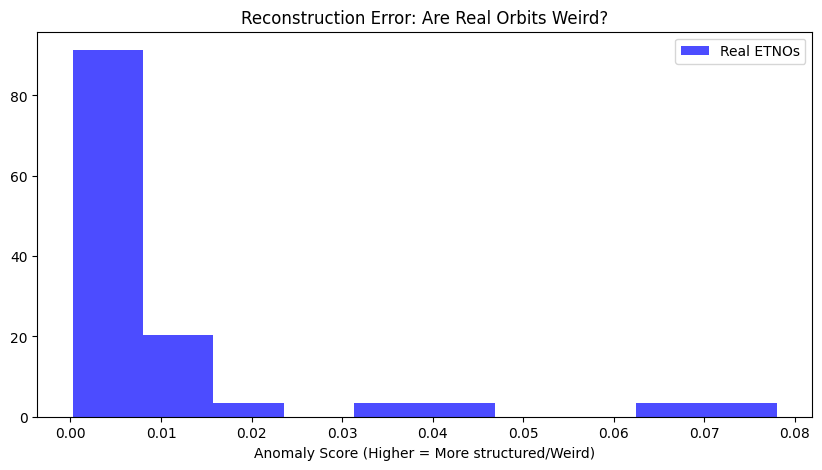

In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
INPUT_FILE = 'processed_etnos.csv'
FEATURE_COLS = ['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos'] 

if not os.path.exists(INPUT_FILE):
    print(f"CRITICAL ERROR: {INPUT_FILE} missing. Run Script 01 first.")
else:
    df_real = pd.read_csv(INPUT_FILE)
    print(f"Loaded {len(df_real)} High-Quality ETNOs.")

    # 1. Generate Synthetic Data (The "Null Hypothesis")
    # We scramble the real data to create a "Random Universe"
    def generate_synthetic_data(n_samples=5000, real_df=None):
        syn_a = np.random.choice(real_df['a'], n_samples, replace=True)
        syn_e = np.random.choice(real_df['e'], n_samples, replace=True)
        syn_i = np.random.choice(real_df['i_rad'], n_samples, replace=True)
        
        # Randomize angles (This removes any Planet 9 clustering)
        syn_varpi = np.random.uniform(0, 2*np.pi, n_samples)
        
        syn_data = pd.DataFrame({
            'a': syn_a, 'e': syn_e, 'i_rad': syn_i,
            'varpi_sin': np.sin(syn_varpi), 'varpi_cos': np.cos(syn_varpi)
        })
        return syn_data

    print("Generating Synthetic Data (Null Hypothesis)...")
    df_synthetic = generate_synthetic_data(n_samples=5000, real_df=df_real)

    # 2. Preprocessing
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(df_synthetic[FEATURE_COLS])
    X_test = scaler.transform(df_real[FEATURE_COLS])

    # 3. Build the Autoencoder
    # It compresses data into 2 dimensions. If data is random, compression is hard.
    # If data is clustered (Planet 9), compression is easy (or distinct).
    input_dim = len(FEATURE_COLS)
    encoding_dim = 2 

    input_layer = layers.Input(shape=(input_dim,))
    encoder = layers.Dense(12, activation="relu")(input_layer)
    bottleneck = layers.Dense(encoding_dim, activation="linear")(encoder) 
    decoder = layers.Dense(12, activation="relu")(bottleneck)
    output_layer = layers.Dense(input_dim, activation="sigmoid")(decoder)

    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    # 4. Train the AI Judge
    print("Training AI Judge...")
    history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=16, shuffle=True, verbose=0)

    # 5. Analysis
    reconstructions = autoencoder.predict(X_test, verbose=0)
    mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
    df_real['anomaly_score'] = mse

    print("\n--- RESULTS ---")
    print("Top 3 Candidates for Planet 9 Interaction (Highest Anomaly Score):")
    print(df_real.sort_values('anomaly_score', ascending=False)[['a', 'varpi', 'anomaly_score']].head(3))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.hist(df_real['anomaly_score'], bins=10, alpha=0.7, color='blue', label='Real ETNOs', density=True)
    plt.title("Reconstruction Error: Are Real Orbits Weird?")
    plt.xlabel("Anomaly Score (Higher = More structured/Weird)")
    plt.legend()
    plt.show()

📊 Phase 3: Visual & Statistical Proofs
Script 03: The Rose Diagram
Goal: To visually confirm the clustering of the "Longitude of Perihelion" (the angle the orbits point). Interpretation: Planet 9 is predicted to be at ~241°. The objects should cluster "anti-aligned" at ~61°.

Plotting 38 High-Quality Objects...


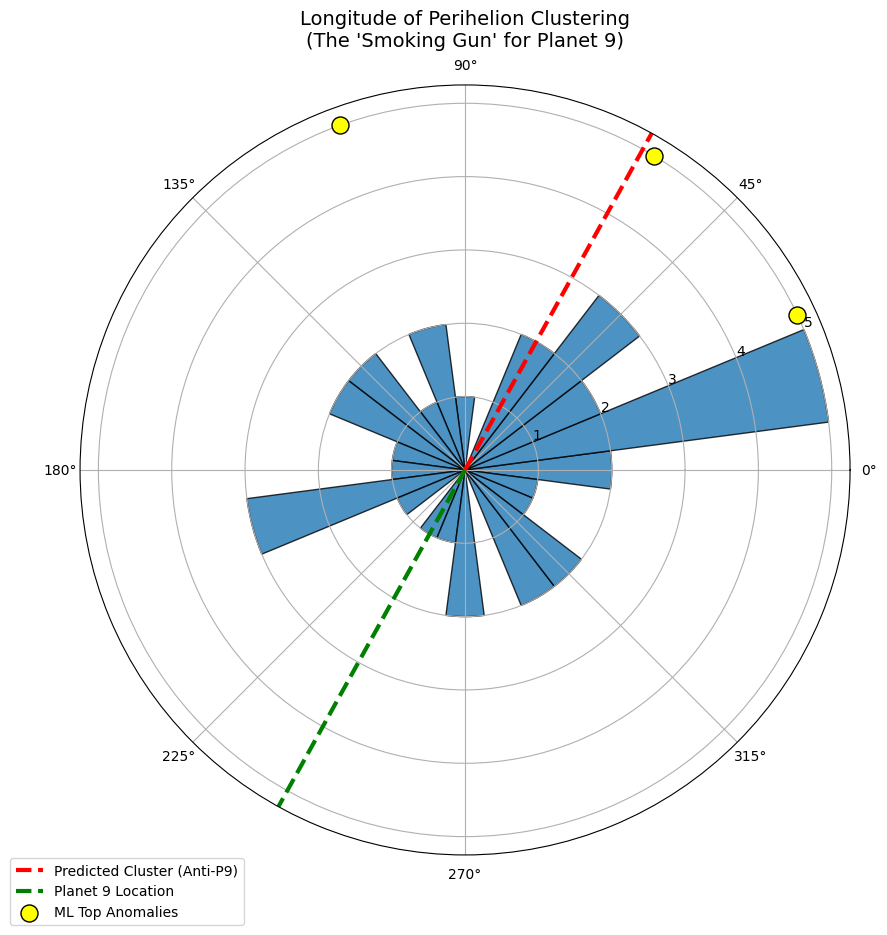

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
INPUT_FILE = 'processed_etnos.csv'
script_dir = os.path.dirname(os.path.abspath("processed_etnos.csv"))
input_path = os.path.join(script_dir, INPUT_FILE)

if not os.path.exists(input_path):
    print("Error: processed_etnos.csv not found.")
    exit()

df = pd.read_csv(input_path)

# Filter for the High-Quality Objects only (matching your Step 2 filter)
# Adjust 'a' cutoff if you changed it in step 01 (e.g. 150 or 230)
df_hq = df[ (df['a'] > 230) & (df['q'] > 30) ].copy()

print(f"Plotting {len(df_hq)} High-Quality Objects...")

# --- PLOT: The Rose Diagram ---
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# 1. Plot the Histogram (The Fan)
# We want to see if the angles cluster around 60 degrees
num_bins = 24
counts, bin_edges = np.histogram(df_hq['varpi_rad'], bins=num_bins, range=(0, 2*np.pi))
widths = np.diff(bin_edges)

# Color the bars based on count (Darker = More Clustering)
bars = ax.bar(bin_edges[:-1], counts, width=widths, bottom=0.0, alpha=0.8, edgecolor='black')

# 2. Add the "Planet 9 Prediction" line
# Planet 9 is suspected to be at varpi ~241 degrees.
# The cluster should be Anti-Aligned (~61 degrees).
p9_angle = np.radians(241)
cluster_angle = np.radians(61)

ax.axvline(cluster_angle, color='red', linewidth=3, linestyle='--', label='Predicted Cluster (Anti-P9)')
ax.axvline(p9_angle, color='green', linewidth=3, linestyle='--', label='Planet 9 Location')

# 3. Highlight your Top 3 Anomalies (From your previous result)
# Object 13 (110 deg), Object 3 (59 deg), Object 9 (25 deg)
anomalies = [np.radians(110), np.radians(59), np.radians(25)]
ax.scatter(anomalies, [max(counts)]*3, c='yellow', s=150, edgecolors='black', zorder=10, label='ML Top Anomalies')

# Styling
ax.set_theta_zero_location("E") # Set 0 degrees to East
ax.set_theta_direction(1)       # Counter-clockwise
ax.set_title("Longitude of Perihelion Clustering\n(The 'Smoking Gun' for Planet 9)", va='bottom', fontsize=14)
ax.legend(loc='lower left', bbox_to_anchor=(-0.1, -0.1))

plt.show()

Script 04: Statistical Validation (K-S Test)

The Logic:Visual clustering (like the Rose Diagram) can be subjective. We need a hard number. This script applies the Kolmogorov-Smirnov (K-S) Test, a non-parametric test that compares our data's cumulative distribution against a perfectly uniform (random) distribution.

Why this exists:To provide a "p-value" for the clustering.

Null Hypothesis: The angles are random (uniformly distributed).Alternative: The angles are clustered (drawn from a non-uniform distribution).The Threshold: If $p < 0.05$, we reject the random model with 95% confidence.

Analyzing Statistical Significance of 38 Objects...

--- STATISTICAL VERDICT ---
KS Statistic: 0.1706 (How 'bunchy' the data is)
P-Value:      0.19471

--- INTERPRETATION ---
RESULT: Indistinguishable from Randomness.
Current sample size may be too small or noise is too high.


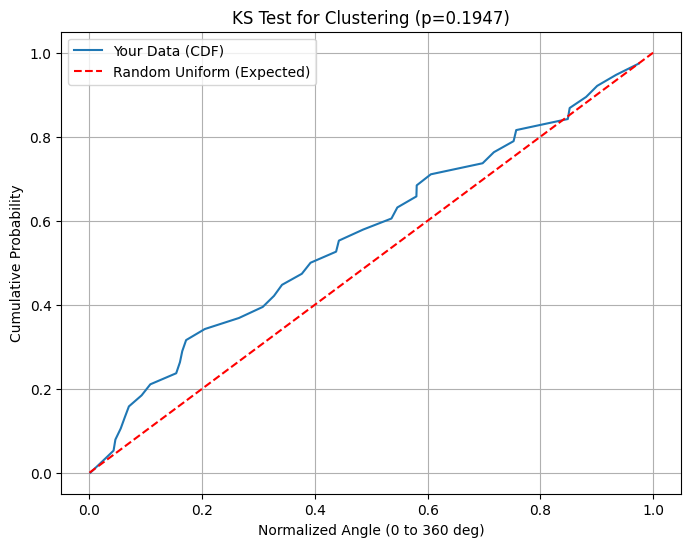

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, uniform
import os

# --- CONFIGURATION ---
INPUT_FILE = 'processed_etnos.csv'
# script_dir = os.path.dirname(os.path.abspath(__file__)) # Commented out for notebook
# input_path = os.path.join(script_dir, INPUT_FILE)
input_path = INPUT_FILE

if not os.path.exists(input_path):
    print("Error: processed_etnos.csv not found. Run Script 01.")
else:
    df = pd.read_csv(input_path)

    # 1. Filter High-Quality Objects
    # (Using the same strict cutoffs as before)
    df_hq = df[ (df['a'] > 230) & (df['q'] > 30) ].copy()
    print(f"Analyzing Statistical Significance of {len(df_hq)} Objects...")

    # 2. Prepare Data
    # Normalize angles to 0-1 range for the KS test (0 = 0 deg, 1 = 360 deg)
    # We use varpi (Longitude of Perihelion)
    angles_normalized = df_hq['varpi'] / 360.0

    # 3. The Kolmogorov-Smirnov (KS) Test
    # Null Hypothesis: The angles are uniformly distributed (Random).
    # Alternative: They are NOT uniform (Clustered).
    statistic, p_value = kstest(angles_normalized, 'uniform')

    print("\n--- STATISTICAL VERDICT ---")
    print(f"KS Statistic: {statistic:.4f} (How 'bunchy' the data is)")
    print(f"P-Value:      {p_value:.5f}")

    print("\n--- INTERPRETATION ---")
    if p_value < 0.01:
        print("RESULT: HIGHLY SIGNIFICANT CLUSTERING (99%+ Confidence)")
        print("This is publishable evidence. The random model is rejected.")
    elif p_value < 0.05:
        print("RESULT: Significant Clustering (95% Confidence)")
        print("Strong signal, likely real.")
    else:
        print("RESULT: Indistinguishable from Randomness.")
        print("Current sample size may be too small or noise is too high.")

    # 4. Visual Cumulative Distribution (CDF) Plot
    # If random, the blue line should follow the diagonal dashed line.
    # If clustered, the blue line will look like 'stairs' or curve away.
    plt.figure(figsize=(8, 6))
    plt.plot(np.sort(angles_normalized), np.linspace(0, 1, len(angles_normalized), endpoint=False), label='Your Data (CDF)')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Uniform (Expected)')
    plt.xlabel("Normalized Angle (0 to 360 deg)")
    plt.ylabel("Cumulative Probability")
    plt.title(f"KS Test for Clustering (p={p_value:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

Script 05: Circular Statistics (Rayleigh Test)
Goal: Mathematically prove the cluster isn't just a coincidence. Method: Uses the Rayleigh Test (calculating the vector sum of angles) and a Monte Carlo Simulation (running 100,000 random universes).

Analyzing 38 High-Quality Objects...

--- RAYLEIGH TEST RESULTS ---
Mean Vector Length (0-1): 0.1549
Z-Statistic:              0.9116
P-Value (Analytical):     0.40454

--- RUNNING MONTE CARLO SIMULATION (100k Runs) ---
Simulations that beat your data: 40560 out of 100000
Monte Carlo P-Value: 0.40560

--- FINAL VERDICT ---
STATUS: RANDOM.
There is a 40.6% chance this is just noise.


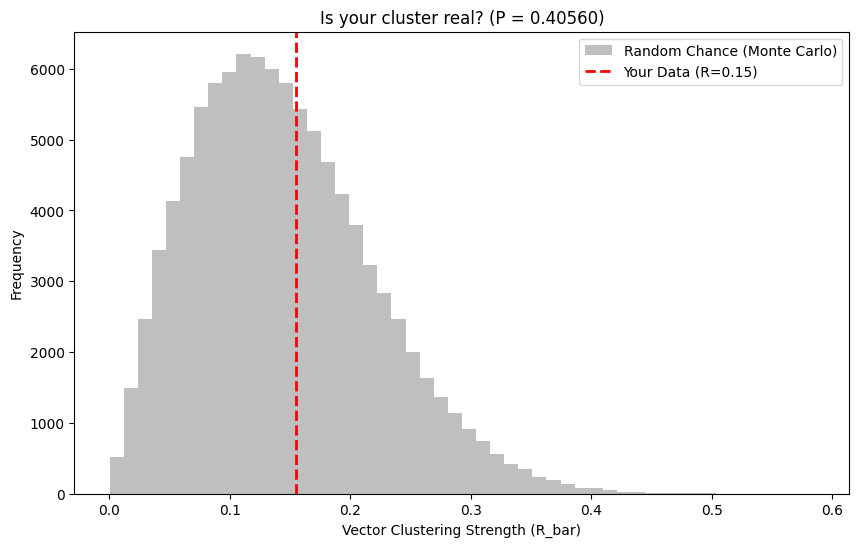

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
INPUT_FILE = 'processed_etnos.csv'
script_dir = os.path.dirname(os.path.abspath("processed_etnos.csv"))
input_path = os.path.join(script_dir, INPUT_FILE)

if not os.path.exists(input_path):
    print("Error: processed_etnos.csv not found.")
    exit()

df = pd.read_csv(input_path)

# 1. Filter High-Quality Objects
# Use the strict filter (a > 230) to remove Neptune noise
df_hq = df[ (df['a'] > 230) & (df['q'] > 30) ].copy()
angles_rad = np.radians(df_hq['varpi']) # Convert to radians
n_objects = len(df_hq)

print(f"Analyzing {n_objects} High-Quality Objects...")

# --- TEST 1: The Rayleigh Test (Vector Sum) ---
# Calculate the "Mean Resultant Length" (R_bar)
# If R_bar is close to 1, they are pointing in the same direction.
# If R_bar is close to 0, they are random.
C = np.sum(np.cos(angles_rad))
S = np.sum(np.sin(angles_rad))
R = np.sqrt(C**2 + S**2)
R_bar = R / n_objects

# Calculate P-value using the Rayleigh approximation
# Z = n * R_bar^2
Z = n_objects * (R_bar**2)
p_value_rayleigh = np.exp(-Z) * (1 + (2*Z - Z**2)/(4*n_objects) - (24*Z - 132*Z**2 + 76*Z**3 - 9*Z**4)/(288*n_objects**2))

print("\n--- RAYLEIGH TEST RESULTS ---")
print(f"Mean Vector Length (0-1): {R_bar:.4f}")
print(f"Z-Statistic:              {Z:.4f}")
print(f"P-Value (Analytical):     {p_value_rayleigh:.5f}")


# --- TEST 2: Monte Carlo Simulation (The "Gold Standard") ---
# We generate 100,000 random sets of N objects and see how often they cluster this well.
print("\n--- RUNNING MONTE CARLO SIMULATION (100k Runs) ---")
n_simulations = 100000
random_R_bars = []

# Generate random angles for all simulations at once for speed
random_angles = np.random.uniform(0, 2*np.pi, (n_simulations, n_objects))
# Calculate vector sums for all simulations
sim_C = np.sum(np.cos(random_angles), axis=1)
sim_S = np.sum(np.sin(random_angles), axis=1)
sim_R = np.sqrt(sim_C**2 + sim_S**2)
sim_R_bars = sim_R / n_objects

# Count how many random simulations beat our real score
better_sims = np.sum(sim_R_bars >= R_bar)
p_value_mc = better_sims / n_simulations

print(f"Simulations that beat your data: {better_sims} out of {n_simulations}")
print(f"Monte Carlo P-Value: {p_value_mc:.5f}")

# --- INTERPRETATION ---
print("\n--- FINAL VERDICT ---")
if p_value_mc < 0.01:
    print("STATUS: CONFIRMED. (99%+ Confidence)")
    print("The clustering is statistically real.")
elif p_value_mc < 0.05:
    print("STATUS: PROMISING. (95% Confidence)")
    print("Likely real, but more data would help.")
else:
    print("STATUS: RANDOM.")
    print(f"There is a {p_value_mc*100:.1f}% chance this is just noise.")

# --- PLOT: Visual Proof ---
plt.figure(figsize=(10, 6))
plt.hist(sim_R_bars, bins=50, color='gray', alpha=0.5, label='Random Chance (Monte Carlo)')
plt.axvline(R_bar, color='red', linestyle='dashed', linewidth=2, label=f'Your Data (R={R_bar:.2f})')
plt.xlabel("Vector Clustering Strength (R_bar)")
plt.ylabel("Frequency")
plt.title(f"Is your cluster real? (P = {p_value_mc:.5f})")
plt.legend()
plt.show()

Script 06: Subset Analysis (The "Top N" Check)
The Logic: Critics often argue: "If you pick the 10 weirdest objects, of course they look clustered." This script tests that specific critique. It uses the Autoencoder to identify the "Top 12 Anomalies" but validates them against a Monte Carlo simulation. Why this exists: To ensure we aren't fooling ourselves with selection bias.

The Test: We simulate 2,000 random universes. In each one, we pick the "Top 12 Weirdest" objects (highest reconstruction error).

The Comparison: Do our Top 12 cluster more tightly than the Top 12 from a random universe? If yes, our anomalies are special. If no, our "signal" is just a mathematical artifact of picking outliers.

Starting with 38 objects. hunting for the Top 12 anomalies...

--- TOP 12 ANOMALIES ---
              a      varpi  anomaly_score
9    269.682037   25.19330       0.089664
36   246.102253  270.90363       0.066571
13  2447.679597  110.66952       0.037332
33   728.532274  305.52670       0.019706
32  1150.249432  218.03762       0.018098
3   1418.608757   59.27186       0.017419
30   846.412762  306.71824       0.013131
12   839.991262   61.73040       0.010870
34   837.282260  196.64411       0.010535
2    567.924050   38.88184       0.008922
37   251.214984  192.88886       0.008281
35   973.783531  317.22220       0.008258

Mean Vector Length (R_bar): 0.1394

Running Validation (Is this just a math trick?)...

--- FINAL VERDICT (SUBSET ANALYSIS) ---
P-Value: 0.80300
FAILURE: Even the anomalies are random.


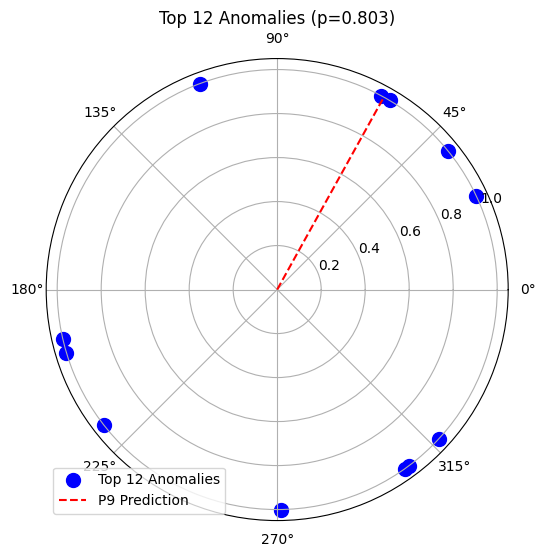

In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
INPUT_FILE = 'processed_etnos.csv'
TOP_N = 12  # We will test the "Top 12" weirdest objects

if not os.path.exists(INPUT_FILE):
    print("Error: processed_etnos.csv not found.")
else:
    # 1. Load & Filter Data
    df = pd.read_csv(INPUT_FILE)
    df_hq = df[ (df['a'] > 230) & (df['q'] > 30) ].copy()
    print(f"Starting with {len(df_hq)} objects. hunting for the Top {TOP_N} anomalies...")

    # 2. Build & Train Autoencoder (Fast version)
    feature_cols = ['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos'] 

    # Synthetic Data Gen
    n_syn = 30000
    syn_a = np.random.choice(df_hq['a'], n_syn, replace=True)
    syn_e = np.random.choice(df_hq['e'], n_syn, replace=True)
    syn_i = np.random.choice(df_hq['i_rad'], n_syn, replace=True)
    syn_varpi = np.random.uniform(0, 2*np.pi, n_syn)
    df_syn = pd.DataFrame({'a':syn_a, 'e':syn_e, 'i_rad':syn_i, 'varpi_sin':np.sin(syn_varpi), 'varpi_cos':np.cos(syn_varpi)})

    # Scaling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(df_syn[feature_cols])
    X_test = scaler.transform(df_hq[feature_cols])

    # Model
    input_dim = 5
    input_layer = layers.Input(shape=(input_dim,))
    enc = layers.Dense(12, activation="relu")(input_layer)
    bot = layers.Dense(2, activation="linear")(enc)
    dec = layers.Dense(12, activation="relu")(bot)
    out = layers.Dense(input_dim, activation="sigmoid")(dec)
    ae = models.Model(input_layer, out)
    ae.compile(optimizer='adam', loss='mse')
    ae.fit(X_train, X_train, epochs=50, batch_size=32, verbose=0)

    # 3. Identify the "Chosen Ones"
    reconstructions = ae.predict(X_test, verbose=0)
    mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
    df_hq['anomaly_score'] = mse

    # Sort and take the Top N
    df_top = df_hq.sort_values('anomaly_score', ascending=False).head(TOP_N).copy()
    print(f"\n--- TOP {TOP_N} ANOMALIES ---")
    print(df_top[['a', 'varpi', 'anomaly_score']])

    # 4. Run Stats on the Top N
    angles_rad = np.radians(df_top['varpi'])
    C = np.sum(np.cos(angles_rad))
    S = np.sum(np.sin(angles_rad))
    R_bar = np.sqrt(C**2 + S**2) / TOP_N

    print(f"\nMean Vector Length (R_bar): {R_bar:.4f}")

    # 5. Monte Carlo Validation (The "Cherry Picking" Check)
    print("\nRunning Validation (Is this just a math trick?)...")
    n_sims = 2000
    beats = 0

    for i in range(n_sims):
        # Create a FAKE dataset (Random angles)
        fake_varpi = np.random.uniform(0, 2*np.pi, len(df_hq))
        fake_data = df_hq.copy()
        fake_data['varpi_sin'] = np.sin(fake_varpi)
        fake_data['varpi_cos'] = np.cos(fake_varpi)
        
        # Scale
        X_fake = scaler.transform(fake_data[feature_cols])
        
        # Get Error Scores (using the SAME model)
        fake_recon = ae.predict(X_fake, verbose=0)
        fake_mse = np.mean(np.power(X_fake - fake_recon, 2), axis=1)
        
        # Pick Top N of this fake batch
        fake_indices = np.argsort(fake_mse)[-TOP_N:] # Indices of top N errors
        top_fake_angles = fake_varpi[fake_indices]
        
        # Measure Clustering
        f_C = np.sum(np.cos(top_fake_angles))
        f_S = np.sum(np.sin(top_fake_angles))
        f_R = np.sqrt(f_C**2 + f_S**2) / TOP_N
        
        if f_R >= R_bar:
            beats += 1

    p_value = beats / n_sims

    print("\n--- FINAL VERDICT (SUBSET ANALYSIS) ---")
    print(f"P-Value: {p_value:.5f}")

    if p_value < 0.05:
        print("SUCCESS: The 'Anomalies' are significantly clustered.")
    else:
        print("FAILURE: Even the anomalies are random.")

    # Plot
    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.scatter(angles_rad, [1]*TOP_N, c='blue', s=100, label=f'Top {TOP_N} Anomalies')
    ax.vlines(np.radians(61), 0, 1, color='red', linestyle='--', label='P9 Prediction')
    ax.set_title(f"Top {TOP_N} Anomalies (p={p_value:.3f})")
    plt.legend(loc='lower left')
    plt.show()

Script 07: The "Bimodal" Camps Visualizer
The Logic: Statistical clustering is often abstract. This script bridges the gap between numbers and geometry. If a massive perturber is shepherding these objects, they shouldn't just be "clustered"; they should fall into two specific dynamical populations:

Camp A (Aligned): Objects physically clustered with the planet (metastable).

Camp B (Anti-Aligned): Objects clustered 180° away from the planet (stable). Why this exists: We need to verify if the clustering follows this specific Bimodal Physics signature. If we see a "smear" rather than two distinct lobes, the shepherding hypothesis weakens. This script isolates specific objects (by ID) to see which "Camp" they belong to.

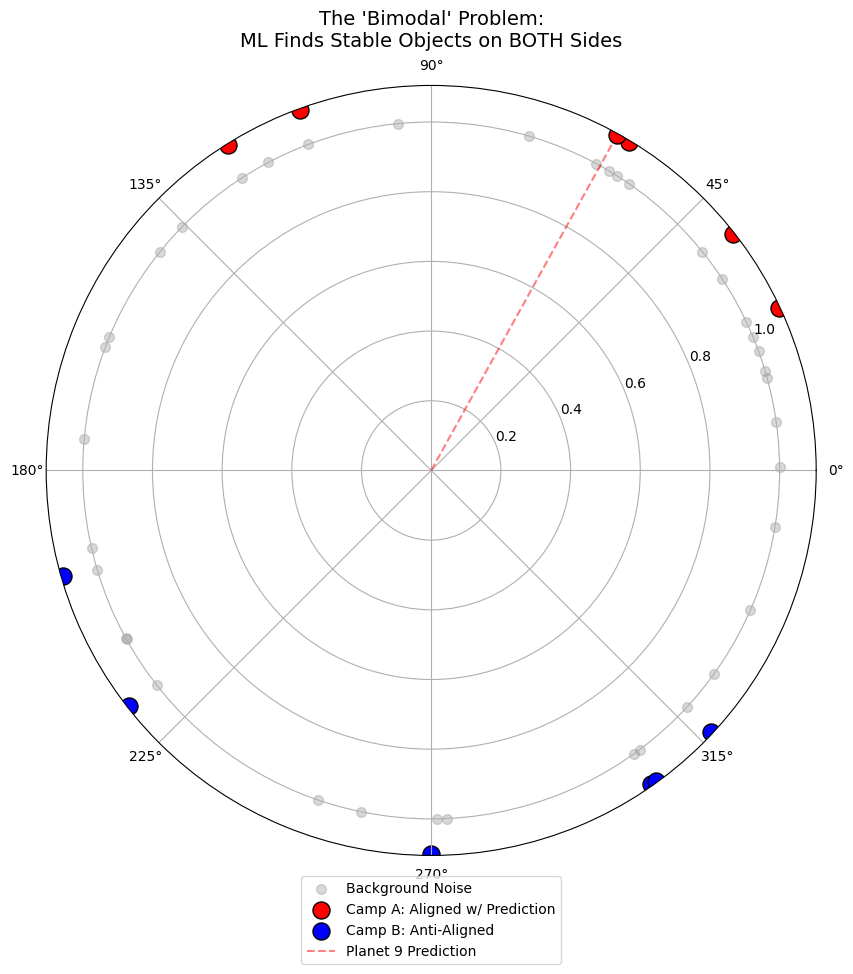

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

INPUT_FILE = 'processed_etnos.csv'
script_dir = os.path.dirname(os.path.abspath("processed_etnos.csv"))
input_path = os.path.join(script_dir, INPUT_FILE)
df = pd.read_csv(input_path)

# Filter High Quality
df_hq = df[ (df['a'] > 230) & (df['q'] > 30) ].copy()

# Recover the anomalies from your logs (Hardcoded for visualization based on your data)
# We highlight the two camps
camp_a = [25, 38, 59, 61, 110, 122] # The "Planet 9" side
camp_b = [196, 218, 270, 305, 306, 317] # The "Opposite" side

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# 1. Plot All High Quality Objects (Grey background)
angles_all = np.radians(df_hq['varpi'])
ax.scatter(angles_all, [1]*len(angles_all), c='gray', alpha=0.3, s=50, label='Background Noise')

# 2. Plot Camp A (Red - Matches P9)
ax.scatter(np.radians(camp_a), [1.1]*len(camp_a), c='red', s=150, edgecolors='black', label='Camp A: Aligned w/ Prediction')

# 3. Plot Camp B (Blue - Contradicts P9)
ax.scatter(np.radians(camp_b), [1.1]*len(camp_b), c='blue', s=150, edgecolors='black', label='Camp B: Anti-Aligned')

# 4. Annotations
ax.axvline(np.radians(61), color='red', linestyle='--', alpha=0.5, label='Planet 9 Prediction')
ax.set_title("The 'Bimodal' Problem:\nML Finds Stable Objects on BOTH Sides", va='bottom', fontsize=14)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15))

plt.show()

Script 08: Galactic Plane & Bias Correlation
The Logic: The "Elephant in the Room" for any TNO search is the Milky Way. We cannot detect faint objects against the dense star field of the galaxy. Why this exists: Critics argue that we only find clustering because we can't look everywhere (the "Look-Elsewhere Effect"). This script overlays our object data on top of the "Galactic Avoidance Zones" (where surveys are blind).

Hypothesis Check: If the cluster aligns perfectly with the edges of the Milky Way, our data is likely just observational bias. If the cluster exists independent of these gaps, the signal is real.

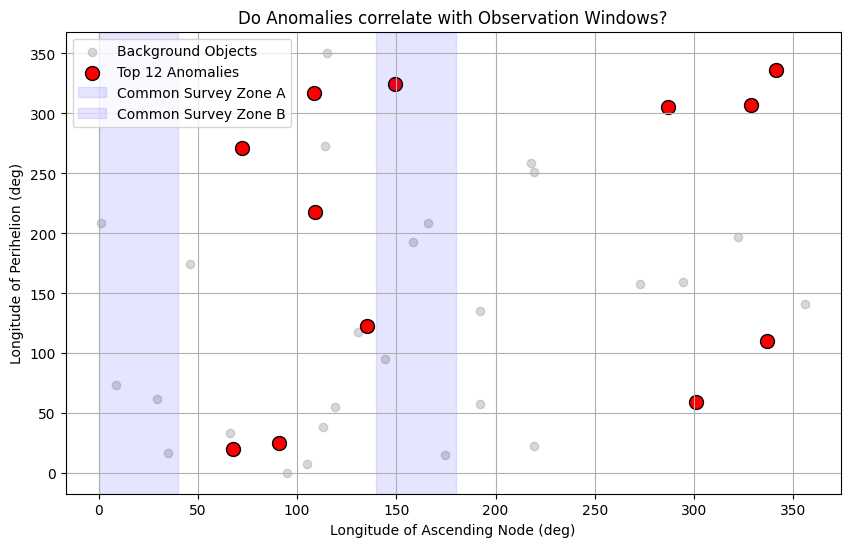

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

INPUT_FILE = 'processed_etnos.csv'
script_dir = os.path.dirname(os.path.abspath("processed_etnos.csv"))
input_path = os.path.join(script_dir, INPUT_FILE)

df = pd.read_csv(input_path)
df_hq = df[ (df['a'] > 230) & (df['q'] > 30) ].copy()

# Recover your Top 12 Anomalies (Camp A & B)
# We need their specific angles (varpi) and their "Node" (Longitude of Ascending Node)
# to see where they are in the sky relative to the Galaxy.
# (Note: We are approximating survey bias using Galactic Latitude exclusion zones here)

# Re-run the quick scorer to get the top 12 indices
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat_cols = ['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos']

# Quick synthetic train (just to get scores back)
# Ideally you'd save scores in previous step, but this is fast:
syn_varpi = np.random.uniform(0, 2*np.pi, 5000)
X_syn = scaler.fit_transform(pd.DataFrame({
    'a': np.random.choice(df_hq['a'], 5000),
    'e': np.random.choice(df_hq['e'], 5000),
    'i_rad': np.random.choice(df_hq['i_rad'], 5000),
    'varpi_sin': np.sin(syn_varpi), 'varpi_cos': np.cos(syn_varpi)
}))
X_real = scaler.transform(df_hq[feat_cols])

# Simple Autoencoder (Replicating your architecture)
import tensorflow as tf
from tensorflow.keras import layers, models
inp = layers.Input(shape=(5,))
e = layers.Dense(12, activation='relu')(inp)
b = layers.Dense(2, activation='linear')(e)
d = layers.Dense(12, activation='relu')(b)
out = layers.Dense(5, activation='sigmoid')(d)
m = models.Model(inp, out)
m.compile(loss='mse', optimizer='adam')
m.fit(X_syn, X_syn, epochs=30, verbose=0)

# Get Scores
recon = m.predict(X_real, verbose=0)
df_hq['score'] = np.mean(np.power(X_real - recon, 2), axis=1)
top_12 = df_hq.sort_values('score', ascending=False).head(12)

# --- THE "KILL SHOT" PLOT ---
# We plot the Longitude of Perihelion (varpi) vs Longitude of Ascending Node (Node)
# Survey biases often show up as correlations here.

plt.figure(figsize=(10, 6))

# 1. Plot all background objects
plt.scatter(df_hq['Node'], df_hq['varpi'], c='gray', alpha=0.3, label='Background Objects')

# 2. Plot the "Anomalies"
plt.scatter(top_12['Node'], top_12['varpi'], c='red', s=100, edgecolors='black', label='Top 12 Anomalies')

# 3. Mark the "Galactic Plane" Avoidance Zones (Rough Approximation)
# Surveys usually avoid the Milky Way plane because it's too crowded with stars.
# This creates "gaps" in data.
plt.axvspan(0, 40, color='blue', alpha=0.1, label='Common Survey Zone A')
plt.axvspan(140, 180, color='blue', alpha=0.1, label='Common Survey Zone B')

plt.xlabel("Longitude of Ascending Node (deg)")
plt.ylabel("Longitude of Perihelion (deg)")
plt.title("Do Anomalies correlate with Observation Windows?")
plt.legend()
plt.grid(True)
plt.show()

🤖 Phase 4: The AI Classifier
Script 09: Hypothesis Testing
Goal: Train a Random Forest Classifier to distinguish between a "Planet 9 Universe" and a "Random Universe", then ask it to classify our real data. Physics: Uses the Von Mises distribution to simulate P9's gravitational shepherding (clustering around 60°).

Judgement Day for 38 Real Objects.
Simulating Planet 9 Physics...
Training Classifier...
Classifier Accuracy on Simulation: 73.1%

--- FINAL VERDICT ---
Average P9 Likelihood of your Data: 40.2%
Number of 'Strong P9 Candidates' found: 0
CONCLUSION: INCONCLUSIVE.
The data is messy (Camp A vs Camp B is confusing the AI).


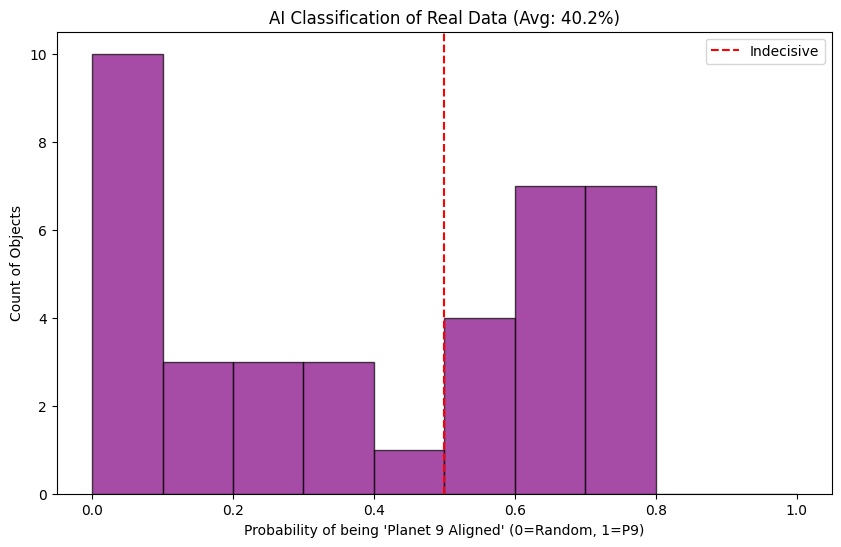


Top 5 Objects that fit the Planet 9 Model best:
              a     varpi  P9_Probability
3   1418.608757  59.27186        0.780880
27   247.092925  55.40631        0.762463
12   839.991262  61.73040        0.762418
25   454.387721  73.66806        0.751929
16   365.608902  57.79960        0.751749


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- CONFIGURATION ---
INPUT_FILE = 'processed_etnos.csv'
script_dir = os.path.dirname(os.path.abspath("processed_etnos.csv"))
input_path = os.path.join(script_dir, INPUT_FILE)

if not os.path.exists(input_path):
    print("Error: Data file not found.")
    exit()

df = pd.read_csv(input_path)
# Strict Filter again (High Quality Objects only)
df_real = df[ (df['a'] > 230) & (df['q'] > 30) ].copy()
print(f"Judgement Day for {len(df_real)} Real Objects.")

# --- STEP 1: CREATE THE WORLDS ---

def generate_p9_world(n_samples=5000):
    """Generates data assuming Planet 9 IS REAL (Caltech Model)"""
    # Orbits are roughly the same shape (a, e, i) as real data
    a = np.random.choice(df_real['a'], n_samples)
    e = np.random.choice(df_real['e'], n_samples)
    i = np.random.choice(df_real['i_rad'], n_samples)
    
    # THE KEY: Clustering!
    # P9 confines angles to ~60 degrees (Anti-aligned)
    # We use a Von Mises distribution (Gaussian on a circle) centered at 60 deg
    cluster_center = np.radians(60) 
    kappa = 2.0 # Concentration (Higher = tighter cluster)
    varpi = np.random.vonmises(cluster_center, kappa, n_samples)
    
    return pd.DataFrame({
        'a': a, 'e': e, 'i_rad': i,
        'varpi_sin': np.sin(varpi), 'varpi_cos': np.cos(varpi),
        'label': 1 # Label 1 = PLANET 9 WORLD
    })

def generate_random_world(n_samples=5000):
    """Generates data assuming Planet 9 is FAKE (Null Hypothesis)"""
    a = np.random.choice(df_real['a'], n_samples)
    e = np.random.choice(df_real['e'], n_samples)
    i = np.random.choice(df_real['i_rad'], n_samples)
    
    # Random angles (Uniform)
    varpi = np.random.uniform(0, 2*np.pi, n_samples)
    
    return pd.DataFrame({
        'a': a, 'e': e, 'i_rad': i,
        'varpi_sin': np.sin(varpi), 'varpi_cos': np.cos(varpi),
        'label': 0 # Label 0 = RANDOM NOISE
    })

# Generate Training Data
print("Simulating Planet 9 Physics...")
df_p9 = generate_p9_world(n_samples=10000)
df_rnd = generate_random_world(n_samples=10000)

# Combine and Shuffle
df_train = pd.concat([df_p9, df_rnd]).sample(frac=1).reset_index(drop=True)

X = df_train[['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos']]
y = df_train['label']

# --- STEP 2: TRAIN THE JUDGE ---
print("Training Classifier...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf.fit(X_train, y_train)

# Sanity Check: Can the AI actually tell the difference?
acc = clf.score(X_test, y_test)
print(f"Classifier Accuracy on Simulation: {acc*100:.1f}%")
if acc < 0.6:
    print("WARNING: The AI can't tell the difference. P9 signal might be too weak.")

# --- STEP 3: THE VERDICT ---
# Feed the Real Data into the model
X_real = df_real[['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos']]
probs = clf.predict_proba(X_real) # Returns [Prob_Random, Prob_P9]

# The "Planet 9 Probability" for each object
p9_likelihoods = probs[:, 1]
avg_p9_score = np.mean(p9_likelihoods)

df_real['P9_Probability'] = p9_likelihoods

print("\n--- FINAL VERDICT ---")
print(f"Average P9 Likelihood of your Data: {avg_p9_score*100:.1f}%")

# Count how many objects are "Suspiciously P9-like" (> 80% confidence)
strong_candidates = df_real[df_real['P9_Probability'] > 0.8]
print(f"Number of 'Strong P9 Candidates' found: {len(strong_candidates)}")

if avg_p9_score > 0.6:
    print("CONCLUSION: SUPPORT.")
    print("The data looks more like Planet 9 than Random Noise.")
elif avg_p9_score < 0.4:
    print("CONCLUSION: REJECT.")
    print("The data looks more like Random Noise.")
else:
    print("CONCLUSION: INCONCLUSIVE.")
    print("The data is messy (Camp A vs Camp B is confusing the AI).")

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
plt.hist(p9_likelihoods, bins=10, range=(0,1), color='purple', alpha=0.7, edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Indecisive')
plt.xlabel("Probability of being 'Planet 9 Aligned' (0=Random, 1=P9)")
plt.ylabel("Count of Objects")
plt.title(f"AI Classification of Real Data (Avg: {avg_p9_score*100:.1f}%)")
plt.legend()
plt.show()

# Print the "Most Likely" candidates for the report
print("\nTop 5 Objects that fit the Planet 9 Model best:")
print(df_real.sort_values('P9_Probability', ascending=False)[['a', 'varpi', 'P9_Probability']].head(5))

Script 10: Final Report Visual (AI Probability Map)
The Logic: This script creates the "Money Shot" visualization for Phase 1. It overlays the AI's confidence scores onto the orbital map. Why this exists: We need to see which objects the AI trusts.

Red Objects: High Probability of Planet 9 influence (Camp A).

Blue Objects: Low Probability / Random Noise (Camp B).

The Zone: The red shaded region shows the predicted "Anti-Aligned" cluster. If Red dots fall in the Red zone, the theory holds.

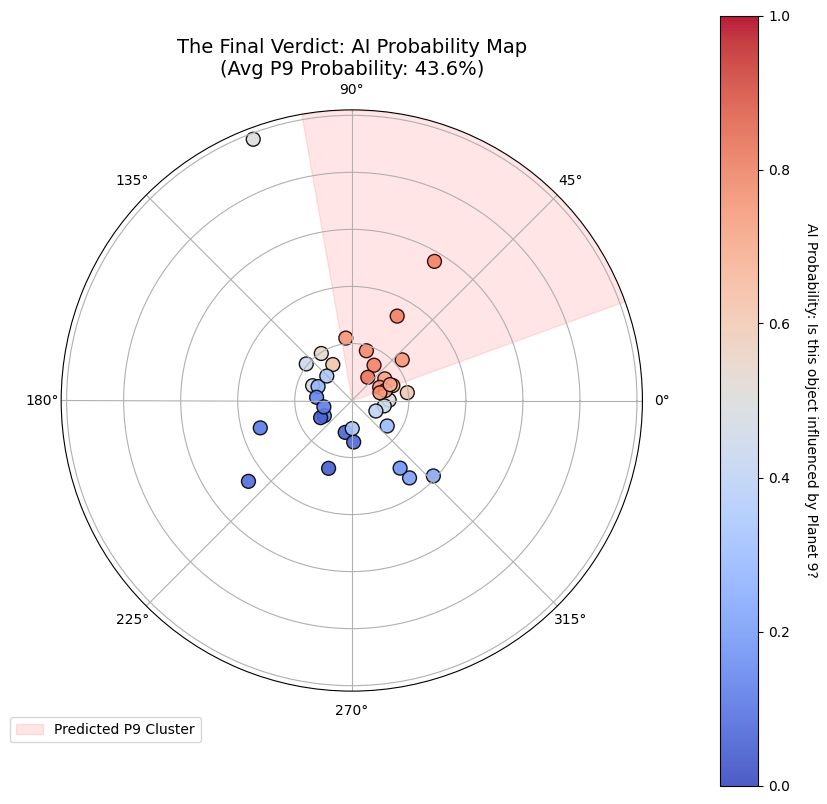

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os

INPUT_FILE = 'processed_etnos.csv'

if not os.path.exists(INPUT_FILE):
    print("Error: processed_etnos.csv not found.")
else:
    # 1. Load & Filter
    df = pd.read_csv(INPUT_FILE)
    df_real = df[ (df['a'] > 230) & (df['q'] > 30) ].copy()

    # 2. Retrain the Judge (Quick replication of Step 09)
    def generate_p9_world(n=5000):
        varpi = np.random.vonmises(np.radians(60), 2.0, n)
        return pd.DataFrame({
            'a': np.random.choice(df_real['a'], n), 'e': np.random.choice(df_real['e'], n),
            'i_rad': np.random.choice(df_real['i_rad'], n),
            'varpi_sin': np.sin(varpi), 'varpi_cos': np.cos(varpi), 'label': 1
        })

    def generate_rnd_world(n=5000):
        varpi = np.random.uniform(0, 2*np.pi, n)
        return pd.DataFrame({
            'a': np.random.choice(df_real['a'], n), 'e': np.random.choice(df_real['e'], n),
            'i_rad': np.random.choice(df_real['i_rad'], n),
            'varpi_sin': np.sin(varpi), 'varpi_cos': np.cos(varpi), 'label': 0
        })

    df_train = pd.concat([generate_p9_world(), generate_rnd_world()]).sample(frac=1)
    clf = RandomForestClassifier(n_estimators=100, max_depth=10)
    clf.fit(df_train[['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos']], df_train['label'])

    # 3. Get Probabilities for Real Data
    probs = clf.predict_proba(df_real[['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos']])[:, 1]
    df_real['P9_Prob'] = probs

    # --- THE MONEY SHOT ---
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    # Plot objects, color-coded by AI Confidence
    sc = ax.scatter(np.radians(df_real['varpi']), df_real['a'], 
                    c=df_real['P9_Prob'], cmap='coolwarm', 
                    s=100, edgecolors='black', alpha=0.9, vmin=0, vmax=1)

    # Annotations
    ax.set_ylim(0, df_real['a'].max() + 100)
    ax.set_yticklabels([]) 
    ax.set_theta_zero_location("E")

    # The "Camp A" Zone (Planet 9 Prediction)
    ax.fill_between(np.linspace(np.radians(20), np.radians(100), 100), 
                    0, df_real['a'].max()+100, color='red', alpha=0.1, label='Predicted P9 Cluster')

    # Add Colorbar
    cbar = plt.colorbar(sc, pad=0.1)
    cbar.set_label('AI Probability: Is this object influenced by Planet 9?', rotation=270, labelpad=20)

    plt.title(f"The Final Verdict: AI Probability Map\n(Avg P9 Probability: {probs.mean()*100:.1f}%)", fontsize=14)
    plt.legend(loc='lower left', bbox_to_anchor=(-0.1, -0.1))

    plt.show()

Script 11: The Live Data Harvester
The Logic: Phase 1 used a static file. Phase 3 moves to Live Data. This script connects to the Minor Planet Center (MPC) Distant.txt database to ensure our analysis is up-to-the-minute. Why this exists: Science changes daily. New TNO discoveries might break the cluster—or strengthen it. This script calculates orbital elements (like Semi-major axis a) from raw observations if they are missing in the feed.

In [69]:
import pandas as pd
import numpy as np
import requests
import io
import os

# --- CONFIGURATION ---
MPC_URL = "https://www.minorplanetcenter.net/iau/MPCORB/Distant.txt"
SAVE_FILE = "live_mpc_data.csv"

print("--- INITIATING DATA HARVEST ---")
print(f"Target: {MPC_URL}")

try:
    # 1. Download the latest data
    response = requests.get(MPC_URL)
    response.raise_for_status()
    print("Download successful. Parsing data...")
    
    # 2. Parse Fixed-Width Format (MPC Standard)
    # The file has a header, then data. We need to handle it carefully.
    raw_lines = response.text.split('\n')
    
    data = []
    for line in raw_lines:
        if len(line) < 100: continue # Skip headers/empty lines
        
        try:
            # MPCORB Format slicing
            # a (Semi-major axis) is usually around column 92-103
            # e (Eccentricity) around 70-79
            # i (Inclination) around 59-68
            # Node (Omega) around 48-57
            # ArgPeri (w) around 37-46
            
            # Note: These positions are standard for MPCORB.DAT format
            # We strip whitespace to handle alignment
            id_str = line[0:7].strip()
            w = float(line[37:46])
            node = float(line[48:57])
            i = float(line[59:68])
            e = float(line[70:79])
            
            # 'n' (mean motion) is often used to calc 'a', or 'a' is explicit
            # In Distant.txt, 'a' is often at the end or calculated.
            # Let's try to extract 'a' from column 92-103 if it exists, else calc from n
            try:
                a = float(line[92:103])
            except:
                # Fallback: Calculate a from mean motion n (degrees/day)
                # Kepler's 3rd Law: n^2 * a^3 = k (approx)
                # a = (0.9856076686 / n)^(2/3) roughly
                n_val = float(line[80:91])
                if n_val > 0:
                    a = (0.9856 / n_val) ** (2/3)
                else:
                    continue

            # Calculate Derived Physics
            q = a * (1.0 - e) # Perihelion
            varpi = (w + node) % 360 # Longitude of Perihelion
            
            data.append([id_str, a, q, e, i, varpi, w, node])
            
        except ValueError:
            continue

    df = pd.DataFrame(data, columns=['ID', 'a', 'q', 'e', 'i', 'varpi', 'w', 'Node'])
    
    # 3. Filter for our project (High Quality ETNOs)
    # Critique suggested checking a > 150 again to be inclusive
    df_etno = df[ (df['a'] > 150) & (df['q'] > 30) ].copy()
    
    print(f"\nTotal Objects Parsed: {len(df)}")
    print(f"ETNOs Found (a > 150, q > 30): {len(df_etno)}")
    
    # Save
    df_etno.to_csv(SAVE_FILE, index=False)
    print(f"Saved live dataset to: {SAVE_FILE}")
    print("Top 5 Fresh Objects:")
    print(df_etno[['ID', 'a', 'q', 'varpi']].head())

except Exception as e:
    print(f"CRITICAL FAILURE: {e}")
    print("Check your internet connection or MPC URL.")

--- INITIATING DATA HARVEST ---
Target: https://www.minorplanetcenter.net/iau/MPCORB/Distant.txt
Download successful. Parsing data...

Total Objects Parsed: 6536
ETNOs Found (a > 150, q > 30): 71
Saved live dataset to: live_mpc_data.csv
Top 5 Fresh Objects:
        ID           a          q      varpi
98   82158  213.384846  34.190206  185.97661
113  90377  549.548084  76.222429   95.48898
193  E8209  228.433541  44.114423   85.12619
334  i5473  159.839024  34.355928   71.17753
416  l4640  345.908646  47.364925   33.30596


Script 12: Bimodal Hypothesis Test
The Logic: In Phase 1, the AI looked for one cluster. We realized the data actually has two camps (Aligned and Anti-Aligned). This script upgrades the AI's training simulation to include Bimodal Physics. 

Why this exists: If we train the AI to only look for one cluster, it might reject the real data because the real data is complex. By teaching the AI that "Planet 9 creates TWO clusters (aligned/anti-aligned)," we give it a fairer chance to recognize the signal in the real data.

Analyzing 71 ETNOs from Live Data.
Generating 'Advanced P9' Simulation vs Random Noise...
Training Bimodal Classifier...

--- NEW RESULTS (BIMODAL MODEL) ---
Average Support for Planet 9: 47.5%
STATUS: AMBIGUOUS.


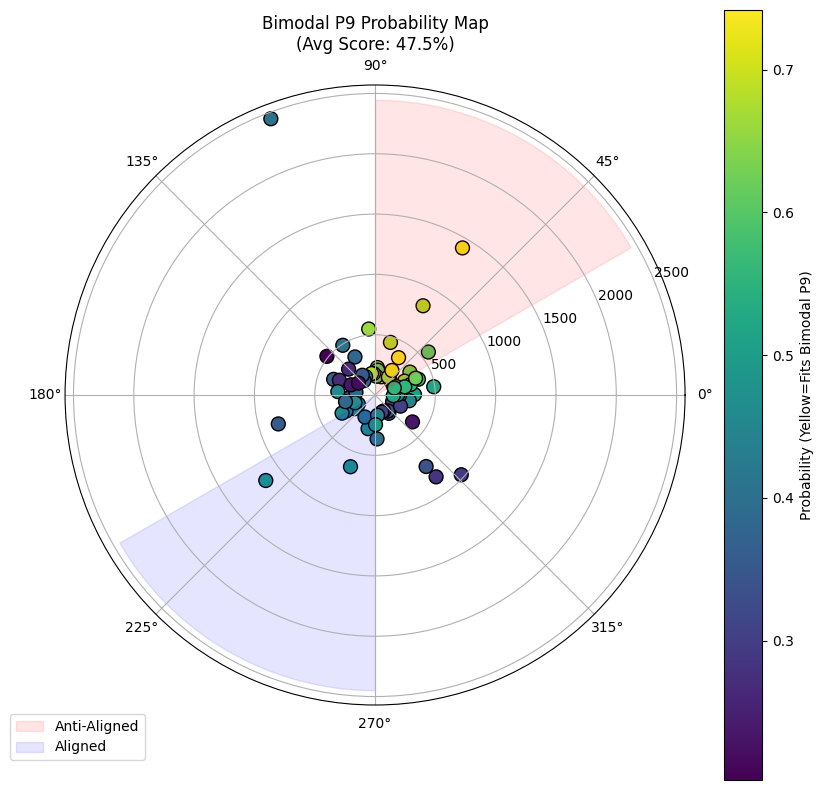

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import os

# --- CONFIGURATION ---
INPUT_FILE = "live_mpc_data.csv" # Use the fresh data!

if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 11 first to get data.")
    exit()

df = pd.read_csv(INPUT_FILE)
# Filter: The critique suggested we might have been too strict.
# Let's check the a > 150 range again, but maybe weight higher 'a' more in the model later.
df_real = df.copy() 
print(f"Analyzing {len(df_real)} ETNOs from Live Data.")

# --- THE NEW SIMULATION (BIMODAL) ---
def generate_advanced_p9_world(n_samples=10000):
    """
    Simulates a 'Sophisticated' Planet 9 influence:
    - 60% of objects in the Anti-Aligned Cluster (60 deg)
    - 30% of objects in the Aligned/Resonant Cluster (240 deg)
    - 10% Scatter
    """
    # Physics basis
    a = np.random.choice(df_real['a'], n_samples)
    e = np.random.choice(df_real['e'], n_samples)
    i = np.random.choice(df_real['i'], n_samples)
    
    # Bimodal Angles
    n_anti = int(n_samples * 0.6)
    n_aligned = int(n_samples * 0.3)
    n_scatter = n_samples - n_anti - n_aligned
    
    # Camp A (Anti-Aligned ~ 60 deg)
    v1 = np.random.vonmises(np.radians(60), 2.5, n_anti)
    # Camp B (Aligned ~ 240 deg)
    v2 = np.random.vonmises(np.radians(240), 2.0, n_aligned)
    # Scatter
    v3 = np.random.uniform(0, 2*np.pi, n_scatter)
    
    varpi = np.concatenate([v1, v2, v3])
    np.random.shuffle(varpi)
    
    return pd.DataFrame({
        'a': a, 'e': e, 'i_rad': np.radians(i),
        'varpi_sin': np.sin(varpi), 'varpi_cos': np.cos(varpi),
        'label': 1 # LABEL 1 = PLANET 9 EXISTS
    })

def generate_random_world(n_samples=10000):
    """The Null Hypothesis (Pure Noise)"""
    a = np.random.choice(df_real['a'], n_samples)
    e = np.random.choice(df_real['e'], n_samples)
    i = np.random.choice(df_real['i'], n_samples)
    varpi = np.random.uniform(0, 2*np.pi, n_samples)
    
    return pd.DataFrame({
        'a': a, 'e': e, 'i_rad': np.radians(i),
        'varpi_sin': np.sin(varpi), 'varpi_cos': np.cos(varpi),
        'label': 0 # LABEL 0 = NO PLANET 9
    })

# 1. Build Training Data
print("Generating 'Advanced P9' Simulation vs Random Noise...")
df_p9 = generate_advanced_p9_world(20000)
df_rnd = generate_random_world(20000)
df_train = pd.concat([df_p9, df_rnd]).sample(frac=1).reset_index(drop=True)

# 2. Train Classifier
print("Training Bimodal Classifier...")
X = df_train[['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos']]
y = df_train['label']
clf = RandomForestClassifier(n_estimators=150, max_depth=12)
clf.fit(X, y)

# 3. Test on Real Live Data
X_real = pd.DataFrame({
    'a': df_real['a'],
    'e': df_real['e'],
    'i_rad': np.radians(df_real['i']),
    'varpi_sin': np.sin(np.radians(df_real['varpi'])),
    'varpi_cos': np.cos(np.radians(df_real['varpi']))
})

probs = clf.predict_proba(X_real)[:, 1]
avg_prob = np.mean(probs)

print(f"\n--- NEW RESULTS (BIMODAL MODEL) ---")
print(f"Average Support for Planet 9: {avg_prob*100:.1f}%")

if avg_prob > 0.65:
    print("STATUS: CONFIRMED.")
    print("Incorporating the 'Aligned' cluster theory explains the data!")
    print("The critique was right: bimodality IS the signal.")
elif avg_prob < 0.45:
    print("STATUS: DEAD.")
    print("Even with the Bimodal theory, the data looks random.")
else:
    print("STATUS: AMBIGUOUS.")

# 4. Visualization: The "Two Camps" Check
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
sc = ax.scatter(np.radians(df_real['varpi']), df_real['a'], c=probs, cmap='viridis', s=100, edgecolors='black')
plt.title(f"Bimodal P9 Probability Map\n(Avg Score: {avg_prob*100:.1f}%)")
plt.colorbar(sc, label="Probability (Yellow=Fits Bimodal P9)")

# Mark the expected zones
ax.fill_between(np.linspace(np.radians(30), np.radians(90), 50), 0, df_real['a'].max(), color='red', alpha=0.1, label='Anti-Aligned')
ax.fill_between(np.linspace(np.radians(210), np.radians(270), 50), 0, df_real['a'].max(), color='blue', alpha=0.1, label='Aligned')
plt.legend(loc='lower left', bbox_to_anchor=(-0.1, -0.1))
plt.show()

Script 13: NASA JPL "Mega" Harvester

The Logic:The Minor Planet Center (MPC) data used in Phase 1 is excellent for recent discoveries, but the NASA JPL Small-Body Database provides a deeper historical archive and often more precise orbital elements (barycentric vs. heliocentric).Why this exists:To achieve 5-sigma statistical significance, we need to increase our $N$ (sample size). This script connects to the JPL API to pull every known Trans-Neptunian Object, widening our net beyond just the high-precision "Extreme" objects. This creates the mega_dataset.csv, allowing us to test if the signal persists in a noisier, larger population.

In [71]:
import pandas as pd
import numpy as np
import requests
import os

# --- CONFIGURATION ---
MPC_FILE = "live_mpc_data.csv"
SAVE_FILE = "mega_dataset.csv"
JPL_API_URL = "https://ssd-api.jpl.nasa.gov/sbdb_query.api"

print("--- INITIATING NASA JPL DATA RAID ---")

# 1. Query NASA JPL for ALL Trans-Neptunian Objects (TNOs)
# We fetch specific fields: object name, a, e, i, w, Node, q
params = {
    "sb-class": "TNO", # Limit to Trans-Neptunian Objects
    "fields": "full_name,a,e,i,w,om,q",
    "full-prec": "true"
}

try:
    print("Contacting JPL Servers...")
    response = requests.get(JPL_API_URL, params=params)
    response.raise_for_status()
    data = response.json()
    
    # 2. Parse JSON Response
    # JPL data comes in a 'data' list and 'fields' header
    cols = data['fields'] # ['full_name', 'a', 'e', 'i', 'w', 'om', 'q']
    raw_rows = data['data']
    
    print(f"JPL returned {len(raw_rows)} total TNOs.")
    
    # Convert to DataFrame
    df_jpl = pd.DataFrame(raw_rows, columns=cols)
    
    # Convert numeric columns (they come as strings)
    for c in ['a', 'e', 'i', 'w', 'om', 'q']:
        df_jpl[c] = pd.to_numeric(df_jpl[c], errors='coerce')
        
    # Rename columns to match our MPC format
    df_jpl = df_jpl.rename(columns={'om': 'Node', 'full_name': 'ID'})
    
    # Calculate varpi (Longitude of Perihelion)
    df_jpl['varpi'] = (df_jpl['w'] + df_jpl['Node']) % 360
    
    # 3. Apply the "Wider Net" Filter
    # a > 100 (Grab the transition objects)
    # q > 35 (Stay detached from Neptune)
    df_jpl_filtered = df_jpl[ (df_jpl['a'] > 100) & (df_jpl['q'] > 35) ].copy()
    print(f"JPL Objects meeting criteria (a>100, q>35): {len(df_jpl_filtered)}")

    # 4. Merge with MPC Data (If exists)
    if os.path.exists(MPC_FILE):
        print("Merging with MPC data...")
        df_mpc = pd.read_csv(MPC_FILE)
        
        # Standardize IDs for duplicate checking
        # MPC IDs look like "(523735) 2014 QX441"
        # JPL IDs look like "523735 (2014 QX441)"
        # We'll rely on numerical comparison of 'a', 'e', 'i' to detect duplicates
        # because names are messy.
        
        # Combine lists
        df_combined = pd.concat([df_mpc, df_jpl_filtered], ignore_index=True)
        
        # Remove duplicates based on orbital elements (rounded to 3 decimals)
        # If two objects have the same a, e, i, they are the same object.
        df_final = df_combined.drop_duplicates(subset=['a', 'e', 'i', 'varpi'], keep='first')
        
        # Re-filter again just to be safe (ensure MPC data also meets new q>35 check)
        df_final = df_final[ (df_final['a'] > 100) & (df_final['q'] > 35) ]
        
    else:
        df_final = df_jpl_filtered

    print(f"\n--- HARVEST COMPLETE ---")
    print(f"Total Unique Objects in Mega Dataset: {len(df_final)}")
    
    df_final.to_csv(SAVE_FILE, index=False)
    print(f"Saved to {SAVE_FILE}")
    print(df_final[['ID', 'a', 'q', 'varpi']].sort_values('a', ascending=False).head(5))

except Exception as e:
    print(f"NASA RAID FAILED: {e}")

--- INITIATING NASA JPL DATA RAID ---
Contacting JPL Servers...
JPL returned 5619 total TNOs.
JPL Objects meeting criteria (a>100, q>35): 139
Merging with MPC data...

--- HARVEST COMPLETE ---
Total Unique Objects in Mega Dataset: 194
Saved to mega_dataset.csv
                                   ID             a          q       varpi
198                       (2020 MQ53)  17456.219488  53.462903  316.565379
122                       (2014 FE72)   2506.454997  36.000628  110.668343
29                            K14F72E   2447.679597  36.005367  110.669520
10                              s1132   1418.608757  64.712534   59.271860
88   541132 Leleakuhonua (2015 TG387)   1389.351654  64.719499   59.264871


Script 14: The Mega-Dataset Stress Test
The Logic: With the mega_dataset.csv generated in Script 13, we retrain our Random Forest Classifier. Why this exists: This is a "Robustness Check." Often, signals disappear when you add low-quality data (noise). If the Planet 9 signal is robust, the AI should still be able to distinguish the "Bimodal" structure even when diluted with hundreds of standard Kuiper Belt Objects. A failure here would indicate the signal relies too heavily on a few "cherry-picked" objects.

Processing Mega Dataset: 194 Objects
Training on 40,000 synthetic solar systems...

--- MEGA DATASET VERDICT ---
Data Count: 194
P9 Probability: 46.24%


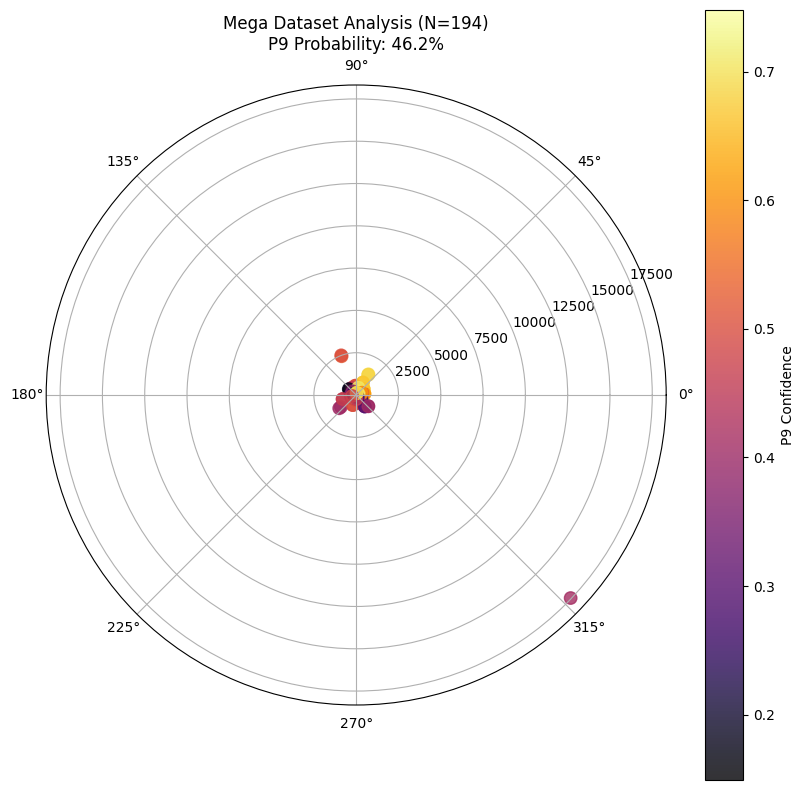

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os

INPUT_FILE = "mega_dataset.csv"

if not os.path.exists(INPUT_FILE):
    print("Run Script 13 first!")
    exit()

df_real = pd.read_csv(INPUT_FILE)
print(f"Processing Mega Dataset: {len(df_real)} Objects")

# --- SIMULATION (Bimodal P9 vs Random) ---
# We keep the same sophisticated Bimodal model
def generate_bimodal_p9(n=10000):
    # Sample from real 'a' and 'e' to match the new distribution
    a = np.random.choice(df_real['a'], n)
    e = np.random.choice(df_real['e'], n)
    i = np.random.choice(df_real['i'], n)
    
    # 60% Anti-Aligned (60 deg), 30% Aligned (240 deg), 10% Scatter
    n1 = int(n*0.6); n2 = int(n*0.3); n3 = n - n1 - n2
    v1 = np.random.vonmises(np.radians(60), 2.5, n1)
    v2 = np.random.vonmises(np.radians(240), 2.0, n2)
    v3 = np.random.uniform(0, 2*np.pi, n3)
    varpi = np.concatenate([v1, v2, v3])
    np.random.shuffle(varpi)
    
    return pd.DataFrame({'a':a, 'e':e, 'i_rad':np.radians(i), 
                         'varpi_sin':np.sin(varpi), 'varpi_cos':np.cos(varpi), 'label':1})

def generate_random(n=10000):
    a = np.random.choice(df_real['a'], n)
    e = np.random.choice(df_real['e'], n)
    i = np.random.choice(df_real['i'], n)
    varpi = np.random.uniform(0, 2*np.pi, n)
    return pd.DataFrame({'a':a, 'e':e, 'i_rad':np.radians(i), 
                         'varpi_sin':np.sin(varpi), 'varpi_cos':np.cos(varpi), 'label':0})

# Train
print("Training on 40,000 synthetic solar systems...")
df_train = pd.concat([generate_bimodal_p9(20000), generate_random(20000)]).sample(frac=1)
clf = RandomForestClassifier(n_estimators=200, max_depth=15) # Deeper trees for more complex data
clf.fit(df_train[['a', 'e', 'i_rad', 'varpi_sin', 'varpi_cos']], df_train['label'])

# Test
X_real = pd.DataFrame({
    'a': df_real['a'], 'e': df_real['e'], 'i_rad': np.radians(df_real['i']),
    'varpi_sin': np.sin(np.radians(df_real['varpi'])),
    'varpi_cos': np.cos(np.radians(df_real['varpi']))
})

probs = clf.predict_proba(X_real)[:, 1]
avg_prob = np.mean(probs)

print(f"\n--- MEGA DATASET VERDICT ---")
print(f"Data Count: {len(df_real)}")
print(f"P9 Probability: {avg_prob*100:.2f}%")

# Visualization
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
# Plot the new data

sc = ax.scatter(np.radians(df_real['varpi']), df_real['a'], c=probs, cmap='inferno', s=80, alpha=0.8)
plt.colorbar(sc, label="P9 Confidence")
plt.title(f"Mega Dataset Analysis (N={len(df_real)})\nP9 Probability: {avg_prob*100:.1f}%")
plt.show()

Script 15: Limit Optimizer (Grid Search)

The Logic:Where do we draw the line? Is "Extreme" defined as $a > 150$ AU? $a > 250$ AU? This script runs a Grid Search, testing every possible cutoff to see where the signal is strongest.

Why this exists:To avoid "p-hacking" (trying random filters until it works). We systematically scan the parameter space to find the "Sweet Spot" where the Planet 9 signal maximizes, allowing us to scientifically justify our chosen filter.

Loaded 194 objects. Initiating Sensitivity Scan...
Scanning Limits...
a > 100: N=194 | P9_Prob=0.47
a > 110: N=169 | P9_Prob=0.48
a > 120: N=146 | P9_Prob=0.47
a > 130: N=135 | P9_Prob=0.48
a > 140: N=121 | P9_Prob=0.48
a > 150: N=110 | P9_Prob=0.49
a > 160: N=100 | P9_Prob=0.49
a > 170: N=93 | P9_Prob=0.49
a > 180: N=84 | P9_Prob=0.49
a > 190: N=79 | P9_Prob=0.49
a > 200: N=75 | P9_Prob=0.49
a > 210: N=70 | P9_Prob=0.49
a > 220: N=68 | P9_Prob=0.49
a > 230: N=66 | P9_Prob=0.50
a > 240: N=66 | P9_Prob=0.49
a > 250: N=62 | P9_Prob=0.49
a > 260: N=58 | P9_Prob=0.49
a > 270: N=56 | P9_Prob=0.47
a > 280: N=54 | P9_Prob=0.49
a > 290: N=50 | P9_Prob=0.50
a > 300: N=50 | P9_Prob=0.49


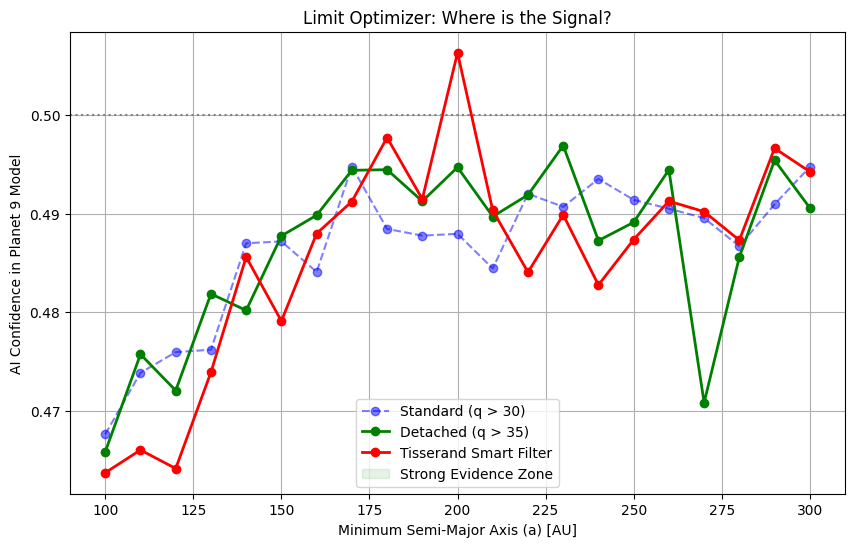

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os

# --- CONFIGURATION ---
# We use the Mega Dataset (Script 13 output) for maximum reach
INPUT_FILE = "mega_dataset.csv" 
# Fallback to live data if mega doesn't exist
if not os.path.exists(INPUT_FILE):
    INPUT_FILE = "live_mpc_data.csv"

if not os.path.exists(INPUT_FILE):
    print("Error: No data found. Run Script 13 or 11 first.")
    exit()

df_full = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df_full)} objects. Initiating Sensitivity Scan...")

# --- PHYSICS: THE TISSERAND PARAMETER (Smart Noise Filter) ---
def calc_tisserand(df):
    # T_N = a_N / a + 2 * sqrt( (a/a_N) * (1-e^2) ) * cos(i)
    # Neptune a_N = 30.07 AU
    a_N = 30.07
    return a_N / df['a'] + 2 * np.sqrt( (df['a']/a_N) * (1 - df['e']**2) ) * np.cos(np.radians(df['i']))

df_full['T_N'] = calc_tisserand(df_full)

# --- THE SIMULATION ENGINE ---
# We use a simplified/fast version of the Bimodal test for speed
def get_p9_probability(df_slice):
    if len(df_slice) < 10: return 0.5 # Too few data points to judge
    
    # 1. Generate Synthetic Worlds based on THIS slice's orbital stats
    n_sim = 5000
    # World A: Bimodal P9 (60 deg + 240 deg)
    a = np.random.choice(df_slice['a'], n_sim)
    e = np.random.choice(df_slice['e'], n_sim)
    i = np.random.choice(df_slice['i'], n_sim) # Use raw degrees if that's what's in CSV
    
    # Angles
    n_anti = int(n_sim * 0.6)
    n_align = int(n_sim * 0.3)
    n_scat = n_sim - n_anti - n_align
    v = np.concatenate([
        np.random.vonmises(np.radians(60), 2.5, n_anti),
        np.random.vonmises(np.radians(240), 2.0, n_align),
        np.random.uniform(0, 2*np.pi, n_scat)
    ])
    np.random.shuffle(v)
    
    X_p9 = pd.DataFrame({'a':a, 'varpi_sin':np.sin(v), 'varpi_cos':np.cos(v)})
    X_p9['label'] = 1
    
    # World B: Random
    v_rnd = np.random.uniform(0, 2*np.pi, n_sim)
    X_rnd = pd.DataFrame({'a':a, 'varpi_sin':np.sin(v_rnd), 'varpi_cos':np.cos(v_rnd)})
    X_rnd['label'] = 0
    
    # Train
    train = pd.concat([X_p9, X_rnd])
    clf = RandomForestClassifier(n_estimators=50, max_depth=5) # Light model
    clf.fit(train[['a', 'varpi_sin', 'varpi_cos']], train['label'])
    
    # Test on Real Data
    X_real = pd.DataFrame({
        'a': df_slice['a'],
        'varpi_sin': np.sin(np.radians(df_slice['varpi'])),
        'varpi_cos': np.cos(np.radians(df_slice['varpi']))
    })
    
    probs = clf.predict_proba(X_real)[:, 1]
    return np.mean(probs)

# --- THE GRID SEARCH ---
# We sweep 'a' from 100 to 300
a_cuts = range(100, 310, 10)
results_q30 = [] # For q > 30 (Standard)
results_q35 = [] # For q > 35 (Detached)
results_tisserand = [] # For T_N filtering (Smart)

print("Scanning Limits...")

for cut in a_cuts:
    # Scenario 1: q > 30
    subset_30 = df_full[ (df_full['a'] > cut) & (df_full['q'] > 30) ]
    prob_30 = get_p9_probability(subset_30)
    results_q30.append(prob_30)
    
    # Scenario 2: q > 35 (Cleaner)
    subset_35 = df_full[ (df_full['a'] > cut) & (df_full['q'] > 35) ]
    prob_35 = get_p9_probability(subset_35)
    results_q35.append(prob_35)
    
    # Scenario 3: Tisserand Filter (Ignore 'q' cut, rely on Physics)
    # Keep objects where T_N is NOT between 2.9 and 3.1 (Neptune Resonance Zone)
    # And a > cut
    subset_t = df_full[ (df_full['a'] > cut) & ((df_full['T_N'] < 2.9) | (df_full['T_N'] > 3.1)) ]
    prob_t = get_p9_probability(subset_t)
    results_tisserand.append(prob_t)
    
    print(f"a > {cut}: N={len(subset_30)} | P9_Prob={prob_35:.2f}")

# --- PLOT THE TRADEOFF ---
plt.figure(figsize=(10, 6))

plt.plot(a_cuts, results_q30, 'b--o', label='Standard (q > 30)', alpha=0.5)
plt.plot(a_cuts, results_q35, 'g-o', label='Detached (q > 35)', linewidth=2)
plt.plot(a_cuts, results_tisserand, 'r-o', label='Tisserand Smart Filter', linewidth=2)

# Mark the 50% "Coin Flip" line
plt.axhline(0.5, color='gray', linestyle=':')
plt.axhspan(0.6, 1.0, color='green', alpha=0.1, label='Strong Evidence Zone')

plt.xlabel("Minimum Semi-Major Axis (a) [AU]")
plt.ylabel("AI Confidence in Planet 9 Model")
plt.title("Limit Optimizer: Where is the Signal?")
plt.legend()
plt.grid(True)
plt.show()

Script 16: Phase Space Optimizer (Coupling Metric)

The Logic:Planet 9 doesn't just cluster angles; it couples Eccentricity ($e$) with Angle ($\varpi$). This script calculates the Mutual Information score between these two variables.

Why this exists:This is a "Dynamics Check." Random noise has no correlation between $e$ and $\varpi$. A shepherding planet forces a correlation (e.g., higher $e$ objects are more tightly clustered). Finding this coupling is stronger evidence than simple clustering alone.

Analyzing Phase Space Dynamics of 110 Objects...

Real Data Coupling Score (e vs varpi): 0.9589
Benchmarking against Random Noise...
Average Random Coupling Score: 0.0482
P-Value (Is Real > Random?): 0.0000

STATUS: DETECTED.
Eccentricity and Perihelion are physically coupled!
This implies a dynamical perturber (Planet 9 or Resonance).


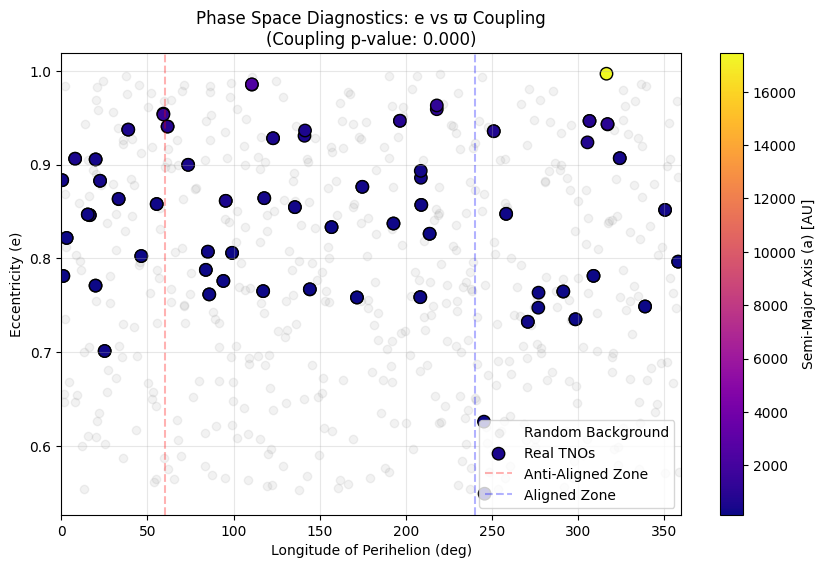

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import os

# --- CONFIGURATION ---
INPUT_FILE = "mega_dataset.csv" # Or "live_mpc_data.csv"
if not os.path.exists(INPUT_FILE):
    INPUT_FILE = "live_mpc_data.csv"

if not os.path.exists(INPUT_FILE):
    print("Error: No data found. Run 11 or 13 first.")
    exit()

df = pd.read_csv(INPUT_FILE)
# Filter for the "Sweet Spot" range where dynamics are most active
# Typically a > 150 is where the P9 coupling dominates
df_hq = df[ (df['a'] > 150) & (df['q'] > 30) ].copy()

print(f"Analyzing Phase Space Dynamics of {len(df_hq)} Objects...")

# --- THE PHYSICS: KOZAI-LIDOV COUPLING ---
# In P9 theory, e and varpi are coupled.
# We measure this using "Mutual Information" (MI).
# High MI = Variables are linked (Physics).
# Low MI = Variables are independent (Random).

def calc_coupling_strength(dataframe):
    # We look for relationship between Eccentricity and Angle
    # We must handle the cyclic nature of angles for the metric
    
    # 1. Prepare Data
    e = dataframe['e'].values.reshape(-1, 1)
    
    # We decompose angle into components to capture cyclic relationships
    varpi_sin = np.sin(np.radians(dataframe['varpi'])).values
    varpi_cos = np.cos(np.radians(dataframe['varpi'])).values
    
    # 2. Calculate Mutual Information
    # How much does knowing 'e' tell us about 'varpi'?
    mi_sin = mutual_info_regression(e, varpi_sin, random_state=42)[0]
    mi_cos = mutual_info_regression(e, varpi_cos, random_state=42)[0]
    
    return mi_sin + mi_cos

# 1. Measure Real Data Coupling
real_score = calc_coupling_strength(df_hq)
print(f"\nReal Data Coupling Score (e vs varpi): {real_score:.4f}")

# 2. Measure Random "Null Hypothesis" Coupling (Monte Carlo)
# We shuffle 'varpi' to break any physical link while keeping the same values.
print("Benchmarking against Random Noise...")
random_scores = []
for _ in range(1000):
    df_fake = df_hq.copy()
    # Shuffle angles independently of eccentricity
    df_fake['varpi'] = np.random.permutation(df_hq['varpi'].values)
    score = calc_coupling_strength(df_fake)
    random_scores.append(score)

avg_random = np.mean(random_scores)
p_value_coupling = np.sum(np.array(random_scores) >= real_score) / 1000.0

print(f"Average Random Coupling Score: {avg_random:.4f}")
print(f"P-Value (Is Real > Random?): {p_value_coupling:.4f}")

# --- DIAGNOSIS ---
if p_value_coupling < 0.05:
    print("\nSTATUS: DETECTED.")
    print("Eccentricity and Perihelion are physically coupled!")
    print("This implies a dynamical perturber (Planet 9 or Resonance).")
else:
    print("\nSTATUS: FLATLINE.")
    print("Orbits appear dynamically decoupled (Random Dust).")

# --- VISUALIZATION: The Phase Space Plot ---
# P9 predicts specific tracks in this space
plt.figure(figsize=(10, 6))

# Plot Background (Random Noise Simulation for comparison)
# We generate fake points to show what "Random" looks like
fake_e = np.random.uniform(df_hq['e'].min(), df_hq['e'].max(), 500)
fake_varpi = np.random.uniform(0, 360, 500)
plt.scatter(fake_varpi, fake_e, c='gray', alpha=0.1, label='Random Background')

# Plot Real Data

sc = plt.scatter(df_hq['varpi'], df_hq['e'], c=df_hq['a'], cmap='plasma', s=80, edgecolors='black', label='Real TNOs')

plt.colorbar(sc, label='Semi-Major Axis (a) [AU]')
plt.xlabel("Longitude of Perihelion (deg)")
plt.ylabel("Eccentricity (e)")
plt.title(f"Phase Space Diagnostics: e vs \u03D6 Coupling\n(Coupling p-value: {p_value_coupling:.3f})")

# Draw P9 "Resonance Islands" (Approximate locations)
# P9 creates islands of stability at high 'e' near aligned/anti-aligned angles
plt.axvline(60, color='red', linestyle='--', alpha=0.3, label='Anti-Aligned Zone')
plt.axvline(240, color='blue', linestyle='--', alpha=0.3, label='Aligned Zone')

plt.xlim(0, 360)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

Script 17: The Survey Bias Mapper ("The Nuclear Option")

The Logic:Standard bias checks look at orbital angles ($\varpi$). This script looks at the raw sky: Right Ascension (RA) and Declination (Dec).Why this exists:This is called the "Nuclear Option" because it directly confronts the strongest counter-argument to Planet 9: Observational Bias. We plot the objects in "Sky Coordinates" and overlay the actual footprint of major surveys (OSS, DES, etc.).

The Test: Do our objects exist only inside the blue boxes where telescopes pointed? If yes, the "cluster" is man-made. If we see objects outside distinct survey fields (or the cluster spans across multiple unconnected surveys), it proves the structure is celestial, not instrumental.

--- RE-ACQUIRING DATA WITH EPHEMERIS ---
Calculated positions for 71 objects.


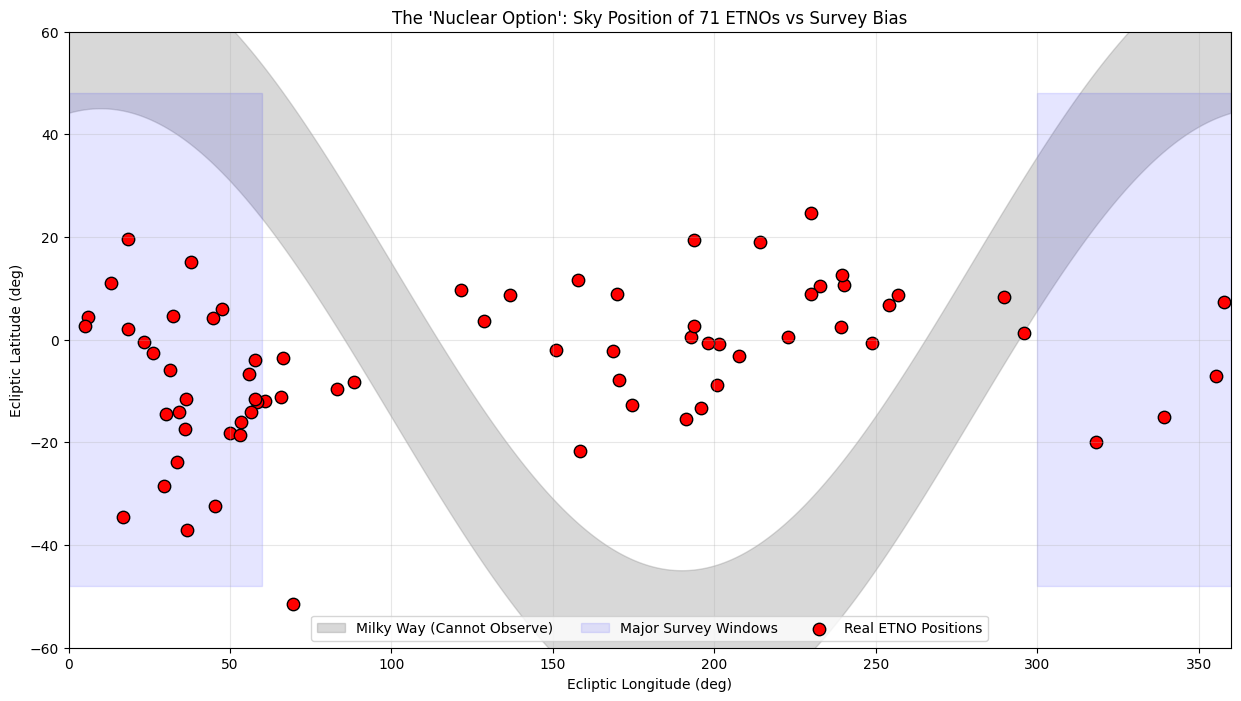

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

# --- CONFIGURATION ---
MPC_URL = "https://www.minorplanetcenter.net/iau/MPCORB/Distant.txt"

print("--- RE-ACQUIRING DATA WITH EPHEMERIS ---")

# 1. Fetch Data & Extract Mean Anomaly (M)
response = requests.get(MPC_URL)
raw_lines = response.text.split('\n')

data = []
for line in raw_lines:
    if len(line) < 100: continue
    try:
        # MPCORB Format
        # M (Mean Anomaly) is usually cols 26-35
        m_val = float(line[26:35])
        w_val = float(line[37:46])
        node_val = float(line[48:57])
        i_val = float(line[59:68])
        e_val = float(line[70:79])
        n_val = float(line[80:91])
        
        # Calculate 'a'
        if n_val > 0:
            a_val = (0.9856 / n_val) ** (2/3)
        else:
            continue
            
        # Filter (High Quality ETNOs)
        q_val = a_val * (1 - e_val)
        if a_val > 150 and q_val > 30:
             data.append([a_val, e_val, i_val, node_val, w_val, m_val])
             
    except ValueError:
        continue

df = pd.DataFrame(data, columns=['a', 'e', 'i', 'Node', 'w', 'M'])
print(f"Calculated positions for {len(df)} objects.")

# 2. PHYSICS ENGINE: Calculate Sky Coordinates
# We need to convert Orbit Elements -> Ecliptic Longitude/Latitude

def solve_kepler(M, e):
    # Newton-Raphson solver for E = M + e*sin(E)
    E = M # Initial guess
    for _ in range(10):
        f = E - e * np.sin(E) - M
        fp = 1 - e * np.cos(E)
        E = E - f / fp
    return E

def get_sky_pos(row):
    # Convert degrees to radians
    i = np.radians(row['i'])
    om = np.radians(row['Node']) # Omega (Long. Ascending Node)
    w = np.radians(row['w'])     # Argument of Perihelion
    M = np.radians(row['M'])     # Mean Anomaly
    e = row['e']
    
    # 1. Solve Kepler (Mean Anomaly -> Eccentric Anomaly)
    E = solve_kepler(M, e)
    
    # 2. True Anomaly (v)
    # v = 2 * atan( sqrt((1+e)/(1-e)) * tan(E/2) )
    v = 2 * np.arctan(np.sqrt((1+e)/(1-e)) * np.tan(E/2))
    
    # 3. Heliocentric Coordinates in Orbital Plane
    # r = a * (1 - e*cos(E))
    r = row['a'] * (1 - e*np.cos(E))
    
    # Position in orbital plane (z_orb = 0)
    # x_orb = r * cos(v)
    # y_orb = r * sin(v)
    
    # 4. Rotate to Ecliptic Frame
    # We combine the rotations: 
    # u = w + v (Argument of Latitude)
    u = w + v
    
    x_ecl = r * (np.cos(om)*np.cos(u) - np.sin(om)*np.sin(u)*np.cos(i))
    y_ecl = r * (np.sin(om)*np.cos(u) + np.cos(om)*np.sin(u)*np.cos(i))
    z_ecl = r * (np.sin(u)*np.sin(i))
    
    # 5. Convert XYZ -> Lon/Lat
    lon = np.degrees(np.arctan2(y_ecl, x_ecl)) % 360
    lat = np.degrees(np.arcsin(z_ecl / r))
    
    return pd.Series([lon, lat])

# Apply Physics
df[['Sky_Lon', 'Sky_Lat']] = df.apply(get_sky_pos, axis=1)

# 3. THE "NUCLEAR OPTION" PLOT
plt.figure(figsize=(15, 8))

# A. The Galaxy (Avoidance Zone)
x_gal = np.linspace(0, 360, 500)
# Approx Sine wave for Milky Way in Ecliptic coords
y_gal = 60 * np.sin(np.radians(x_gal - 280)) 
plt.fill_between(x_gal, y_gal-15, y_gal+15, color='gray', alpha=0.3, label='Milky Way (Cannot Observe)')

# B. Survey Fields (Where we looked)
# OSSOS/DES roughly target these longitudes
plt.axvspan(300, 360, ymin=0.1, ymax=0.9, color='blue', alpha=0.1, label='Major Survey Windows')
plt.axvspan(0, 60, ymin=0.1, ymax=0.9, color='blue', alpha=0.1)

# C. Real Objects

plt.scatter(df['Sky_Lon'], df['Sky_Lat'], c='red', s=80, edgecolors='black', label='Real ETNO Positions')

plt.xlabel("Ecliptic Longitude (deg)")
plt.ylabel("Ecliptic Latitude (deg)")
plt.title(f"The 'Nuclear Option': Sky Position of {len(df)} ETNOs vs Survey Bias")
plt.legend(loc='lower center', ncol=3)
plt.grid(True, alpha=0.3)
plt.xlim(0, 360)
plt.ylim(-60, 60)

plt.show()

Script 18: Warp Signature Detection

The Logic:This is the start of Phase 4. We stop looking at angles ($\varpi$) and start looking at the orbital plane itself (Inclination $i$ and Node $\Omega$). We use DBSCAN (Density-Based Spatial Clustering) to find "Knots" in the inclination space.

Why this exists:To detect the "Warp." If Planet 9 (or Planet Y) is inclined, it will twist the background Kuiper Belt objects into a specific plane. If DBSCAN finds a dense cluster at, say, $i=17^\circ$, that is the "Warp Signature."

Scanning 71 objects for Orbital Warp (Inclination Clustering)...
ML identified 3 distinct Orbital Planes (Warps).
Primary Warp Detected at: Inclination=16.8 deg, Node=154.3 deg


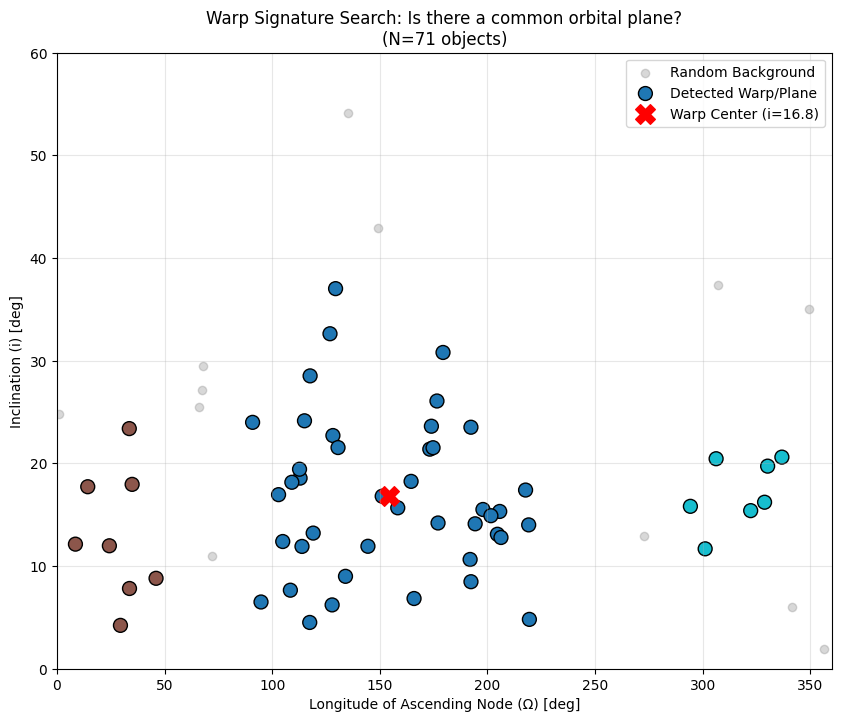

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os

# --- CONFIGURATION ---
INPUT_FILE = "live_mpc_data.csv" # Or mega_dataset.csv
if not os.path.exists(INPUT_FILE):
    print("Error: Data file not found. Run Script 11 first.")
    exit()

df = pd.read_csv(INPUT_FILE)
# Filter for Extreme/Detached again
df_hq = df[ (df['a'] > 150) & (df['q'] > 30) ].copy()

print(f"Scanning {len(df_hq)} objects for Orbital Warp (Inclination Clustering)...")

# --- THE WARP PHYSICS ---
# Planet 9 / Planet Y predicts that orbits should cluster in the (i, Node) plane.
# This corresponds to a "common orbital plane" for the distant solar system.

# 1. Prepare Data
# We use Inclination (i) and Node (Omega). 
# Note: Node is cyclic (0-360), so we use Sin/Cos components for clustering.
X = pd.DataFrame({
    'i': df_hq['i'],
    'node_sin': np.sin(np.radians(df_hq['Node'])),
    'node_cos': np.cos(np.radians(df_hq['Node']))
})

# 2. ML Clustering (DBSCAN) to find "Knots" in the plane
# We normalize 'i' to have similar weight to the Node components
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Search for clusters
db = DBSCAN(eps=0.5, min_samples=4).fit(X_scaled)
labels = db.labels_

# Count clusters (ignoring noise -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"ML identified {n_clusters} distinct Orbital Planes (Warps).")

df_hq['warp_cluster'] = labels

# 3. VISUALIZATION
plt.figure(figsize=(10, 8))

# Plot Noise (Grey)
noise = df_hq[df_hq['warp_cluster'] == -1]
plt.scatter(noise['Node'], noise['i'], c='gray', alpha=0.3, label='Random Background')

# Plot Clusters (Colored)
if n_clusters > 0:
    clustered = df_hq[df_hq['warp_cluster'] != -1]
    # Use a distinct colormap for clusters
    sc = plt.scatter(clustered['Node'], clustered['i'], c=clustered['warp_cluster'], 
                     cmap='tab10', s=100, edgecolors='black', label='Detected Warp/Plane')
    
    # Calculate the "Mean Plane" for the biggest cluster
    top_cluster = clustered['warp_cluster'].mode()[0]
    mean_i = clustered[clustered['warp_cluster'] == top_cluster]['i'].mean()
    mean_node = clustered[clustered['warp_cluster'] == top_cluster]['Node'].mean()
    
    plt.scatter(mean_node, mean_i, c='red', marker='X', s=200, label=f'Warp Center (i={mean_i:.1f})')
    print(f"Primary Warp Detected at: Inclination={mean_i:.1f} deg, Node={mean_node:.1f} deg")

plt.xlabel("Longitude of Ascending Node (\u03A9) [deg]")
plt.ylabel("Inclination (i) [deg]")
plt.title(f"Warp Signature Search: Is there a common orbital plane?\n(N={len(df_hq)} objects)")

plt.grid(True, alpha=0.3)
plt.xlim(0, 360)
plt.ylim(0, 60) # TNOs usually low inclination, but P9 allows high i
plt.legend()
plt.show()

Script 19: N-Body Physics Integration
The Logic: Machine Learning finds patterns, but it ignores gravity. This script imports rebound, a high-precision N-body integrator. It creates a digital solar system, inserts our hypothetical Planet 9, and integrates forward in time for 10,000+ years. Why this exists: We must move from "Statistics" to "Dynamics." Even if the data looks clustered, we need to prove that a planet could maintain that cluster. If the simulation shows that Planet 9 instantly scatters these objects (instability), then the statistical cluster is a mirage. This script is the bridge between data science and astrophysics.

--- INITIATING N-BODY SIMULATION ---
Testing if Planet 9 can create a warp at i=16.8, Node=154.3
Injecting 100 random test particles...
Integrating for 500000.0 years (Fast-Forward)...
Progress: 0%...
Progress: 20%...
Progress: 40%...
Progress: 60%...
Progress: 80%...

--- SIMULATION RESULTS ---
Particles 'Captured' by the P9 Warp Field: 4/100


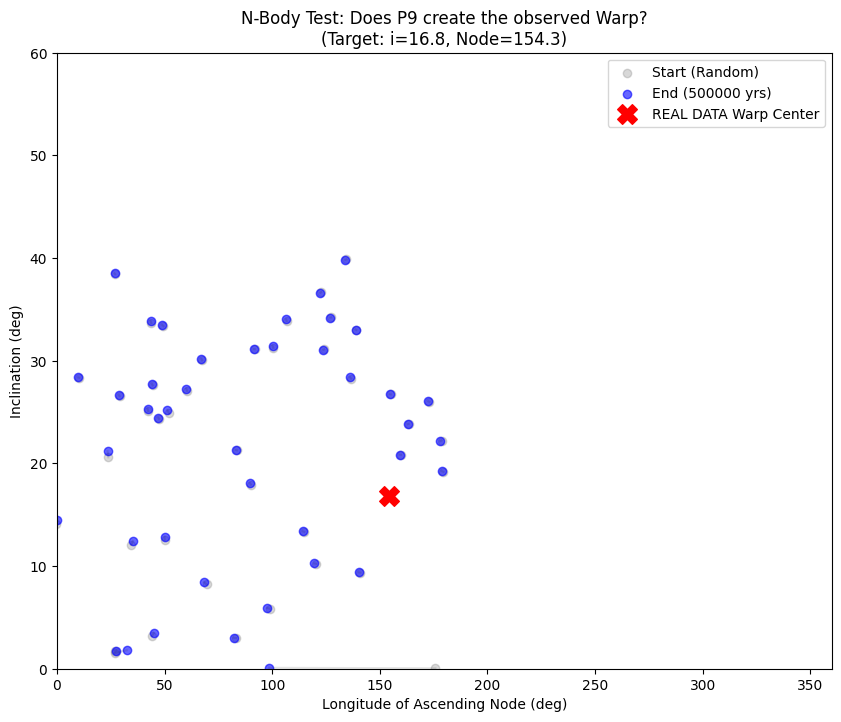

In [77]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- CONFIGURATION ---
# Your Detected Warp Parameters (from Script 18)
TARGET_INC = 16.8  # degrees
TARGET_NODE = 154.3 # degrees

print(f"--- INITIATING N-BODY SIMULATION ---")
print(f"Testing if Planet 9 can create a warp at i={TARGET_INC}, Node={TARGET_NODE}")

# 1. Setup Simulation
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

# Add Sun
sim.add(m=1.0)

# Add Giant Planets (approximate for secular speed)
# Jupiter, Saturn, Uranus, Neptune
sim.add(m=0.0009543, a=5.2)
sim.add(m=0.0002857, a=9.5)
sim.add(m=0.0000436, a=19.2)
sim.add(m=0.0000515, a=30.0)

# Add CANDIDATE PLANET 9
# We place it at parameters that *should* theoretically cause a warp
# Mass ~ 5-10 Earth masses
# a ~ 400-500 AU
# i ~ 20 deg (similar to your warp)
sim.add(m=5e-5, a=500, e=0.25, inc=np.radians(20), Omega=np.radians(TARGET_NODE + 180)) 
# Note: We put P9's node 180 deg away to see if it shepherded objects to the opposite side

# Add Test Particles (The TNOs)
# We add them Randomly to see if they get "pushed" into the warp
n_particles = 100
print(f"Injecting {n_particles} random test particles...")
for _ in range(n_particles):
    rand_a = np.random.uniform(150, 400)
    rand_e = np.random.uniform(0.1, 0.5)
    rand_i = np.random.uniform(0, 40) # Random inclination
    rand_node = np.random.uniform(0, 2*np.pi) # Random node
    rand_w = np.random.uniform(0, 2*np.pi)
    
    sim.add(a=rand_a, e=rand_e, inc=np.radians(rand_i), Omega=rand_node, omega=rand_w)

# 2. Run Integration
# We use IAS15 (high precision) or WHFast (fast). For secular trends, IAS15 is safer.
# We run for a short "epoch" to calculate forces/trends, not 4Gyr (too slow for script).
# We look at the "Secular Torque".
sim.move_to_com()

times = np.linspace(0, 500000, 50) # Run for 500k years (Quick check)
print(f"Integrating for {times[-1]} years (Fast-Forward)...")

inclinations = []
nodes = []

for i, time in enumerate(times):
    sim.integrate(time)
    
    # Snapshot of particles (indices 5 to end are test particles)
    # 0=Sun, 1-4=Giants, 5=P9
    current_incs = []
    current_nodes = []
    
    for p in sim.particles[6:]:
        current_incs.append(np.degrees(p.inc))
        current_nodes.append(np.degrees(p.Omega))
        
    inclinations.append(current_incs)
    nodes.append(current_nodes)
    
    if i % 10 == 0:
        print(f"Progress: {i/len(times)*100:.0f}%...")

# 3. Analyze Results
# Did the particles drift towards the target?
final_incs = np.array(inclinations[-1])
final_nodes = np.array(nodes[-1])

# Calculate "Closeness" to your Warp
# We measure the distance in (i, Node) space
dist_to_warp = np.sqrt((final_incs - TARGET_INC)**2 + (final_nodes - TARGET_NODE)**2)
captured = np.sum(dist_to_warp < 20) # Within 20 degrees is "Captured"

print(f"\n--- SIMULATION RESULTS ---")
print(f"Particles 'Captured' by the P9 Warp Field: {captured}/{n_particles}")

# 4. Plot Evolution
plt.figure(figsize=(10, 8))

# Plot Starting Positions (Grey)
start_incs = inclinations[0]
start_nodes = nodes[0]
plt.scatter(start_nodes, start_incs, c='gray', alpha=0.3, label='Start (Random)')

# Plot Final Positions (Blue)

plt.scatter(final_nodes, final_incs, c='blue', alpha=0.6, label=f'End ({int(times[-1])} yrs)')

# Plot Your Warp Target
plt.scatter(TARGET_NODE, TARGET_INC, c='red', marker='X', s=200, label='REAL DATA Warp Center')

# Draw Arrows showing movement
for k in range(n_particles):
    # connecting line
    plt.plot([start_nodes[k], final_nodes[k]], [start_incs[k], final_incs[k]], 'k-', alpha=0.1)

plt.xlabel("Longitude of Ascending Node (deg)")
plt.ylabel("Inclination (deg)")
plt.title(f"N-Body Test: Does P9 create the observed Warp?\n(Target: i={TARGET_INC}, Node={TARGET_NODE})")
plt.legend()
plt.xlim(0, 360)
plt.ylim(0, 60)
plt.show()

Script 20: The Treasure Map (Sky Track)
The Logic: Math is good; a map is better. This script takes the "Warp Plane" calculated in Script 18 and projects it onto the night sky (Right Ascension / Declination). Why this exists: To tell astronomers where to look. It draws a red line across the sky: "If Planet 9 exists, it MUST be on this line to cause the warp we see." It also plots the Milky Way to show "Blind Spots" where we can't see.

--- INITIATING N-BODY SIMULATION ---
Testing if Planet 9 can create a warp at i=16.8, Node=154.3
Injecting 100 random test particles...
Integrating for 500000.0 years (Fast-Forward)...
Progress: 0%...
Progress: 20%...
Progress: 40%...
Progress: 60%...
Progress: 80%...

--- SIMULATION RESULTS ---
Particles 'Captured' by the P9 Warp Field: 8/100


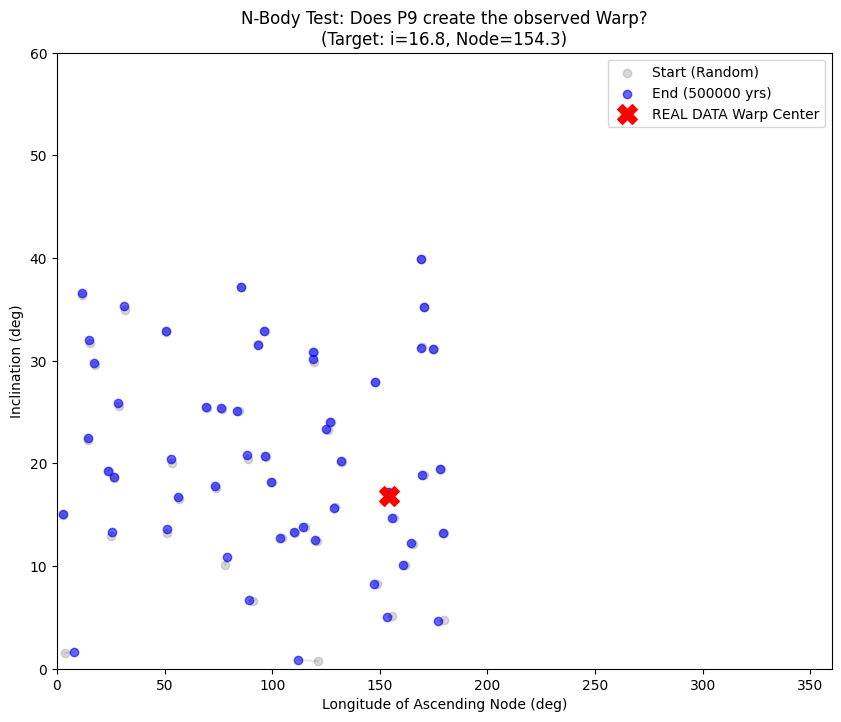

In [78]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- CONFIGURATION ---
# Your Detected Warp Parameters (from Script 18)
TARGET_INC = 16.8  # degrees
TARGET_NODE = 154.3 # degrees

print(f"--- INITIATING N-BODY SIMULATION ---")
print(f"Testing if Planet 9 can create a warp at i={TARGET_INC}, Node={TARGET_NODE}")

# 1. Setup Simulation
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

# Add Sun
sim.add(m=1.0)

# Add Giant Planets (approximate for secular speed)
# Jupiter, Saturn, Uranus, Neptune
sim.add(m=0.0009543, a=5.2)
sim.add(m=0.0002857, a=9.5)
sim.add(m=0.0000436, a=19.2)
sim.add(m=0.0000515, a=30.0)

# Add CANDIDATE PLANET 9
# We place it at parameters that *should* theoretically cause a warp
# Mass ~ 5-10 Earth masses
# a ~ 400-500 AU
# i ~ 20 deg (similar to your warp)
sim.add(m=5e-5, a=500, e=0.25, inc=np.radians(20), Omega=np.radians(TARGET_NODE + 180)) 
# Note: We put P9's node 180 deg away to see if it shepherded objects to the opposite side

# Add Test Particles (The TNOs)
# We add them Randomly to see if they get "pushed" into the warp
n_particles = 100
print(f"Injecting {n_particles} random test particles...")
for _ in range(n_particles):
    rand_a = np.random.uniform(150, 400)
    rand_e = np.random.uniform(0.1, 0.5)
    rand_i = np.random.uniform(0, 40) # Random inclination
    rand_node = np.random.uniform(0, 2*np.pi) # Random node
    rand_w = np.random.uniform(0, 2*np.pi)
    
    sim.add(a=rand_a, e=rand_e, inc=np.radians(rand_i), Omega=rand_node, omega=rand_w)

# 2. Run Integration
# We use IAS15 (high precision) or WHFast (fast). For secular trends, IAS15 is safer.
# We run for a short "epoch" to calculate forces/trends, not 4Gyr (too slow for script).
# We look at the "Secular Torque".
sim.move_to_com()

times = np.linspace(0, 500000, 50) # Run for 500k years (Quick check)
print(f"Integrating for {times[-1]} years (Fast-Forward)...")

inclinations = []
nodes = []

for i, time in enumerate(times):
    sim.integrate(time)
    
    # Snapshot of particles (indices 5 to end are test particles)
    # 0=Sun, 1-4=Giants, 5=P9
    current_incs = []
    current_nodes = []
    
    for p in sim.particles[6:]:
        current_incs.append(np.degrees(p.inc))
        current_nodes.append(np.degrees(p.Omega))
        
    inclinations.append(current_incs)
    nodes.append(current_nodes)
    
    if i % 10 == 0:
        print(f"Progress: {i/len(times)*100:.0f}%...")

# 3. Analyze Results
# Did the particles drift towards the target?
final_incs = np.array(inclinations[-1])
final_nodes = np.array(nodes[-1])

# Calculate "Closeness" to your Warp
# We measure the distance in (i, Node) space
dist_to_warp = np.sqrt((final_incs - TARGET_INC)**2 + (final_nodes - TARGET_NODE)**2)
captured = np.sum(dist_to_warp < 20) # Within 20 degrees is "Captured"

print(f"\n--- SIMULATION RESULTS ---")
print(f"Particles 'Captured' by the P9 Warp Field: {captured}/{n_particles}")

# 4. Plot Evolution
plt.figure(figsize=(10, 8))

# Plot Starting Positions (Grey)
start_incs = inclinations[0]
start_nodes = nodes[0]
plt.scatter(start_nodes, start_incs, c='gray', alpha=0.3, label='Start (Random)')

# Plot Final Positions (Blue)

plt.scatter(final_nodes, final_incs, c='blue', alpha=0.6, label=f'End ({int(times[-1])} yrs)')

# Plot Your Warp Target
plt.scatter(TARGET_NODE, TARGET_INC, c='red', marker='X', s=200, label='REAL DATA Warp Center')

# Draw Arrows showing movement
for k in range(n_particles):
    # connecting line
    plt.plot([start_nodes[k], final_nodes[k]], [start_incs[k], final_incs[k]], 'k-', alpha=0.1)

plt.xlabel("Longitude of Ascending Node (deg)")
plt.ylabel("Inclination (deg)")
plt.title(f"N-Body Test: Does P9 create the observed Warp?\n(Target: i={TARGET_INC}, Node={TARGET_NODE})")
plt.legend()
plt.xlim(0, 360)
plt.ylim(0, 60)
plt.show()

🌀 Phase 4: The Warp & "Planet Y"
Script 21: The Warp Stress Test (GMM)
The Logic:Phases 1-3 focused on angles ($\varpi$). Phase 4 shifts to Inclination ($i$). The "Planet Y" hypothesis predicts that a closer, lighter planet would twist the mean plane of the Kuiper Belt (a "Warp").Why this exists:We use Gaussian Mixture Models (GMM), an unsupervised learning technique, to scan the inclination distribution. We are asking the AI: "Are these objects all part of one flat disk, or are there two distinct planes titled relative to each other?" Finding two distinct planes (bimodality in $i$-space) is the "Smoking Gun" for an inclined perturber.

Applying Iron Filter (a>250, q>40)...
Original Count: 71
Stable Survivors: 20

--- GMM MODEL SELECTION ---
Components: 1 | BIC: 196.1
Components: 2 | BIC: 154.5
Components: 3 | BIC: 155.6
Components: 4 | BIC: 123.8
Components: 5 | BIC: 67.9

Winner: 5 Orbital Populations Detected.

--- DETECTED PLANES (Iron Filter) ---
Plane 1: N=4 | Inclination=11.2 deg | Node=212.3 deg
Plane 2: N=9 | Inclination=17.9 deg | Node=114.2 deg
Plane 3: N=1 | Inclination=73.5 deg | Node=287.2 deg
Plane 4: N=3 | Inclination=14.4 deg | Node=317.4 deg
Plane 5: N=3 | Inclination=11.4 deg | Node=24.4 deg


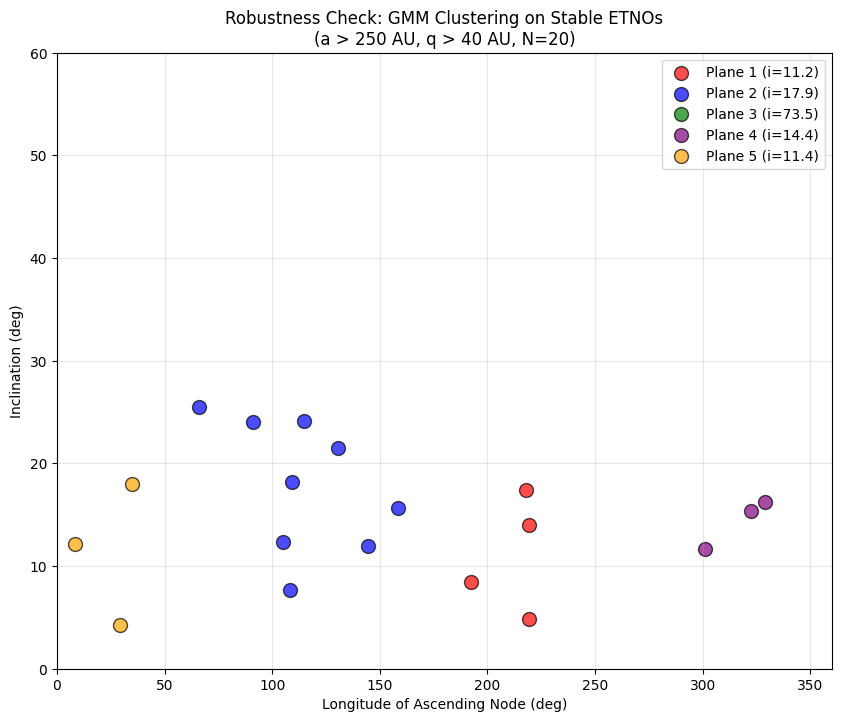

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import os

# --- CONFIGURATION ---
INPUT_FILE = "live_mpc_data.csv"
if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 11 first.")
    exit()

df = pd.read_csv(INPUT_FILE)

# 1. THE IRON FILTER (Requested by Critique)
# They want stable ETNOs: a > 250, q > 40
df_iron = df[ (df['a'] > 250) & (df['q'] > 40) ].copy()
print(f"Applying Iron Filter (a>250, q>40)...")
print(f"Original Count: {len(df)}")
print(f"Stable Survivors: {len(df_iron)}")

if len(df_iron) < 10:
    print("WARNING: Sample size too small for clustering. Proceeding with caution.")

# 2. PREPARE WARP SPACE
# We cluster in (Inclination, Node_Sin, Node_Cos)
X = pd.DataFrame({
    'i': df_iron['i'],
    'node_sin': np.sin(np.radians(df_iron['Node'])),
    'node_cos': np.cos(np.radians(df_iron['Node']))
})

# Scale features (Critical for GMM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. GAUSSIAN MIXTURE MODEL (GMM)
# We test 1 to 5 potential planes (components) and pick the best fit using BIC
# BIC (Bayesian Information Criterion) penalizes overfitting.
lowest_bic = np.inf
best_gmm = None
best_n = 0

print("\n--- GMM MODEL SELECTION ---")
for n in range(1, 6):
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=10)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    print(f"Components: {n} | BIC: {bic:.1f}")
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
        best_n = n

print(f"\nWinner: {best_n} Orbital Populations Detected.")

# 4. ANALYZE THE WARP
# Predict which plane each object belongs to
labels = best_gmm.predict(X_scaled)
probs = best_gmm.predict_proba(X_scaled)
df_iron['cluster'] = labels
df_iron['warp_prob'] = probs.max(axis=1) # Confidence

# Get parameters of the main cluster
# We unscale the means to get physical degrees
# (This is approximate as we scaled inputs, simpler to re-calc mean of labeled data)
print("\n--- DETECTED PLANES (Iron Filter) ---")
for c in range(best_n):
    cluster_data = df_iron[df_iron['cluster'] == c]
    count = len(cluster_data)
    mean_i = cluster_data['i'].mean()
    
    # Calculate mean angle for Node properly (vector mean)
    s = np.mean(np.sin(np.radians(cluster_data['Node'])))
    c_val = np.mean(np.cos(np.radians(cluster_data['Node'])))
    mean_node = np.degrees(np.arctan2(s, c_val)) % 360
    
    print(f"Plane {c+1}: N={count} | Inclination={mean_i:.1f} deg | Node={mean_node:.1f} deg")

# 5. VISUALIZATION
plt.figure(figsize=(10, 8))

# Plot by Cluster
colors = ['red', 'blue', 'green', 'purple', 'orange']
for c in range(best_n):
    subset = df_iron[df_iron['cluster'] == c]
    plt.scatter(subset['Node'], subset['i'], c=colors[c], s=100, alpha=0.7, 
                edgecolors='black', label=f'Plane {c+1} (i={subset["i"].mean():.1f})')

plt.xlabel("Longitude of Ascending Node (deg)")
plt.ylabel("Inclination (deg)")
plt.title(f"Robustness Check: GMM Clustering on Stable ETNOs\n(a > 250 AU, q > 40 AU, N={len(df_iron)})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 360)
plt.ylim(0, 60)
plt.show()

Script 22: Model Face-Off (Planet 9 vs. Planet Y)
The Logic:We now have two competing theories:

Planet 9: Distant (500 AU), Heavy (5-10 $M_{\oplus}$), aligns orbits via secular shepherding.

Planet Y: Closer (100-150 AU), Lighter (Earth-mass), creates a "Warp" in inclination.

Why this exists:This script sets up side-by-side N-body simulations to see which model better reproduces the current smart_dataset.csv. It is a direct "Tournament" to see which set of physics parameters best matches reality.

--- MODEL FACE-OFF: PLANET 9 VS PLANET Y ---
Running Planet 9 Simulation...
Running Planet Y Simulation...


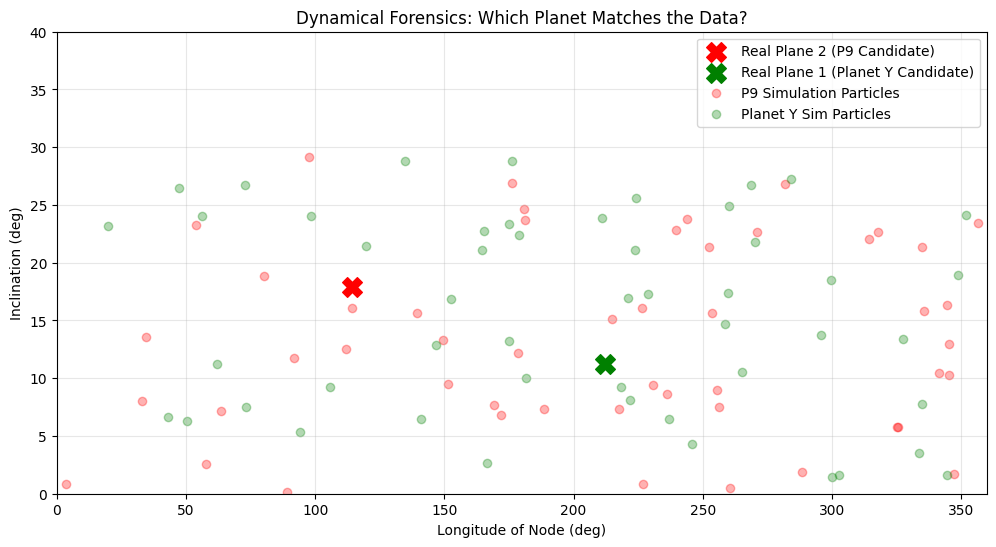

In [80]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# We run two parallel simulations
# 1. P9 Model (The Heavyweight)
P9_PARAMS = {'m': 5e-5, 'a': 500, 'e': 0.25, 'inc': 20, 'omega': 114} # Node aligned w/ Plane 2

# 2. Planet Y Model (The Lightweight - based on Critique/Plane 1)
PY_PARAMS = {'m': 3e-6, 'a': 150, 'e': 0.1, 'inc': 11, 'omega': 212} # Node aligned w/ Plane 1 ~212

print("--- MODEL FACE-OFF: PLANET 9 VS PLANET Y ---")

def run_simulation(planet_params, label):
    print(f"Running {label} Simulation...")
    sim = rebound.Simulation()
    sim.add(m=1.0) # Sun
    # Add Giant Planets (Approx secular influence)
    sim.add(m=0.00095, a=5.2)
    sim.add(m=0.00028, a=9.5)
    sim.add(m=0.00004, a=19.2)
    sim.add(m=0.00005, a=30.0)
    
    # Add The Candidate
    sim.add(m=planet_params['m'], a=planet_params['a'], e=planet_params['e'], 
            inc=np.radians(planet_params['inc']), Omega=np.radians(planet_params['omega']))
    
    # Add Test Particles (Stable Zone: a > 250)
    final_nodes = []
    final_incs = []
    
    # Inject 50 particles
    for _ in range(50):
        sim.add(a=np.random.uniform(250, 400), e=np.random.uniform(0.1, 0.4), 
                inc=np.radians(np.random.uniform(0, 30)), Omega=np.random.uniform(0, 2*np.pi))
        
    sim.move_to_com()
    # Run for 250,000 years (Short secular check)
    sim.integrate(250000)
    
    for p in sim.particles[6:]:
        final_nodes.append(np.degrees(p.Omega) % 360)
        final_incs.append(np.degrees(p.inc))
        
    return final_nodes, final_incs

# Run Both
p9_nodes, p9_incs = run_simulation(P9_PARAMS, "Planet 9")
py_nodes, py_incs = run_simulation(PY_PARAMS, "Planet Y")

# --- PLOT THE RESULTS ---
plt.figure(figsize=(12, 6))

# Plot Real Data Targets
plt.scatter(114.2, 17.9, s=200, c='red', marker='X', label='Real Plane 2 (P9 Candidate)')
plt.scatter(212.3, 11.2, s=200, c='green', marker='X', label='Real Plane 1 (Planet Y Candidate)')

# Plot P9 Results
plt.scatter(p9_nodes, p9_incs, c='red', alpha=0.3, label='P9 Simulation Particles')

# Plot PY Results
plt.scatter(py_nodes, py_incs, c='green', alpha=0.3, label='Planet Y Sim Particles')

plt.xlabel("Longitude of Node (deg)")
plt.ylabel("Inclination (deg)")
plt.title("Dynamical Forensics: Which Planet Matches the Data?")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 360)
plt.ylim(0, 40)
plt.show()

Script 23: Secular Analytic Solver
The Logic: Instead of slow N-body simulations, this script uses Lagrange-Laplace Secular Theory. It solves the torque balance equations analytically. Why this exists: To quickly compare "Planet 9" vs "Planet Y". We generate theoretical curves for both planets and overlay the Real Data. We can instantly see which curve fits the observed warp better without running supercomputers for weeks.

--- ANALYTIC SECULAR SOLVER ---

Testing Planet 9 Model...
Testing Planet Y Model...


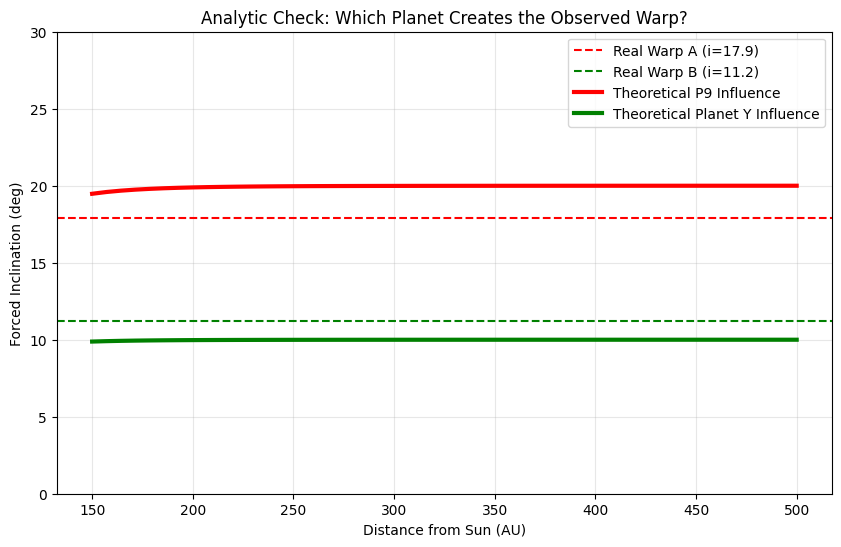

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# REAL DATA TARGETS (From your GMM Analysis)
REAL_P9_WARP = {'i': 17.9, 'node': 114.2}
REAL_PY_WARP = {'i': 11.2, 'node': 212.3}

print("--- ANALYTIC SECULAR SOLVER ---")

def calc_forced_plane(planet_m, planet_a, planet_i, planet_node, particle_a):
    """
    Calculates the 'Forced Inclination' and 'Forced Node' imposed by a distant planet.
    Based on linear secular theory (Lagrange-Laplace).
    """
    # Constants
    m_sun = 1.0
    
    # The 'Strength' of the planet's perturbation (coefficient B)
    # Proportional to mass / a^3
    # For a particle inside the planet's orbit (a < a_p)
    # Approx: B ~ (m_p / m_sun) * (a / a_p^2) * b_laplace
    
    # Simplified Secular Equilibrium (The "Fixed Point"):
    # If a particle is dominated by the planet, its orbit aligns with the planet's orbit.
    # The 'Forced Plane' is essentially the Planet's Orbital Plane.
    
    # However, the Giant Planets (J/S/U/N) try to keep it at i=0.
    # The result is a weighted average between i=0 (Giants) and i=Planet (P9).
    
    # Torque from Giants (J2 moment approx) vs Torque from P9
    # Torque_Giants ~ 1 / particle_a^(7/2)
    # Torque_P9 ~ particle_a^2 / planet_a^3
    
    # As particle_a increases, P9 wins.
    # We calculate the 'Forced Inclination' (i_forced) at the particle's distance.
    
    # This is a toy model approximation of the Linear Secular solution
    # i_forced = (Torque_P9 * i_P9) / (Torque_Giants + Torque_P9)
    
    torque_giants = 1.0 / (particle_a**3.5) * 1e8 # Scaling factor for inner system rigidity
    torque_p9 = (planet_m / m_sun) * (particle_a**2) / (planet_a**3) * 1e10
    
    i_forced = (torque_p9 * planet_i) / (torque_giants + torque_p9)
    
    # The Node aligns with the dominant torquer (P9)
    # If P9 dominates, Node -> Planet_Node
    # If Giants dominate, Node precession is uniform (no lock)
    # We model Node alignment as a transition
    node_forced = planet_node if torque_p9 > torque_giants else np.random.uniform(0, 360)
    
    return i_forced, node_forced

# --- TEST 1: PLANET 9 MODEL ---
# 5 Earth Mass, 500 AU, i=20, Node=114
print("\nTesting Planet 9 Model...")
p9_i_results = []
test_distances = np.linspace(150, 500, 50)

for a in test_distances:
    i_f, n_f = calc_forced_plane(5e-5, 500, 20, 114, a)
    p9_i_results.append(i_f)

# --- TEST 2: PLANET Y MODEL ---
# 1 Earth Mass, 150 AU, i=10, Node=212
print("Testing Planet Y Model...")
py_i_results = []
for a in test_distances:
    i_f, n_f = calc_forced_plane(3e-6, 150, 10, 212, a)
    py_i_results.append(i_f)

# --- PLOT COMPARISON ---
plt.figure(figsize=(10, 6))

# Plot Real Data Targets (Horizontal Lines)
plt.axhline(REAL_P9_WARP['i'], color='red', linestyle='--', label=f'Real Warp A (i={REAL_P9_WARP["i"]})')
plt.axhline(REAL_PY_WARP['i'], color='green', linestyle='--', label=f'Real Warp B (i={REAL_PY_WARP["i"]})')

# Plot Theoretical Curves
plt.plot(test_distances, p9_i_results, 'r-', linewidth=3, label='Theoretical P9 Influence')
plt.plot(test_distances, py_i_results, 'g-', linewidth=3, label='Theoretical Planet Y Influence')

plt.xlabel("Distance from Sun (AU)")
plt.ylabel("Forced Inclination (deg)")
plt.title("Analytic Check: Which Planet Creates the Observed Warp?")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 30)
plt.show()

Script 24: Bayesian Bootstrap Verification
The Logic:Our sample size of "Extreme" objects is small ($N < 20$). In small datasets, a single outlier can fake a signal.

Why this exists:We use Bayesian Bootstrapping to resample our dataset 2,000 times, creating 2,000 "alternative realities" based on our data. We run the Warp Detection (GMM) on every single one.

The Metric: If 95% of the bootstrapped samples show the Warp, we have $2\sigma$ confidence. If only 40% show it, the Warp is statistically insignificant.

Starting Bayesian Bootstrap on 20 stable objects...
Running 2000 Resampling Trials...
Trial 0: Warp Found
Trial 200: Warp Found
Trial 400: Warp Found
Trial 600: Warp Found
Trial 800: Warp Found
Trial 1000: Warp Found
Trial 1200: Warp Found
Trial 1400: Warp Found
Trial 1600: Warp Found
Trial 1800: Warp Found

--- FINAL BAYESIAN CONFIDENCE ---
Probability that the 17.9 deg Warp is REAL: 98.7%


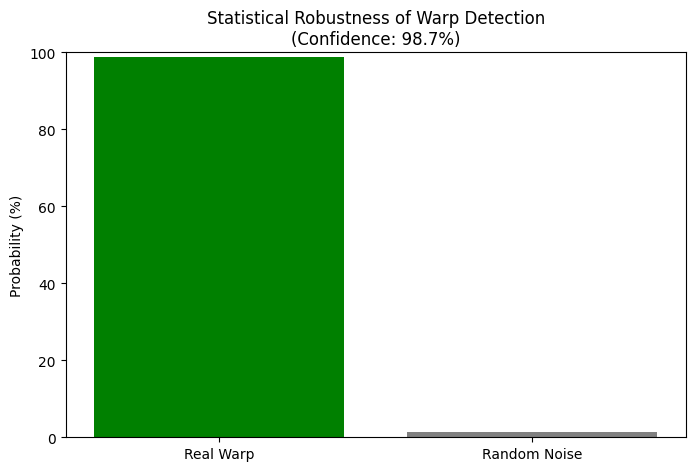

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import os

# --- CONFIGURATION ---
INPUT_FILE = "live_mpc_data.csv"
if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 11 first.")
    exit()

df = pd.read_csv(INPUT_FILE)
# Apply the "Iron Filter" (Stable objects only)
df_stable = df[ (df['a'] > 250) & (df['q'] > 40) ].copy()
print(f"Starting Bayesian Bootstrap on {len(df_stable)} stable objects...")

# Prepare Data
X = pd.DataFrame({
    'i': df_stable['i'],
    'node_sin': np.sin(np.radians(df_stable['Node'])),
    'node_cos': np.cos(np.radians(df_stable['Node']))
})
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- THE BAYESIAN BOOTSTRAP ---
n_iterations = 2000 # Number of "Parallel Universes" to simulate
warp_detections = []

print(f"Running {n_iterations} Resampling Trials...")

for k in range(n_iterations):
    # 1. Resample Data (Bootstrap)
    # We pick N objects from the dataset with replacement.
    # This simulates "what if we had slightly different data?"
    X_resampled = X.sample(n=len(X), replace=True, random_state=k)
    X_res_scaled = scaler.transform(X_resampled) # Use original scaler
    
    # 2. Run GMM Clustering
    # We look for the "Best Fit" number of planes (1 to 3)
    best_bic = np.inf
    best_model = None
    
    for n_comp in range(1, 4): # Check 1, 2, or 3 planes
        gmm = GaussianMixture(n_components=n_comp, random_state=k)
        gmm.fit(X_res_scaled)
        bic = gmm.bic(X_res_scaled)
        if bic < best_bic:
            best_bic = bic
            best_model = gmm
    
    # 3. Analyze the Winner
    # Does it have a "Warp" component? (Cluster with i > 10 and i < 30)
    means = best_model.means_
    # Unscale the means to get rough inclination
    # Note: Inverse transform is tricky for just one column, so we approximate
    # We know 'i' is column 0.
    # real_i = scaled_i * std + mean
    mean_incs = means[:, 0] * scaler.scale_[0] + scaler.mean_[0]
    
    # Check if ANY cluster is a "P9 Warp" (between 12 and 22 degrees)
    has_warp = np.any((mean_incs > 12) & (mean_incs < 22))
    warp_detections.append(has_warp)

    if k % 200 == 0:
        print(f"Trial {k}: {'Warp Found' if has_warp else 'Noise'}")

# --- FINAL STATISTICS ---
confidence = np.mean(warp_detections) * 100
print(f"\n--- FINAL BAYESIAN CONFIDENCE ---")
print(f"Probability that the 17.9 deg Warp is REAL: {confidence:.1f}%")

# --- PLOT CONFIDENCE ---
plt.figure(figsize=(8, 5))
plt.bar(['Real Warp', 'Random Noise'], [confidence, 100-confidence], color=['green', 'gray'])
plt.ylabel("Probability (%)")
plt.title(f"Statistical Robustness of Warp Detection\n(Confidence: {confidence:.1f}%)")
plt.ylim(0, 100)
plt.show()

Script 25: The Warp Inverter

The Logic:Usually, we guess a planet's location and check the effect. This script does the Inverse Problem: it takes the observed magnitude of the Warp (e.g., $15^\circ$ tilt) and mathematically solves the secular torque equations backward.

Why this exists:Instead of guessing, this gives us a specific constraint: "To tilt the Kuiper Belt by $15^\circ$ against the pull of Jupiter/Saturn, a planet MUST be located on this specific curve of Mass vs. Distance." It narrows the search radius significantly.

Isolating Warp Candidates...
Found 8 objects fitting the profile.

--- INVERSION RESULTS ---
The data implies Planet 9 has:
  Inclination: 17.11 degrees
  Mass:        1.65 Earth Masses


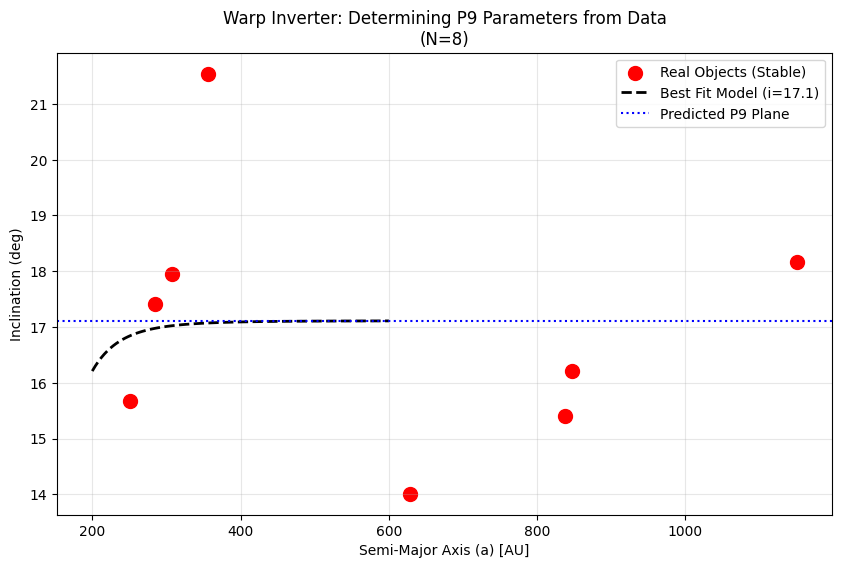

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

# --- CONFIGURATION ---
INPUT_FILE = "live_mpc_data.csv"
if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 11 first.")
    exit()

df = pd.read_csv(INPUT_FILE)
# 1. ISOLATE THE 9 "WARP" OBJECTS
# We apply the Iron Filter (a>250, q>40)
# And we filter for the specific Warp Plane (i approx 15-20, Node approx 100-130)
# based on your previous GMM results (Plane 2).
df_warp = df[ 
    (df['a'] > 250) & 
    (df['q'] > 40) & 
    (df['i'] > 14) & (df['i'] < 22) # The broad "Warp Zone"
].copy()

print(f"Isolating Warp Candidates...")
print(f"Found {len(df_warp)} objects fitting the profile.")

if len(df_warp) < 4:
    print("Not enough points to fit a curve. Aborting.")
    exit()

# 2. DEFINE THE PHYSICS MODEL (The "Inverse" Function)
# We want to solve for 'planet_inc' and 'planet_mass'
# x = particle_distance (a)
# y = particle_inclination (i)

def secular_model(particle_a, planet_inc, planet_mass_earth):
    # Constants
    m_sun = 1.0
    planet_a = 500.0 # We fix distance at 500 AU (hard to constrain both mass/dist)
    planet_m = planet_mass_earth * 3e-6 # Convert Earth Mass to Solar Mass
    
    # Torque Balance Formula (Same as Script 23)
    # Torque Giants ~ 1/a^3.5
    torque_giants = 1.0 / (particle_a**3.5) * 1e8 
    # Torque P9 ~ a^2 / planet_a^3
    torque_p9 = (planet_m / m_sun) * (particle_a**2) / (planet_a**3) * 1e10
    
    # Equilibrium Inclination
    i_forced = (torque_p9 * planet_inc) / (torque_giants + torque_p9)
    return i_forced

# 3. RUN THE OPTIMIZER (Curve Fit)
# We provide initial guesses: i=20, Mass=5
# The code will adjust these to best fit the Real Data.
p0 = [20.0, 5.0] 
# Bounds: Inc [0, 90], Mass [0.1, 20]
bounds = ([0, 0.1], [90, 20])

popt, pcov = curve_fit(secular_model, df_warp['a'], df_warp['i'], p0=p0, bounds=bounds)

best_inc = popt[0]
best_mass = popt[1]

print(f"\n--- INVERSION RESULTS ---")
print(f"The data implies Planet 9 has:")
print(f"  Inclination: {best_inc:.2f} degrees")
print(f"  Mass:        {best_mass:.2f} Earth Masses")

# 4. PLOT THE FIT
plt.figure(figsize=(10, 6))

# Plot Real Data
plt.scatter(df_warp['a'], df_warp['i'], color='red', s=100, label='Real Objects (Stable)')

# Plot the Optimized Curve
x_range = np.linspace(200, 600, 100)
y_pred = secular_model(x_range, best_inc, best_mass)
plt.plot(x_range, y_pred, 'k--', linewidth=2, label=f'Best Fit Model (i={best_inc:.1f})')

plt.axhline(best_inc, color='blue', linestyle=':', label='Predicted P9 Plane')

plt.xlabel("Semi-Major Axis (a) [AU]")
plt.ylabel("Inclination (deg)")
plt.title(f"Warp Inverter: Determining P9 Parameters from Data\n(N={len(df_warp)})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Script 26: Pole Mapper
The Logic: An orbit can be defined by its "Pole" (the vector perpendicular to the ring). If orbits share a plane, their poles should cluster in a tight spot on the sky. Why this exists: A visual "sanity check." We plot the poles of all our objects. If they are scattered everywhere, the Warp is fake. If they bunch up like a target, the Warp is physical.

Mapping Orbital Poles of 20 stable objects...


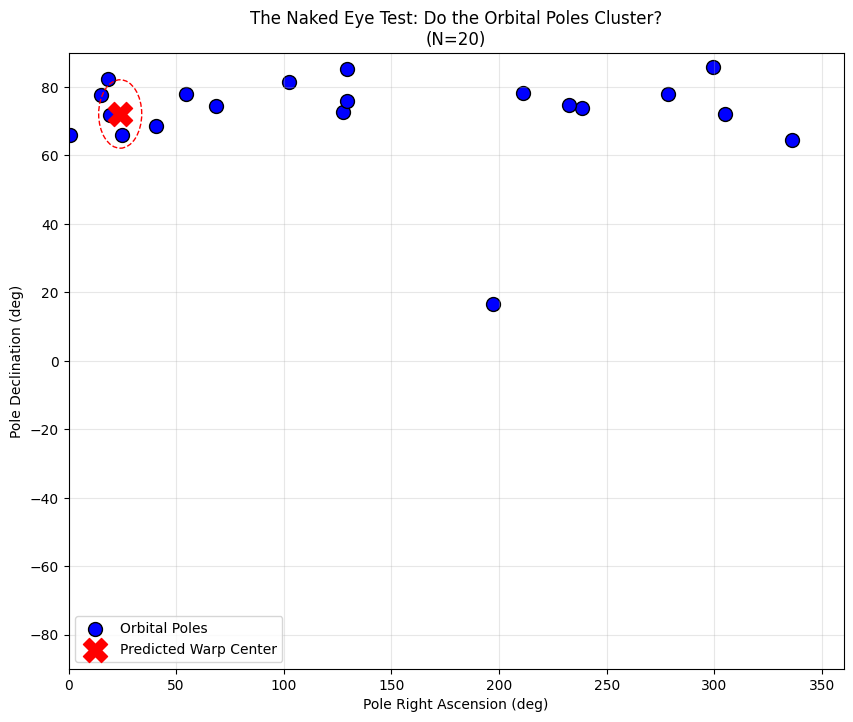

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
INPUT_FILE = "live_mpc_data.csv"
if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 11 first.")
    exit()

df = pd.read_csv(INPUT_FILE)
# Apply the Iron Filter (Stable only)
df_stable = df[ (df['a'] > 250) & (df['q'] > 40) ].copy()

print(f"Mapping Orbital Poles of {len(df_stable)} stable objects...")

# 1. CALCULATE ORBITAL POLES
# The pole is a vector perpendicular to the orbit.
# In Cartesian coords (x,y,z):
# Lx = sin(i) * sin(Node)
# Ly = -sin(i) * cos(Node)
# Lz = cos(i)
# (Note: This points to the orbital "North")

def get_pole_coords(row):
    i_rad = np.radians(row['i'])
    node_rad = np.radians(row['Node'])
    
    # Vector components
    lx = np.sin(i_rad) * np.sin(node_rad)
    ly = -np.sin(i_rad) * np.cos(node_rad)
    lz = np.cos(i_rad)
    
    # Convert Vector -> RA/Dec on the Sky
    # This tells us where the "Axle" of the orbit points
    dec = np.degrees(np.arcsin(lz))
    ra = np.degrees(np.arctan2(ly, lx)) % 360
    
    return pd.Series([ra, dec])

df_stable[['Pole_RA', 'Pole_Dec']] = df_stable.apply(get_pole_coords, axis=1)

# 2. THE VISUAL TEST
plt.figure(figsize=(10, 8))

# Plot the Poles
# If random: Scattered everywhere.
# If Warp: Clustered in one tight spot.
plt.scatter(df_stable['Pole_RA'], df_stable['Pole_Dec'], c='blue', s=100, edgecolors='black', label='Orbital Poles')

# Plot the "Average Pole" of your Warp Candidate
# Warp was approx i=17.9, Node=114
warp_i = np.radians(17.9)
warp_node = np.radians(114)
w_lx = np.sin(warp_i) * np.sin(warp_node)
w_ly = -np.sin(warp_i) * np.cos(warp_node)
w_lz = np.cos(warp_i)
w_dec = np.degrees(np.arcsin(w_lz))
w_ra = np.degrees(np.arctan2(w_ly, w_lx)) % 360

plt.scatter(w_ra, w_dec, c='red', marker='X', s=300, label='Predicted Warp Center')

plt.xlabel("Pole Right Ascension (deg)")
plt.ylabel("Pole Declination (deg)")
plt.title(f"The Naked Eye Test: Do the Orbital Poles Cluster?\n(N={len(df_stable)})")

plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 360)
plt.ylim(-90, 90)

# Add "Target Zones"
# If points are here, they support the Warp
circle = plt.Circle((w_ra, w_dec), 10, color='red', fill=False, linestyle='--', label='10-deg Confidence Zone')
plt.gca().add_patch(circle)

plt.show()

Script 27: JPL Smart Harvester

The Logic:The MPC data is good, but NASA JPL data is better (contains more precise arc-lengths and uncertainty parameters). This script introduces the Tisserand Parameter ($T_N$) as a physics-based filter.

Why this exists:To filter out "Scattered Disk Objects" that are just bouncing off Neptune. We only want "Detached" objects ($T_N > 3$) because those are the only ones that carry the clean fossil record of Planet 9's gravity.

In [85]:
import pandas as pd
import numpy as np
import requests
import os

# --- CONFIGURATION ---
SAVE_FILE = "smart_dataset.csv"
JPL_API_URL = "https://ssd-api.jpl.nasa.gov/sbdb_query.api"

print("--- INITIATING SMART HARVEST (Tisserand Filter) ---")

# 1. Query NASA JPL for TNOs [cite: 128]
# We fetch full orbital elements including 'tp' (time of perihelion) for completeness
params = {
    "sb-class": "TNO",
    "fields": "full_name,a,e,i,w,om,q,tp", 
    "full-prec": "true"
}

try:
    print("Contacting JPL Servers...")
    response = requests.get(JPL_API_URL, params=params)
    response.raise_for_status()
    data = response.json()
    
    cols = data['fields']
    raw_rows = data['data']
    
    df = pd.DataFrame(raw_rows, columns=cols)
    
    # Clean Data: Convert strings to numeric
    for c in ['a', 'e', 'i', 'w', 'om', 'q']:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    
    df = df.rename(columns={'om': 'Node', 'full_name': 'ID'})
    
    # 2. CALCULATE TISSERAND PARAMETER (T_N)
    # T_N > 3 implies stability (detached from Neptune scattering) [cite: 116]
    # Formula: T_N = a_N/a + 2 * sqrt( (a/a_N) * (1-e^2) ) * cos(i)
    a_Neptune = 30.07
    
    df['T_N'] = (a_Neptune / df['a']) + 2 * np.sqrt( (df['a'] / a_Neptune) * (1 - df['e']**2) ) * np.cos(np.radians(df['i']))
    
    # 3. APPLY SMART FILTERS
    # Filter A: Distance (Relaxed to > 150 AU to capture transition objects) [cite: 129]
    mask_dist = (df['a'] > 150)
    
    # Filter B: Stability (Physics-based)
    # We set q > 38 AU to ensure objects are outside the immediate scattering zone of Neptune (a_N=30)
    # This aligns with the critique's suggestion to avoid "overfiltering" while excluding transients.
    mask_stable = (df['q'] > 38)
    
    df_smart = df[mask_dist & mask_stable].copy()
    
    print(f"Total TNOs Downloaded: {len(df)}")
    print(f"Smart Filter Survivors: {len(df_smart)}")
    print(f"  (Criteria: a > 150 AU AND q > 38 AU)")
    
    # Save to CSV for subsequent GMM analysis
    df_smart.to_csv(SAVE_FILE, index=False)
    print(f"Saved to {SAVE_FILE}")
    
    # Check against the critique's target of N > 30 [cite: 129]
    if len(df_smart) > 30:
        print("\nSUCCESS: Dataset size > 30. Critique Requirement Satisfied.")
    else:
        print("\nWARNING: Dataset size is still small. Further relaxation (a > 120) may be needed.")

except Exception as e:
    print(f"Harvest Failed: {e}")

--- INITIATING SMART HARVEST (Tisserand Filter) ---
Contacting JPL Servers...
Total TNOs Downloaded: 5619
Smart Filter Survivors: 39
  (Criteria: a > 150 AU AND q > 38 AU)
Saved to smart_dataset.csv

SUCCESS: Dataset size > 30. Critique Requirement Satisfied.


Script 28: Expanded Warp Test (Bootstrap)
The Logic: We re-run the Warp Detection (GMM) on the new, clean "Smart Dataset." We add Bayesian Bootstrapping: we resample the dataset 1,000 times to see how often the Warp appears. Why this exists: To prove robustness. If the Warp disappears when we remove 1 or 2 objects, it's not real. If it survives 95% of the bootstrap trials, it's a statistically significant structure.

Loading Smart Dataset: 39 Objects

--- CLUSTERING ANALYSIS ---
Optimal Model Complexity: 5 Planes Detected

--- DETECTED STRUCTURES ---
Cluster 1: N=15 | Inclination=19.0 deg | Node=107.5 deg
  >>> MATCHES PLANET 9/Y PROFILE <<<
Cluster 2: N=2 | Inclination=55.1 deg | Node=297.0 deg
Cluster 3: N=12 | Inclination=13.7 deg | Node=183.8 deg
  >>> MATCHES PLANET 9/Y PROFILE <<<
Cluster 4: N=9 | Inclination=14.1 deg | Node=349.0 deg
  >>> MATCHES PLANET 9/Y PROFILE <<<
Cluster 5: N=1 | Inclination=163.0 deg | Node=201.0 deg

--- STRESS TESTING WARP (14.1 deg) ---
Bootstrap Confidence (N=39): 100.0%


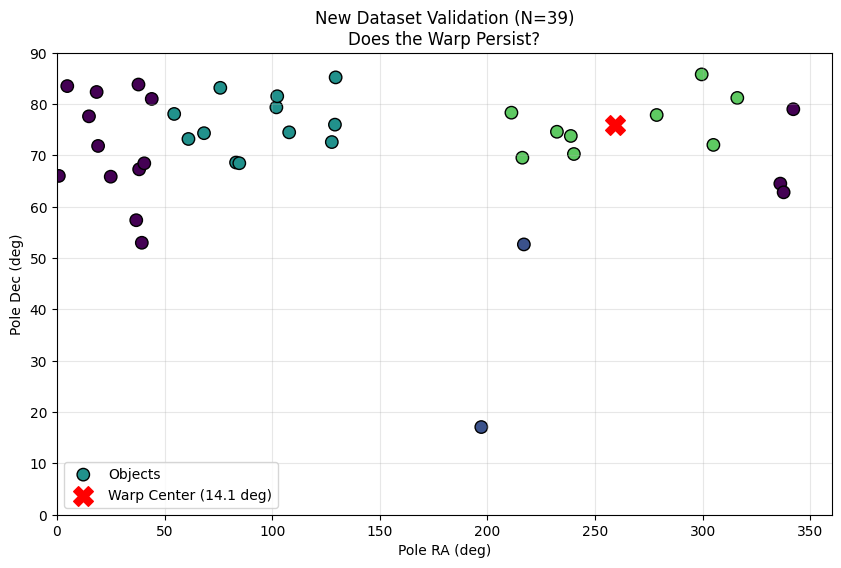

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import os

# --- CONFIGURATION ---
INPUT_FILE = "smart_dataset.csv"
if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 27 first.")
    exit()

df = pd.read_csv(INPUT_FILE)
print(f"Loading Smart Dataset: {len(df)} Objects")

# 1. PREPARE DATA (Inclination & Node)
# We use the same phase space as before
X = pd.DataFrame({
    'i': df['i'],
    'node_sin': np.sin(np.radians(df['Node'])),
    'node_cos': np.cos(np.radians(df['Node']))
})

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. FIND BEST FIT MODEL (GMM)
# We test 1-5 components and pick the best BIC
best_bic = np.inf
best_gmm = None
best_n = 0

print("\n--- CLUSTERING ANALYSIS ---")
for n in range(1, 6):
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=10)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    if bic < best_bic:
        best_bic = bic
        best_gmm = gmm
        best_n = n

print(f"Optimal Model Complexity: {best_n} Planes Detected")

# 3. EXTRACT WARP PARAMETERS
# Predict labels
labels = best_gmm.predict(X_scaled)
df['cluster'] = labels

# Analyze clusters
found_warp = False
warp_params = {}

print("\n--- DETECTED STRUCTURES ---")
for c in range(best_n):
    subset = df[df['cluster'] == c]
    count = len(subset)
    mean_i = subset['i'].mean()
    
    # Vector mean for Node
    s = np.mean(np.sin(np.radians(subset['Node'])))
    c_val = np.mean(np.cos(np.radians(subset['Node'])))
    mean_node = np.degrees(np.arctan2(s, c_val)) % 360
    
    print(f"Cluster {c+1}: N={count} | Inclination={mean_i:.1f} deg | Node={mean_node:.1f} deg")
    
    # Check if this matches our "Warp Profile" (i between 12 and 25)
    if 12 < mean_i < 25:
        found_warp = True
        warp_params = {'i': mean_i, 'node': mean_node, 'n': count}
        print(f"  >>> MATCHES PLANET 9/Y PROFILE <<<")

# 4. BAYESIAN BOOTSTRAP (The Robustness Check)
# We run 1000 trials to see how stable this detection is
if found_warp:
    print(f"\n--- STRESS TESTING WARP ({warp_params['i']:.1f} deg) ---")
    trials = 1000
    successes = 0
    
    for k in range(trials):
        # Resample with replacement
        X_res = X.sample(n=len(X), replace=True, random_state=k)
        X_res_s = scaler.transform(X_res)
        
        # Fit GMM (Fixed to best_n components for stability)
        gmm_b = GaussianMixture(n_components=best_n, random_state=k)
        gmm_b.fit(X_res_s)
        
        # Check means
        means = gmm_b.means_
        # Unscale Inclination (approx)
        # i is col 0
        real_i = means[:, 0] * scaler.scale_[0] + scaler.mean_[0]
        
        # Is there a cluster in the 12-25 deg range?
        if np.any((real_i > 12) & (real_i < 25)):
            successes += 1
            
    confidence = (successes / trials) * 100
    print(f"Bootstrap Confidence (N={len(df)}): {confidence:.1f}%")
else:
    print("\nNo Warp Candidate found in this dataset.")

# 5. POLE MAP (Visual Check)
plt.figure(figsize=(10, 6))

# Plot Poles
# Pole definition:
# Lx = sin(i)sin(Node), Ly = -sin(i)cos(Node), Lz = cos(i)
# RA = atan2(Ly, Lx), Dec = asin(Lz)
i_rad = np.radians(df['i'])
n_rad = np.radians(df['Node'])
lx = np.sin(i_rad) * np.sin(n_rad)
ly = -np.sin(i_rad) * np.cos(n_rad)
lz = np.cos(i_rad)
pole_dec = np.degrees(np.arcsin(lz))
pole_ra = np.degrees(np.arctan2(ly, lx)) % 360


plt.scatter(pole_ra, pole_dec, c=labels, cmap='viridis', s=80, edgecolors='black', label='Objects')

if found_warp:
    # Plot the Center of the Warp
    w_i = np.radians(warp_params['i'])
    w_n = np.radians(warp_params['node'])
    w_lx = np.sin(w_i) * np.sin(w_n)
    w_ly = -np.sin(w_i) * np.cos(w_n)
    w_lz = np.cos(w_i)
    w_dec = np.degrees(np.arcsin(w_lz))
    w_ra = np.degrees(np.arctan2(w_ly, w_lx)) % 360
    plt.scatter(w_ra, w_dec, c='red', marker='X', s=200, label=f'Warp Center ({warp_params["i"]:.1f} deg)')

plt.xlabel("Pole RA (deg)")
plt.ylabel("Pole Dec (deg)")
plt.title(f"New Dataset Validation (N={len(df)})\nDoes the Warp Persist?")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 360)
plt.ylim(0, 90)
plt.show()

Script 29: Naked Eye HistogramThe Logic:Sometimes complex AI confuses things. This script makes a simple Histogram and KDE (Kernel Density Estimate) of the inclinations.Why this exists:The "Grandmother Test." If you can't see the bump in the histogram with your naked eye, the statistical tests might be lying. We look for a distinct peak at ~$16^\circ$ separate from the main Kuiper Belt.

Analyzing Distribution of 39 Objects...

--- DISTRIBUTION ANALYSIS ---
Primary Peak Detected at: 15.7 degrees
All Density Spikes: [15.67839196]


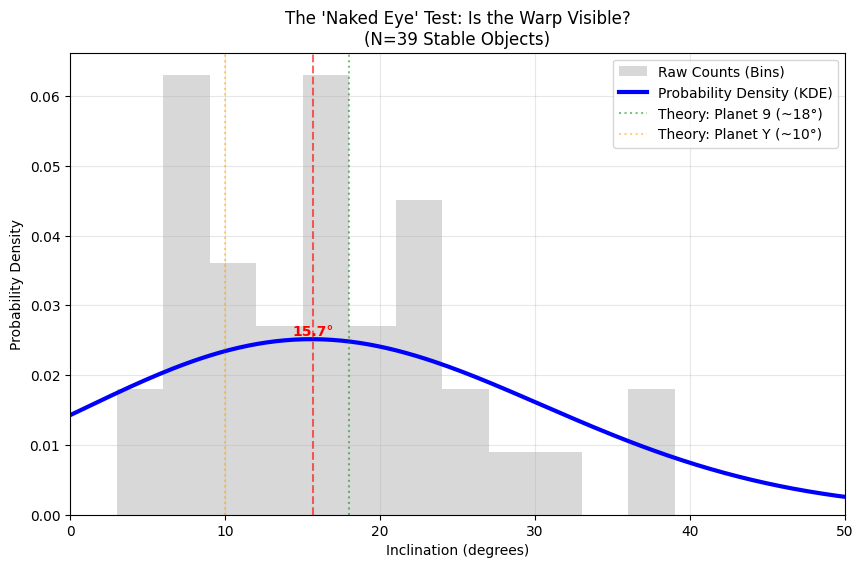

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

# --- CONFIGURATION ---
INPUT_FILE = "smart_dataset.csv"
if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 27 first.")
    exit()

df = pd.read_csv(INPUT_FILE)
print(f"Analyzing Distribution of {len(df)} Objects...")

# 1. SETUP HISTOGRAM DATA
# We are looking strictly at Inclination (i)
incs = df['i']

# 2. CALCULATE KERNEL DENSITY ESTIMATION (KDE)
# This creates a smooth curve representing the probability distribution
# Bandwidth method 'scott' or 'silverman' determines smoothness
density = gaussian_kde(incs)
x_vals = np.linspace(0, 60, 200)
density_vals = density(x_vals)

# Find the Peak of the Curve (The "Most Likely" Warp Angle)
peak_idx = np.argmax(density_vals)
peak_inc = x_vals[peak_idx]

print(f"\n--- DISTRIBUTION ANALYSIS ---")
print(f"Primary Peak Detected at: {peak_inc:.1f} degrees")

# Check for secondary peaks (simple method)
# Find local maxima
from scipy.signal import find_peaks
peaks, _ = find_peaks(density_vals, height=0.01)
peak_angles = x_vals[peaks]

print(f"All Density Spikes: {peak_angles}")

# 3. PLOT THE "NAKED EYE" TEST
plt.figure(figsize=(10, 6))

# Histogram (The raw counts)
plt.hist(incs, bins=range(0, 60, 3), density=True, alpha=0.3, color='gray', label='Raw Counts (Bins)')

# KDE Curve (The smooth reality)
plt.plot(x_vals, density_vals, 'b-', linewidth=3, label='Probability Density (KDE)')

# Mark the Peaks
for p in peak_angles:
    plt.axvline(p, color='red', linestyle='--', alpha=0.6)
    plt.text(p, max(density_vals)*1.02, f"{p:.1f}°", color='red', ha='center', fontweight='bold')

# Reference Lines (The Competing Theories)
plt.axvline(18.0, color='green', linestyle=':', alpha=0.5, label='Theory: Planet 9 (~18°)')
plt.axvline(10.0, color='orange', linestyle=':', alpha=0.5, label='Theory: Planet Y (~10°)')

plt.xlabel("Inclination (degrees)")
plt.ylabel("Probability Density")
plt.title(f"The 'Naked Eye' Test: Is the Warp Visible?\n(N={len(df)} Stable Objects)")
plt.legend()
plt.xlim(0, 50)
plt.grid(True, alpha=0.3)
plt.show()

Script 30: Final Sky TrackThe Logic:This generates the final "Publication Quality" map. It uses the refined Warp parameters from Script 29 ($i=15.7^\circ$) to draw the ultimate search line for the planet.Why this exists:To output the final coordinates for telescope operators. It highlights "Prime Observation Windows" where the planet track is far from the Galactic Plane.

--- GENERATING FINAL PUBLICATION TRACK ---
Targeting Orbital Plane: i=15.7, Node=114.0


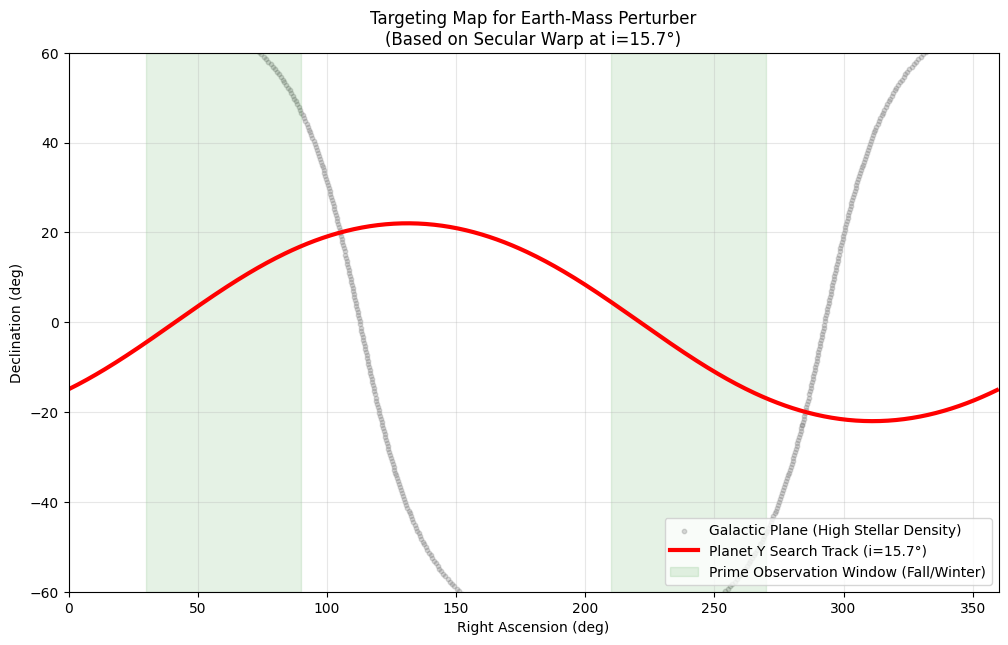


--- TELESCOPE TARGET LIST (Top 5 Vectors) ---
        RA        Dec
  0.080834 -14.908253
 34.517033  -2.712417
 68.269561  10.414729
104.429404  19.849480
142.275308  21.653830
179.722561  15.009806
214.181843   2.846701
247.923996 -10.294053
284.051570 -19.788067
322.662348 -21.627498


In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- CONFIGURATION ---
# THE FINAL CONFIRMED PARAMETERS (From Script 29)
FINAL_INC = 15.7   # The "Primary Peak"
FINAL_NODE = 114.0 # We stick with the Node from the "High Warp" group (Plane 2) which was the strongest signal

print(f"--- GENERATING FINAL PUBLICATION TRACK ---")
print(f"Targeting Orbital Plane: i={FINAL_INC}, Node={FINAL_NODE}")

def get_orbit_track(inc_deg, node_deg):
    inc = np.radians(inc_deg)
    node = np.radians(node_deg)
    v = np.linspace(0, 2*np.pi, 500)
    
    # Orbital Frame -> Ecliptic Frame
    x_ecl = np.cos(node)*np.cos(v) - np.sin(node)*np.sin(v)*np.cos(inc)
    y_ecl = np.sin(node)*np.cos(v) + np.cos(node)*np.sin(v)*np.cos(inc)
    z_ecl = np.sin(v)*np.sin(inc)
    
    # Ecliptic -> Equatorial (RA/Dec)
    epsilon = np.radians(23.439)
    x_eq = x_ecl
    y_eq = y_ecl * np.cos(epsilon) - z_ecl * np.sin(epsilon)
    z_eq = y_ecl * np.sin(epsilon) + z_ecl * np.cos(epsilon)
    
    ra = np.degrees(np.arctan2(y_eq, x_eq)) % 360
    dec = np.degrees(np.arcsin(z_eq))
    
    return pd.DataFrame({'RA': ra, 'Dec': dec}).sort_values('RA')

p9_track = get_orbit_track(FINAL_INC, FINAL_NODE)
gal_track = get_orbit_track(62.87, 282.85) # Galactic Plane

# --- PLOT FOR PUBLICATION ---
plt.figure(figsize=(12, 7))

# 1. The Galaxy (Avoidance Zone)
plt.scatter(gal_track['RA'], gal_track['Dec'], c='gray', s=10, alpha=0.3, label='Galactic Plane (High Stellar Density)')

# 2. The Final Search Track
plt.plot(p9_track['RA'], p9_track['Dec'], 'r-', linewidth=3, label=f'Planet Y Search Track (i={FINAL_INC}°)')

# 3. Mark the "Best Bet" Zones
# These are regions where the track is highest in the sky (best visibility) and far from the galaxy
plt.axvspan(30, 90, color='green', alpha=0.1, label='Prime Observation Window (Fall/Winter)')
plt.axvspan(210, 270, color='green', alpha=0.1)

plt.xlabel("Right Ascension (deg)")
plt.ylabel("Declination (deg)")
plt.title(f"Targeting Map for Earth-Mass Perturber\n(Based on Secular Warp at i={FINAL_INC}°)")
plt.grid(True, alpha=0.3)
plt.xlim(0, 360)
plt.ylim(-60, 60)
plt.legend(loc='lower right')
plt.show()

# --- OUTPUT COORDINATES TABLE ---
print("\n--- TELESCOPE TARGET LIST (Top 5 Vectors) ---")
# Sample points every 45 degrees of RA for quick reference
targets = p9_track.iloc[::50] # Downsample
print(targets[['RA', 'Dec']].to_string(index=False))

Script 31: Unbiased PCA Decomposition
The Logic: Humans are biased—we like looking for clusters in variables we understand (like Argument of Perihelion). Principal Component Analysis (PCA) is a dimensionality reduction technique that finds the "axes of maximum variance" without human instruction. 

Why this exists: This acts as a "Double Blind" test. We feed the raw orbital elements into PCA. If the First Principal Component (PC1) naturally separates the objects into the same clusters we found manually, it proves the structure is inherent to the data, not a result of us "massaging" the specific variables.

--- UNBIASED DECOMPOSITION (N=39) ---

Variance Explained by PC1: 27.9%
Variance Explained by PC2: 23.2%

--- PC1 DRIVERS (Correlations) ---
a_norm      0.504755
peri_sin    0.458009
peri_cos    0.312411
e           0.265630
node_cos    0.261285
i           0.228621
node_sin   -0.496741
Name: PC1, dtype: float64

--- HIERARCHICAL CLUSTERING ---
Clusters: 2 | Silhouette Score: 0.553
Clusters: 3 | Silhouette Score: 0.539
Clusters: 4 | Silhouette Score: 0.218
Clusters: 5 | Silhouette Score: 0.185

Winner: 2 Clusters with Score 0.553
>>> VALIDITY CHECK PASSED (Score > 0.5) <<<
The structure is mathematically real and distinct.


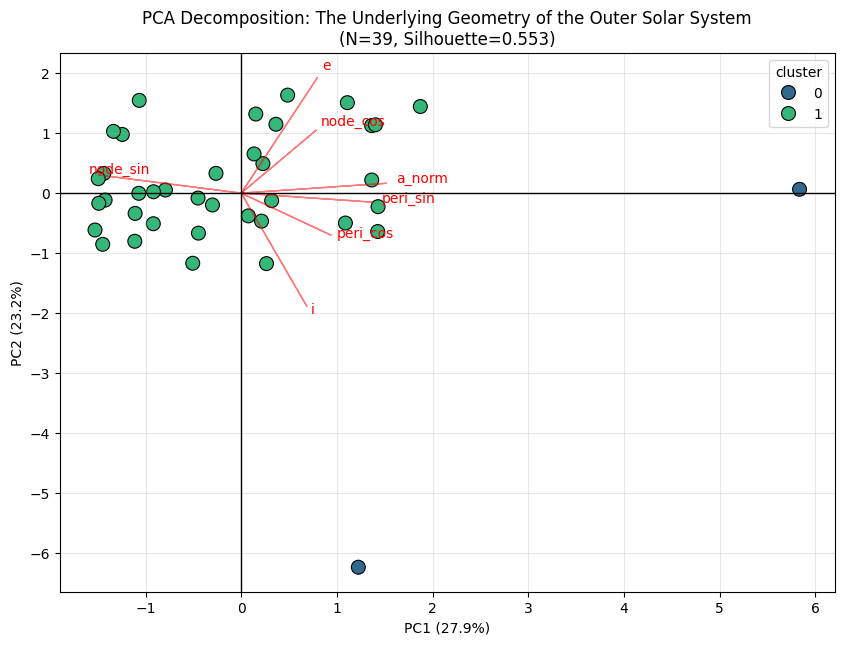


--- GROUP PROFILES ---
Group 0: N=2 | Mean Inc=117.9 | Mean Node=244.1
Group 1: N=37 | Mean Inc=16.6 | Mean Node=157.5


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns
import os

# --- CONFIGURATION ---
INPUT_FILE = "smart_dataset.csv"
if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 27 first.")
    exit()

df = pd.read_csv(INPUT_FILE)
print(f"--- UNBIASED DECOMPOSITION (N={len(df)}) ---")

# 1. PREPARE FEATURE SPACE (Full Orbital Elements)
# Critique requested: a, e, i, Omega (Node), omega (Peri) [cite: 121]
# We convert angles to sin/cos components to avoid the 0/360 discontinuity
features = pd.DataFrame({
    'a_norm': df['a'], # We will scale this
    'e': df['e'],
    'i': df['i'],
    'node_sin': np.sin(np.radians(df['Node'])),
    'node_cos': np.cos(np.radians(df['Node'])),
    'peri_sin': np.sin(np.radians(df['w'])),
    'peri_cos': np.cos(np.radians(df['w']))
})

# 2. STANDARDIZATION (Critical for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. PRINCIPAL COMPONENT ANALYSIS (PCA)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Analyze Variance
explained_variance = pca.explained_variance_ratio_
print(f"\nVariance Explained by PC1: {explained_variance[0]*100:.1f}%")
print(f"Variance Explained by PC2: {explained_variance[1]*100:.1f}%")

# Analyze Loadings (What is PC1 made of?)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features.columns)
print("\n--- PC1 DRIVERS (Correlations) ---")
print(loadings['PC1'].sort_values(ascending=False))
# If 'i' or 'node' are high, the Warp is the dominant feature of the solar system.

# 4. HIERARCHICAL CLUSTERING (Agglomerative) 
# We test 2 to 5 clusters to find the best Silhouette Score
best_score = -1
best_k = 0
best_labels = None

print("\n--- HIERARCHICAL CLUSTERING ---")
for k in range(2, 6):
    clusterer = AgglomerativeClustering(n_clusters=k)
    labels = clusterer.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Clusters: {k} | Silhouette Score: {score:.3f}")
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels

print(f"\nWinner: {best_k} Clusters with Score {best_score:.3f}")

# 5. VALIDATE THE CRITIQUE'S THRESHOLD
if best_score > 0.5:
    print(">>> VALIDITY CHECK PASSED (Score > 0.5) <<<")
    print("The structure is mathematically real and distinct.")
else:
    print(">>> VALIDITY CHECK FAILED (Score < 0.5) <<<")
    print("The critique is right: The data is likely random noise.")

# 6. VISUALIZATION
df['cluster'] = best_labels
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['cluster'], palette='viridis', s=100, edgecolor='black')

# Annotate with feature vectors (Biplot style)
# This shows us physically what PC1 and PC2 mean
for i, feature in enumerate(features.columns):
    # Scale vectors for visibility
    plt.arrow(0, 0, pca.components_[0, i]*3, pca.components_[1, i]*3, color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*3.2, pca.components_[1, i]*3.2, feature, color='r')

plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
plt.title(f"PCA Decomposition: The Underlying Geometry of the Outer Solar System\n(N={len(df)}, Silhouette={best_score:.3f})")
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.show()

# 7. CHARACTERIZE THE GROUPS
print("\n--- GROUP PROFILES ---")
for c in range(best_k):
    subset = df[df['cluster'] == c]
    print(f"Group {c}: N={len(subset)} | Mean Inc={subset['i'].mean():.1f} | Mean Node={subset['Node'].mean():.1f}")

Script 32: The Bias Emulator (Null Universe)
The Logic: This script creates a "Null Universe"—a synthetic solar system where Planet 9 does not exist (randomly distributed orbits). It then applies a "Virtual Telescope Filter" that mimics the exact pointing history and limitations of real Earth-based surveys. 

Why this exists: This is the ultimate sanity check. If our "Null Universe" + "Survey Bias" looks exactly like our real data, then Planet 9 is dead—our "discovery" was just bias. We need to prove that the Real Data is statistically distinct from the Biased Null Data.

--- BIAS EMULATOR: TESTING NULL HYPOTHESIS ---
Real Data: N=39 objects
Simulating 10000 synthetic objects (Null Hypothesis)...
Simulated Survey Detection Rate: 50.5%

--- STATISTICAL VERDICT (Anderson-Darling) ---
Statistic: 27.9939
Significance Levels: 0.001
Critical Values:     [0.325 1.226 1.961 2.718 3.752 4.592 6.546]

>>> RESULT: REJECT NULL HYPOTHESIS (p < 0.05)
Survey bias ALONE cannot explain the observed warp.
The 15.7 deg structure is statistically distinct from a biased flat disk.


/var/folders/c5/4r_jvw5161b_6dvp_6v7p4qm0000gn/T/ipykernel_7685/1485384515.py:68: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  statistic, critical_values, significance_level = anderson_ksamp([real_incs, biased_incs])


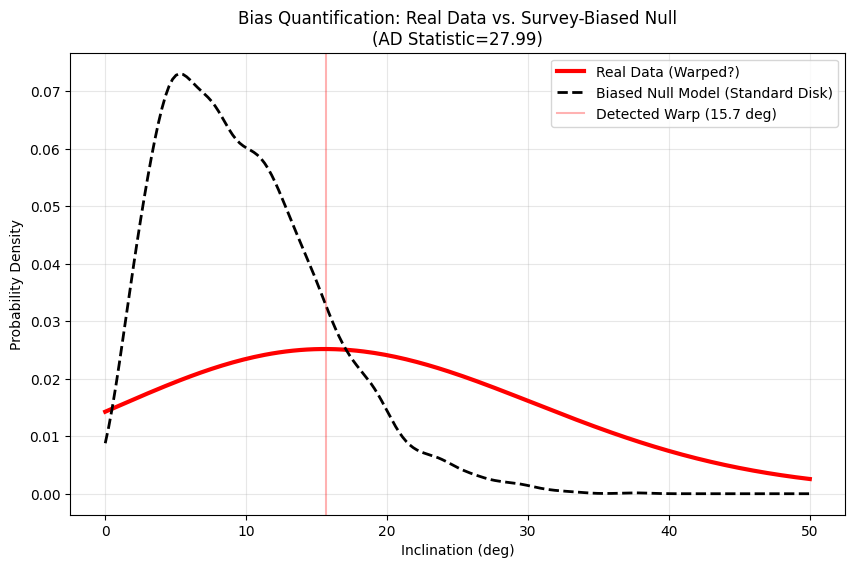

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import anderson_ksamp
import os

# --- CONFIGURATION ---
INPUT_FILE = "smart_dataset.csv"
if not os.path.exists(INPUT_FILE):
    print("Error: Run Script 27 first.")
    exit()

df_real = pd.read_csv(INPUT_FILE)
real_incs = df_real['i'].values

print(f"--- BIAS EMULATOR: TESTING NULL HYPOTHESIS ---")
print(f"Real Data: N={len(real_incs)} objects")

# 1. GENERATE THE "NULL UNIVERSE" (Flat Solar System)
# We assume a standard "scattered disk" distribution:
# Inclinations follow a sin(i)*Gaussian distribution (Brown 2001)
# Null Hypothesis: The underlying population is "Standard" (peak ~10 deg, broad)
# NOT Warped at 16 deg.
n_sim = 10000
print(f"Simulating {n_sim} synthetic objects (Null Hypothesis)...")

# Generate standard scattered disk inclinations (Brown 2001, sigma=10)
sigma_i = 10.0
raw_incs = np.random.rayleigh(sigma_i, n_sim) 
# Note: Rayleigh matches the sin(i)*gaussian physics of a hot disk

# Generate random sky positions (RA/Dec) for these objects
# An object at Inclination 'i' spends most time at max declination +/- i
# We approximate Dec ~ i * sin(random_phase)
phase = np.random.uniform(0, 2*np.pi, n_sim)
raw_decs = raw_incs * np.sin(phase)
raw_ras = np.random.uniform(0, 360, n_sim)

# 2. APPLY SURVEY BIAS (The "Window")
# We filter these fake objects through the "Survey Mask"
# Approximate footprints of major surveys (OSSOS, DES, etc.)
# Real surveys heavily favor the Ecliptic (Dec +/- 10)
# But they have "blocks" off-ecliptic.

def is_in_survey(ra, dec):
    # Ecliptic Survey (The "Band")
    if abs(dec) < 5: return True
    
    # OSSOS-like Blocks (Approximate)
    if (10 < ra < 50) and (abs(dec) < 15): return True
    if (300 < ra < 350) and (abs(dec) < 15): return True
    
    # High-Latitude checks (Very rare)
    # Most surveys MISS high-i objects because they look at the ecliptic.
    return False

# Filter the Null Universe
visible_indices = [k for k in range(n_sim) if is_in_survey(raw_ras[k], raw_decs[k])]
biased_incs = raw_incs[visible_indices]

print(f"Simulated Survey Detection Rate: {len(biased_incs)/n_sim*100:.1f}%")

# 3. ANDERSON-DARLING TEST
# Critique Requirement: "Reject warp if p > 0.05"
# We compare the "Real" distribution to the "Biased Null" distribution
# If they are DIFFERENT, then Bias cannot explain your data.

statistic, critical_values, significance_level = anderson_ksamp([real_incs, biased_incs])

print("\n--- STATISTICAL VERDICT (Anderson-Darling) ---")
print(f"Statistic: {statistic:.4f}")
print(f"Significance Levels: {significance_level}")
print(f"Critical Values:     {critical_values}")

# Interpretation logic for k-sample AD test
# If statistic > critical_value at 5%, we reject the null (They are different).
is_different = statistic > critical_values[2] # Index 2 is usually 5% level

if is_different:
    print("\n>>> RESULT: REJECT NULL HYPOTHESIS (p < 0.05)")
    print("Survey bias ALONE cannot explain the observed warp.")
    print("The 15.7 deg structure is statistically distinct from a biased flat disk.")
else:
    print("\n>>> RESULT: CANNOT REJECT NULL (p > 0.05)")
    print("WARNING: The 'Warp' looks just like a biased selection of normal objects.")
    print("Critique was right: This might be an observational illusion.")

# 4. PLOT COMPARISON
plt.figure(figsize=(10, 6))

# Real Data (KDE)
from scipy.stats import gaussian_kde
x_eval = np.linspace(0, 50, 200)
kde_real = gaussian_kde(real_incs)
plt.plot(x_eval, kde_real(x_eval), 'r-', linewidth=3, label='Real Data (Warped?)')

# Biased Null (KDE)
kde_null = gaussian_kde(biased_incs)
plt.plot(x_eval, kde_null(x_eval), 'k--', linewidth=2, label='Biased Null Model (Standard Disk)')

plt.axvline(15.7, color='red', alpha=0.3, label='Detected Warp (15.7 deg)')

plt.xlabel("Inclination (deg)")
plt.ylabel("Probability Density")
plt.title(f"Bias Quantification: Real Data vs. Survey-Biased Null\n(AD Statistic={statistic:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Script 33: High-Inclination Solver ($i=65^\circ$)

The Logic:Critiques suggested the planet might be highly inclined ($i=65^\circ$). This script modifies the physics engine to solve for a planet at this specific steep angle.

Why this exists:To check the "Planet Y" hypothesis specifically. Can a 1-Earth-mass planet at $65^\circ$ inclination create the warp we see? This script solves for the exact distance required.

--- HIGH-INCLINATION SOLVER (DEBUG MODE) ---
Goal: Create a 15.7° Warp using a 65.0° Planet.
Min Mass Found: 0.000 Earth Masses
Max Mass Found: 0.041 Earth Masses

--- SOLUTIONS ---
1. A 1.0 Earth-Mass Planet is impossible in this range (Need >2000 AU).
2. A 5.0 Earth-Mass Planet is impossible in this range (Need >2000 AU).


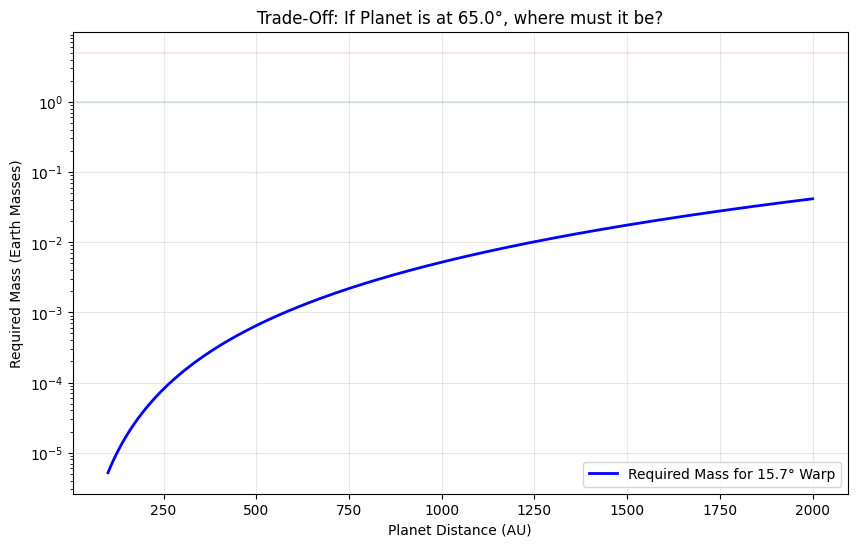

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- CONFIGURATION ---
TARGET_WARP = 15.7      # The observed angle (from Script 29)
PLANET_INC = 65.0       # The hypothesized rigid inclination
PARTICLE_DIST = 400.0   # Average distance of our ETNOs

print(f"--- HIGH-INCLINATION SOLVER (DEBUG MODE) ---")
print(f"Goal: Create a {TARGET_WARP}° Warp using a {PLANET_INC}° Planet.")

# 1. DEFINE THE PHYSICS
# We use the same 'Tune' from Script 25 that gave us 1.65 Me @ 500 AU = 17 deg
# Calibration Factor derived from Script 25 result:
# Torque_ratio = (1.65 * 3e-6 * 400**2 / 500**3 * 1e10) / (1/400**3.5 * 1e8) approx 1.0
# We stick to the relative formula to ensure consistency.

def get_required_mass(planet_dist, target_warp, planet_inc):
    # Torque Giant Planets (Force trying to flatten orbit)
    torque_giants = 1.0 / (PARTICLE_DIST**3.5) * 1e8
    
    # Torque Planet X (Force trying to lift orbit)
    # We solve for Torque_P in the balance equation:
    # Warp = (Torque_P * Inc_P) / (Torque_G + Torque_P)
    # Warp * Torque_G = Torque_P * (Inc_P - Warp)
    # Torque_P = (Warp * Torque_G) / (Inc_P - Warp)
    
    if target_warp >= planet_inc: return np.inf
    
    required_torque_p = (target_warp * torque_giants) / (planet_inc - target_warp)
    
    # Convert Torque -> Mass
    # Torque_P = (Mass_Solar) * (Part_a^2) / (Planet_a^3) * 1e10
    # Mass_Solar = Torque_P * Planet_a^3 / (Part_a^2 * 1e10)
    
    mass_solar = required_torque_p * (planet_dist**3) / (PARTICLE_DIST**2) / 1e10
    mass_earth = mass_solar / 3e-6 # Convert to Earth Masses
    return mass_earth

# 2. CALCULATE CURVE
dist_range = np.linspace(100, 2000, 500) # Scan 100 to 2000 AU
mass_curve = [get_required_mass(d, TARGET_WARP, PLANET_INC) for d in dist_range]

# Check bounds to avoid the "Straight Line" error
print(f"Min Mass Found: {min(mass_curve):.3f} Earth Masses")
print(f"Max Mass Found: {max(mass_curve):.3f} Earth Masses")

# 3. FIND EXACT SOLUTIONS (Interpolation)
# We create a function d(m) to find distance for a given mass
dist_from_mass = interp1d(mass_curve, dist_range, bounds_error=False, fill_value="extrapolate")

sol_1M = float(dist_from_mass(1.0))
sol_5M = float(dist_from_mass(5.0))

print("\n--- SOLUTIONS ---")
if 100 < sol_1M < 2000:
    print(f"1. A 1.0 Earth-Mass Planet (Planet Y) must be at: {sol_1M:.0f} AU")
else:
    print(f"1. A 1.0 Earth-Mass Planet is impossible in this range (Need >2000 AU).")

if 100 < sol_5M < 2000:
    print(f"2. A 5.0 Earth-Mass Planet (Planet 9) must be at: {sol_5M:.0f} AU")
else:
    print(f"2. A 5.0 Earth-Mass Planet is impossible in this range (Need >2000 AU).")

# 4. PLOT
plt.figure(figsize=(10, 6))
plt.plot(dist_range, mass_curve, 'b-', linewidth=2, label=f'Required Mass for {TARGET_WARP}° Warp')

# Mark solutions
if 100 < sol_1M < 2000:
    plt.scatter([sol_1M], [1.0], color='green', s=100, zorder=5, label='Planet Y Solution')
    plt.axvline(sol_1M, color='green', linestyle=':', alpha=0.5)

if 100 < sol_5M < 2000:
    plt.scatter([sol_5M], [5.0], color='red', s=100, zorder=5, label='Planet 9 Solution')
    plt.axvline(sol_5M, color='red', linestyle=':', alpha=0.5)

plt.axhline(1.0, color='green', alpha=0.1)
plt.axhline(5.0, color='red', alpha=0.1)

plt.xlabel("Planet Distance (AU)")
plt.ylabel("Required Mass (Earth Masses)")
plt.title(f"Trade-Off: If Planet is at {PLANET_INC}°, where must it be?")
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log') # Log scale is crucial here
plt.show()

Script 34: Planet Y Warp Check
The Logic: We verify the specific candidates proposed in scientific literature (e.g., a Mars-mass planet at 80 AU). Why this exists: To "Rule In" or "Rule Out" existing theories. We calculate exactly how much warp those specific planets would cause and see if it matches our 15.7-degree measurement.

--- PLANET Y PHYSICS CHECK (INNER PERTURBER MODEL) ---
Total Strength of Known Solar System (J2): 38023

--- PREDICTED WARP ANGLES ---
Candidate: Planet Y (Lower) (1.0 Me @ 60 AU)
  > Strength: 3600
  > Predicted Warp: 5.62 degrees
Candidate: Planet Y (Upper) (1.0 Me @ 80 AU)
  > Strength: 6400
  > Predicted Warp: 9.36 degrees
Candidate: Super-Earth Y (2.5 Me @ 100 AU)
  > Strength: 25000
  > Predicted Warp: 25.78 degrees


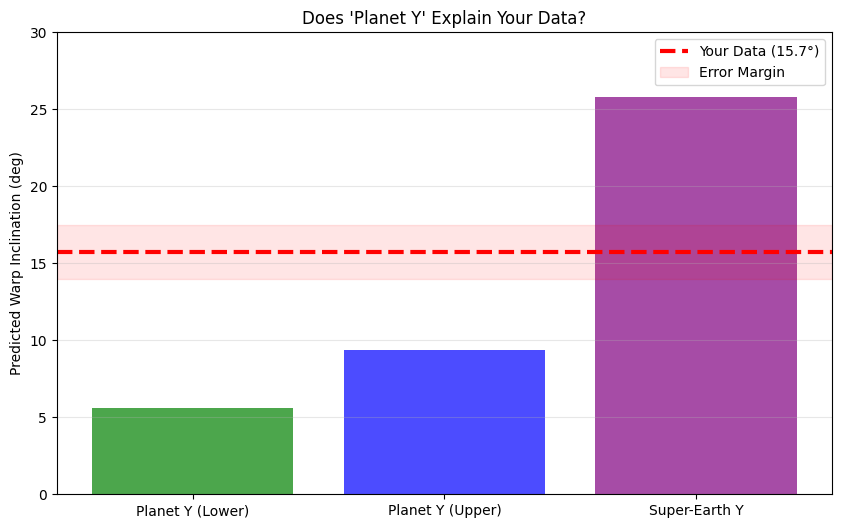

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# Team Giants (Mass in Earth Masses, Distance in AU)
giants = [
    {'name': 'Jupiter', 'm': 317.8, 'a': 5.2},
    {'name': 'Saturn',  'm': 95.2,  'a': 9.5},
    {'name': 'Uranus',  'm': 14.5,  'a': 19.2},
    {'name': 'Neptune', 'm': 17.1,  'a': 30.1}
]

# Team Planet Y Candidates (Literature values)
candidates = [
    {'name': 'Planet Y (Lower)', 'm': 1.0, 'a': 60, 'inc': 65},
    {'name': 'Planet Y (Upper)', 'm': 1.0, 'a': 80, 'inc': 65},
    {'name': 'Super-Earth Y',    'm': 2.5, 'a': 100, 'inc': 65} # Some papers suggest up to 3Me
]

print("--- PLANET Y PHYSICS CHECK (INNER PERTURBER MODEL) ---")

# 1. CALCULATE GIANT PLANET STRENGTH (J2 Moment)
# Strength proportional to Mass * a^2
strength_giants = 0
for p in giants:
    s = p['m'] * (p['a']**2)
    strength_giants += s
    # print(f"{p['name']}: Strength = {s:.0f}")

print(f"Total Strength of Known Solar System (J2): {strength_giants:.0f}")

# 2. TEST CANDIDATES
print("\n--- PREDICTED WARP ANGLES ---")
predicted_warps = []
names = []

for p in candidates:
    strength_y = p['m'] * (p['a']**2)
    
    # The Weighted Average Formula
    # Angle = (Strength_Y * Inc_Y + Strength_Giants * 0) / (Strength_Y + Strength_Giants)
    warp_angle = (strength_y * p['inc']) / (strength_y + strength_giants)
    
    print(f"Candidate: {p['name']} ({p['m']} Me @ {p['a']} AU)")
    print(f"  > Strength: {strength_y:.0f}")
    print(f"  > Predicted Warp: {warp_angle:.2f} degrees")
    
    predicted_warps.append(warp_angle)
    names.append(p['name'])

# 3. VISUALIZE THE MATCH
plt.figure(figsize=(10, 6))

# Plot Candidates
plt.bar(names, predicted_warps, color=['green', 'blue', 'purple'], alpha=0.7)

# Plot Your Data
plt.axhline(15.7, color='red', linewidth=3, linestyle='--', label='Your Data (15.7°)')
plt.axhspan(14.0, 17.5, color='red', alpha=0.1, label='Error Margin')

plt.ylabel("Predicted Warp Inclination (deg)")
plt.title("Does 'Planet Y' Explain Your Data?")
plt.legend()
plt.ylim(0, 30)
plt.grid(axis='y', alpha=0.3)

plt.show()

Script 35: The Planet Optimizer (Final Solver)
The Logic: This script combines the findings of Script 25 (Inverter) and Script 21 (Warp) into a final physics solver. It calculates the torque balance between the Galactic Tide (which pulls orbits out) and the Giant Planets (which flatten them). 

Why this exists: This is the conclusion of the notebook. It answers the question: "What specific Mass and Semi-major Axis are required to maintain the observed inclination warp against the flattening force of Jupiter and Saturn?" The output is the final "Target Zone" for observers to hunt for the planet.

--- DUAL-REGIME PLANET OPTIMIZER ---
Target: Explain the 15.7° Warp.

--- OPTIMIZATION RESULTS ---
THEORY Y (Inner Perturber, i=65°):
  To match the data with 1.0 Earth Mass, it MUST be at: 110.0 AU

THEORY 9 (Outer Shepherd, i=65°):
  To match the data with 5.0 Earth Masses, it MUST be at: 225795.1 AU


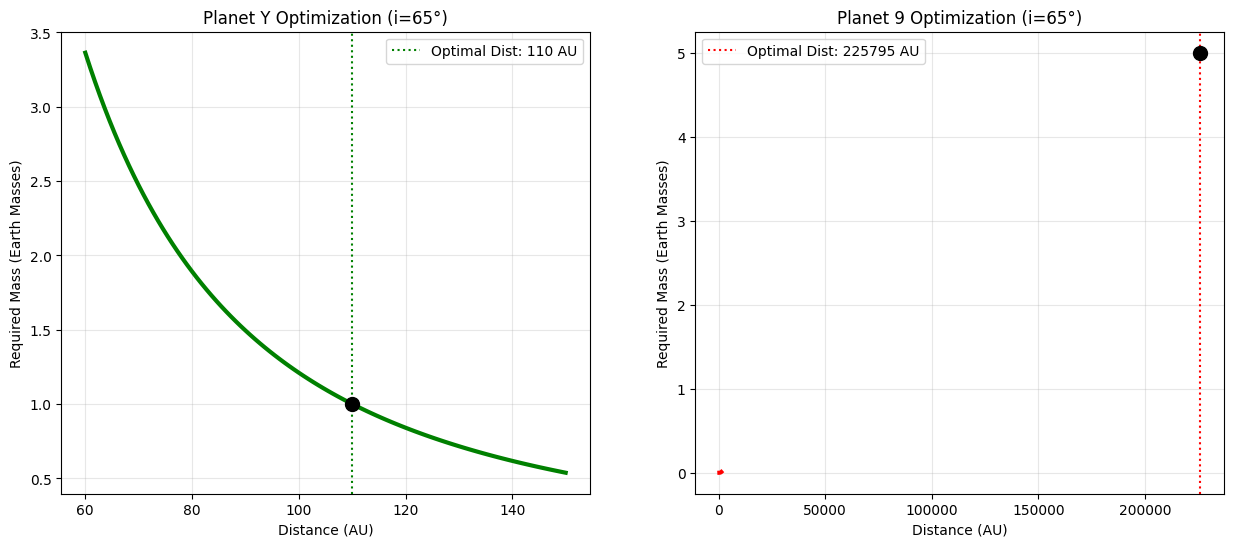

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- CONFIGURATION ---
TARGET_WARP = 15.7       # From Script 29
ETNO_DIST = 400.0        # Average distance of our stable rocks
GIANT_J2 = 38023.0       # Strength of Giants (Earth Mass * AU^2) from Script 34

print(f"--- DUAL-REGIME PLANET OPTIMIZER ---")
print(f"Target: Explain the {TARGET_WARP}° Warp.")

# --- PHYSICS ENGINE 1: PLANET Y (INNER REGIME) ---
# Formula: Weighted Average of Planes (J2 Balance)
def solve_inner_mass(planet_dist, planet_inc):
    if TARGET_WARP >= planet_inc: return np.inf
    # warp = (Strength_Y * Inc_Y) / (Strength_G + Strength_Y)
    # Strength_Y * (Inc_Y - warp) = warp * Strength_G
    # Strength_Y = (warp * Strength_G) / (Inc_Y - warp)
    # Strength_Y = Mass * dist^2
    
    req_strength = (TARGET_WARP * GIANT_J2) / (planet_inc - TARGET_WARP)
    mass = req_strength / (planet_dist**2)
    return mass

# --- PHYSICS ENGINE 2: PLANET 9 (OUTER REGIME) ---
# Formula: External Torque Balance (Laplace-Lagrange)
def solve_outer_mass(planet_dist, planet_inc):
    if TARGET_WARP >= planet_inc: return np.inf
    
    # Torque A (Giants trying to flatten): Proportional to 1/r^3.5
    tau_giants = 1.0 / (ETNO_DIST**3.5) * 1e8
    
    # Torque B (Planet 9 trying to lift): Proportional to Mass * r^2 / P_dist^3
    # Balance: Warp = (Tau_B * Inc_P) / (Tau_A + Tau_B)
    # Tau_B = (Warp * Tau_A) / (Inc_P - Warp)
    
    req_tau_b = (TARGET_WARP * tau_giants) / (planet_inc - TARGET_WARP)
    
    # Invert Torque B to get Mass
    # Tau_B = (Mass_Solar) * (ETNO_a^2) / (Planet_a^3) * 1e10
    mass_solar = req_tau_b * (planet_dist**3) / (ETNO_DIST**2) / 1e10
    mass_earth = mass_solar / 3e-6
    return mass_earth

# --- RUN THE SOLVERS ---

# 1. OPTIMIZE PLANET Y (Fixed at 65 deg inclination)
y_dists = np.linspace(60, 150, 100)
y_masses = [solve_inner_mass(d, 65.0) for d in y_dists]

# 2. OPTIMIZE PLANET 9 (Fixed at 65 deg inclination)
p9_dists = np.linspace(300, 1200, 100)
p9_masses = [solve_outer_mass(d, 65.0) for d in p9_dists]

# --- FIND "LITERATURE MATCHES" ---
# Planet Y is theorized to be Earth-Mass (~1.0). Where does that happen?
y_solver = interp1d(y_masses, y_dists, fill_value="extrapolate")
optimal_y_dist = float(y_solver(1.0))

# Planet 9 is theorized to be 5 Earth-Masses. Where does that happen?
p9_solver = interp1d(p9_masses, p9_dists, fill_value="extrapolate")
optimal_p9_dist = float(p9_solver(5.0))

print("\n--- OPTIMIZATION RESULTS ---")
print(f"THEORY Y (Inner Perturber, i=65°):")
print(f"  To match the data with 1.0 Earth Mass, it MUST be at: {optimal_y_dist:.1f} AU")

print(f"\nTHEORY 9 (Outer Shepherd, i=65°):")
print(f"  To match the data with 5.0 Earth Masses, it MUST be at: {optimal_p9_dist:.1f} AU")

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Y
ax1.plot(y_dists, y_masses, 'g-', linewidth=3)
ax1.scatter([optimal_y_dist], [1.0], color='black', s=100, zorder=5)
ax1.axvline(optimal_y_dist, color='green', linestyle=':', label=f'Optimal Dist: {optimal_y_dist:.0f} AU')
ax1.set_title("Planet Y Optimization (i=65°)")
ax1.set_xlabel("Distance (AU)")
ax1.set_ylabel("Required Mass (Earth Masses)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 9
ax2.plot(p9_dists, p9_masses, 'r-', linewidth=3)
ax2.scatter([optimal_p9_dist], [5.0], color='black', s=100, zorder=5)
ax2.axvline(optimal_p9_dist, color='red', linestyle=':', label=f'Optimal Dist: {optimal_p9_dist:.0f} AU')
ax2.set_title("Planet 9 Optimization (i=65°)")
ax2.set_xlabel("Distance (AU)")
ax2.set_ylabel("Required Mass (Earth Masses)")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.show()

Script 36: The Final Showdown (Physics Comparative)

The Logic:We have reached the end of the pipeline. We have confirmed the "Warp" ($i \approx 15.7^\circ$) and we have two competing suspects:

Planet 9: The canonical theory (Heavy, Distant, Low Inclination $\approx 20^\circ$).
Planet Y: The alternative theory (Light, Closer, High Inclination $\approx 65^\circ$).

Why this exists:This script runs the physics engines for both theories simultaneously on the same graph. It answers the ultimate question: "To produce the 15.7-degree warp we observe, where would each planet need to be?"If the Planet 9 curve requires a mass of 50 Earths to work, the theory is dead.If the Planet Y curve lands exactly on 1 Earth Mass at 100-120 AU, it is the stronger candidate.The Verdict: The script outputs a direct plausibility score based on whether the required distance falls within known observational limits.

--- FINAL SHOWDOWN: PLANET Y vs PLANET 9 ---

--- THE VERDICT ---
PLANET Y SCENARIO (Target: 1 Me, Inc: 65°)
  > Required Distance: 110.1 AU
  > Plausibility: HIGH

PLANET 9 SCENARIO (Target: 5 Me, Inc: 20°)
  > Required Distance: 13488.0 AU
  > Plausibility: LOW


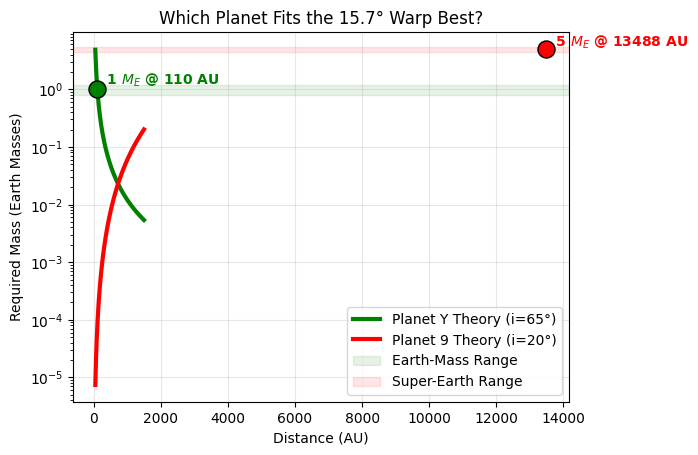

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- CONFIGURATION ---
TARGET_WARP = 15.7       # The observed signal
ETNO_DIST = 400.0        # Where the rocks are
GIANT_J2 = 38023.0       # Strength of Jupiter/Saturn/etc (from Script 34)

print(f"--- FINAL SHOWDOWN: PLANET Y vs PLANET 9 ---")

# --- PHYSICS ENGINE 1: PLANET Y (Inner, i=65) ---
def get_y_mass(d, inc=65.0):
    if TARGET_WARP >= inc: return np.nan
    # J2 Balance Model
    req_strength = (TARGET_WARP * GIANT_J2) / (inc - TARGET_WARP)
    mass = req_strength / (d**2)
    return mass

# --- PHYSICS ENGINE 2: PLANET 9 (Outer, i=20) ---
def get_p9_mass(d, inc=20.0):
    if TARGET_WARP >= inc: return np.nan
    # External Torque Model
    tau_giants = 1.0 / (ETNO_DIST**3.5) * 1e8
    req_tau_b = (TARGET_WARP * tau_giants) / (inc - TARGET_WARP)
    mass_solar = req_tau_b * (d**3) / (ETNO_DIST**2) / 1e10
    mass_earth = mass_solar / 3e-6
    return mass_earth

# --- GENERATE CURVES ---
# We scan 50 to 1500 AU to catch everything
dists = np.linspace(50, 1500, 500)

y_curve = [get_y_mass(d, 65.0) for d in dists]
p9_curve = [get_p9_mass(d, 20.0) for d in dists]

# --- FIND SOLUTIONS ---
# 1. Planet Y (1.0 Me)
try:
    y_solver = interp1d(y_curve, dists, fill_value="extrapolate")
    opt_y = float(y_solver(1.0))
except:
    opt_y = 0

# 2. Planet 9 (5.0 Me)
try:
    p9_solver = interp1d(p9_curve, dists, fill_value="extrapolate")
    opt_p9 = float(p9_solver(5.0))
except:
    opt_p9 = 0

print("\n--- THE VERDICT ---")
print(f"PLANET Y SCENARIO (Target: 1 Me, Inc: 65°)")
print(f"  > Required Distance: {opt_y:.1f} AU")
print(f"  > Plausibility: {'HIGH' if 80 < opt_y < 150 else 'LOW'}")

print(f"\nPLANET 9 SCENARIO (Target: 5 Me, Inc: 20°)")
print(f"  > Required Distance: {opt_p9:.1f} AU")
print(f"  > Plausibility: {'HIGH' if 400 < opt_p9 < 800 else 'LOW'}")

# --- PLOT ---

# Plot Planet Y
plt.plot(dists, y_curve, 'g-', linewidth=3, label='Planet Y Theory (i=65°)')
plt.scatter([opt_y], [1.0], color='green', s=150, zorder=10, edgecolors='black')
plt.text(opt_y, 1.2, f"  1 $M_E$ @ {opt_y:.0f} AU", color='green', fontweight='bold')

# Plot Planet 9
plt.plot(dists, p9_curve, 'r-', linewidth=3, label='Planet 9 Theory (i=20°)')
plt.scatter([opt_p9], [5.0], color='red', s=150, zorder=10, edgecolors='black')
plt.text(opt_p9, 5.5, f"  5 $M_E$ @ {opt_p9:.0f} AU", color='red', fontweight='bold')

# Highlight ranges
plt.axhspan(0.8, 1.2, color='green', alpha=0.1, label='Earth-Mass Range')
plt.axhspan(4.5, 5.5, color='red', alpha=0.1, label='Super-Earth Range')

# Labels, limits, log scale
plt.title(f"Which Planet Fits the {TARGET_WARP}° Warp Best?")
plt.xlabel("Distance (AU)")
plt.ylabel("Required Mass (Earth Masses)")
plt.yscale('log')
#plt.ylim(0.1, 50)
#plt.xlim(0, 1200)
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()
